---

# Feature Exploration

By: Tomás Urdiales

-> Notebook for dataset exploration and analysis. Mostly focusing on quarter-hourly validated historical records (DataWarehouse).

##### Libraries & Settings

In [ ]:
# Change notebook CWD to the project's root, so python can read from src:
import os
os.chdir("..")

In [8]:
import numpy as np
import pandas as pd
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Handle date time conversions between pandas and matplotlib
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from src import utils, my_plots

##### Parameters

In [9]:
# Get root directory:
CWD = utils.get_root_dir()

DPI = 200 # (pixel density for figures)
ELIA_ORANGE = (250/256, 115/256, 1/256) # RGB

# Choose whether to only use 2022 as sample year.
use_only_2022 = False
# Choose whether to analyse system_imbalance_cum15 instead:
use_cum15 = False
# Attempt STL decomposition:
try_STL = False
# Whether to print out to .png:
output = True

##### Utility functions

In [10]:
def create_datetime_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    -> Generate datetime features from index
    """
    df = (df
          .copy()
          .assign(minute=df.index.minute.values.astype(np.int16),
                  hour=df.index.hour.values.astype(np.int16),
                  dayofmonth=df.index.day.values.astype(np.int16),
                  month=df.index.month.values.astype(np.int16),
                  year=df.index.year.values.astype(np.int16),
                  # dayofweek_name = df.index.day_name(),
                  dayofweek=df.index.dayofweek.values.astype(np.int16),
                  dayofyear=df.index.dayofyear.values.astype(np.int16),
                  weekofyear=df.index.isocalendar().week.values.astype(np.int16))
          )
    return df

##### Load data

In [11]:
# Load quarter-hourly dataset:
df = utils.load_qh_historical_data()

# Briefly describe:
df.info(verbose=False)
print(f"\nAvailable time span: {(df.index.max() - df.index.min()).days/365 :.2f} years")
print("\nColumns:\n", list(df.columns))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119908 entries, 2019-09-01 00:00:00+02:00 to 2023-01-31 23:45:00+01:00
Freq: 15T
Columns: 32 entries, si_mw to total_load_forecast_last_p90_mw
dtypes: float32(32)
memory usage: 15.6 MB

Available time span: 3.42 years

Columns:
 ['si_mw', 'system_imbalance_cum15', 'guv_mw', 'gdv_mw', 'ppos', 'pneg', 'wind_id_mw', 'wind_rt_mw', 'load_rt_mw', 'load_id_mw', 'r2_inc_mw', 'r2_dec_mw', 'solar_id_mw', 'solar_rt_mw', 'xb_id_mw', 'xb_rt_mw', 'dso_id_mw', 'dso_rt_mw', 'ap_rt_mw', 'ap_id_mw', 'mip_rt_', 'mdp_rt_', 'alpha_rt_', 'nrv_rt', 'price_da', 'total_load_last_mw', 'total_load_forecast_intraday_p10_mw', 'total_load_forecast_intraday_p90_mw', 'wind_production_forecast_intraday_p10_mw', 'wind_production_forecast_intraday_p90_mw', 'total_load_forecast_last_p10_mw', 'total_load_forecast_last_p90_mw']


In [12]:
# Store segments of df with missing data:
with_missing = df.drop("system_imbalance_cum15", axis=1).loc[df.drop("system_imbalance_cum15", axis=1).isnull().any(axis=1), df.drop("system_imbalance_cum15", axis=1).columns[df.drop("system_imbalance_cum15", axis=1).isnull().any(axis=0)]].copy()

print(f"{len(with_missing)} entries contain NaN")
print(set(with_missing.index.date))

5190 entries contain NaN
{datetime.date(2022, 10, 17), datetime.date(2022, 8, 16), datetime.date(2022, 8, 30), datetime.date(2022, 10, 12), datetime.date(2022, 8, 26), datetime.date(2020, 3, 10), datetime.date(2022, 10, 30), datetime.date(2021, 10, 31), datetime.date(2022, 8, 7), datetime.date(2022, 8, 9), datetime.date(2022, 8, 21), datetime.date(2022, 7, 31), datetime.date(2022, 8, 24), datetime.date(2022, 8, 11), datetime.date(2022, 10, 26), datetime.date(2021, 11, 16), datetime.date(2022, 8, 8), datetime.date(2022, 8, 28), datetime.date(2022, 8, 23), datetime.date(2020, 11, 6), datetime.date(2022, 8, 15), datetime.date(2022, 10, 24), datetime.date(2020, 3, 11), datetime.date(2022, 10, 11), datetime.date(2022, 10, 18), datetime.date(2022, 10, 13), datetime.date(2022, 8, 14), datetime.date(2022, 10, 29), datetime.date(2022, 8, 10), datetime.date(2022, 10, 14), datetime.date(2022, 8, 4), datetime.date(2022, 8, 5), datetime.date(2022, 8, 18), datetime.date(2022, 8, 29), datetime.date(2

---

## System Imbalance

In [13]:
# Extract SI signal:
si = df[["si_mw"]].copy()

if use_only_2022:
    si = si.loc["2022"]

if use_cum15:
    si = df[["system_imbalance_cum15"]].copy().dropna()
    si = si.rename(columns={"system_imbalance_cum15": "si_mw"})

si = utils.create_datetime_features(si)
print("Macro-scale descriptive stats:")
print(si["si_mw"].describe(),"\n")
si.head(5)

# Resampling:
# si.resample('15min').mean().ffill()

Macro-scale descriptive stats:
count    119908.000000
mean        -16.474812
std         170.615891
min       -1419.709961
25%        -109.300753
50%         -10.643000
75%          79.732252
max        1257.069946
Name: si_mw, dtype: float64 



si_mw  minute  hour  dayofmonth  month  year  \
datetime_cet                                                                   
2019-09-01 00:00:00+02:00 -283.563995       0     0           1      9  2019   
2019-09-01 00:15:00+02:00  -73.934998      15     0           1      9  2019   
2019-09-01 00:30:00+02:00  -46.207001      30     0           1      9  2019   
2019-09-01 00:45:00+02:00  -69.299004      45     0           1      9  2019   
2019-09-01 01:00:00+02:00  -21.325001       0     1           1      9  2019   

                           dayofweek  dayofyear  weekofyear  
datetime_cet                                                 
2019-09-01 00:00:00+02:00          6        244          35  
2019-09-01 00:15:00+02:00          6        244          35  
2019-09-01 00:30:00+02:00          6        244          35  
2019-09-01 00:45:00+02:00          6        244          35  
2019-09-01 01:00:00+02:00          6        244          35

The mean is fairly heavily tilted towards the negative! This may represent that there is typically a negative imbalance (higher demand than supply), so it can be deduced that it is easier for operators to maintain balance when they are "trailing" demand.

Standard deviation below 200MW and IQR show most imbalances are in the range of [-110,+80].

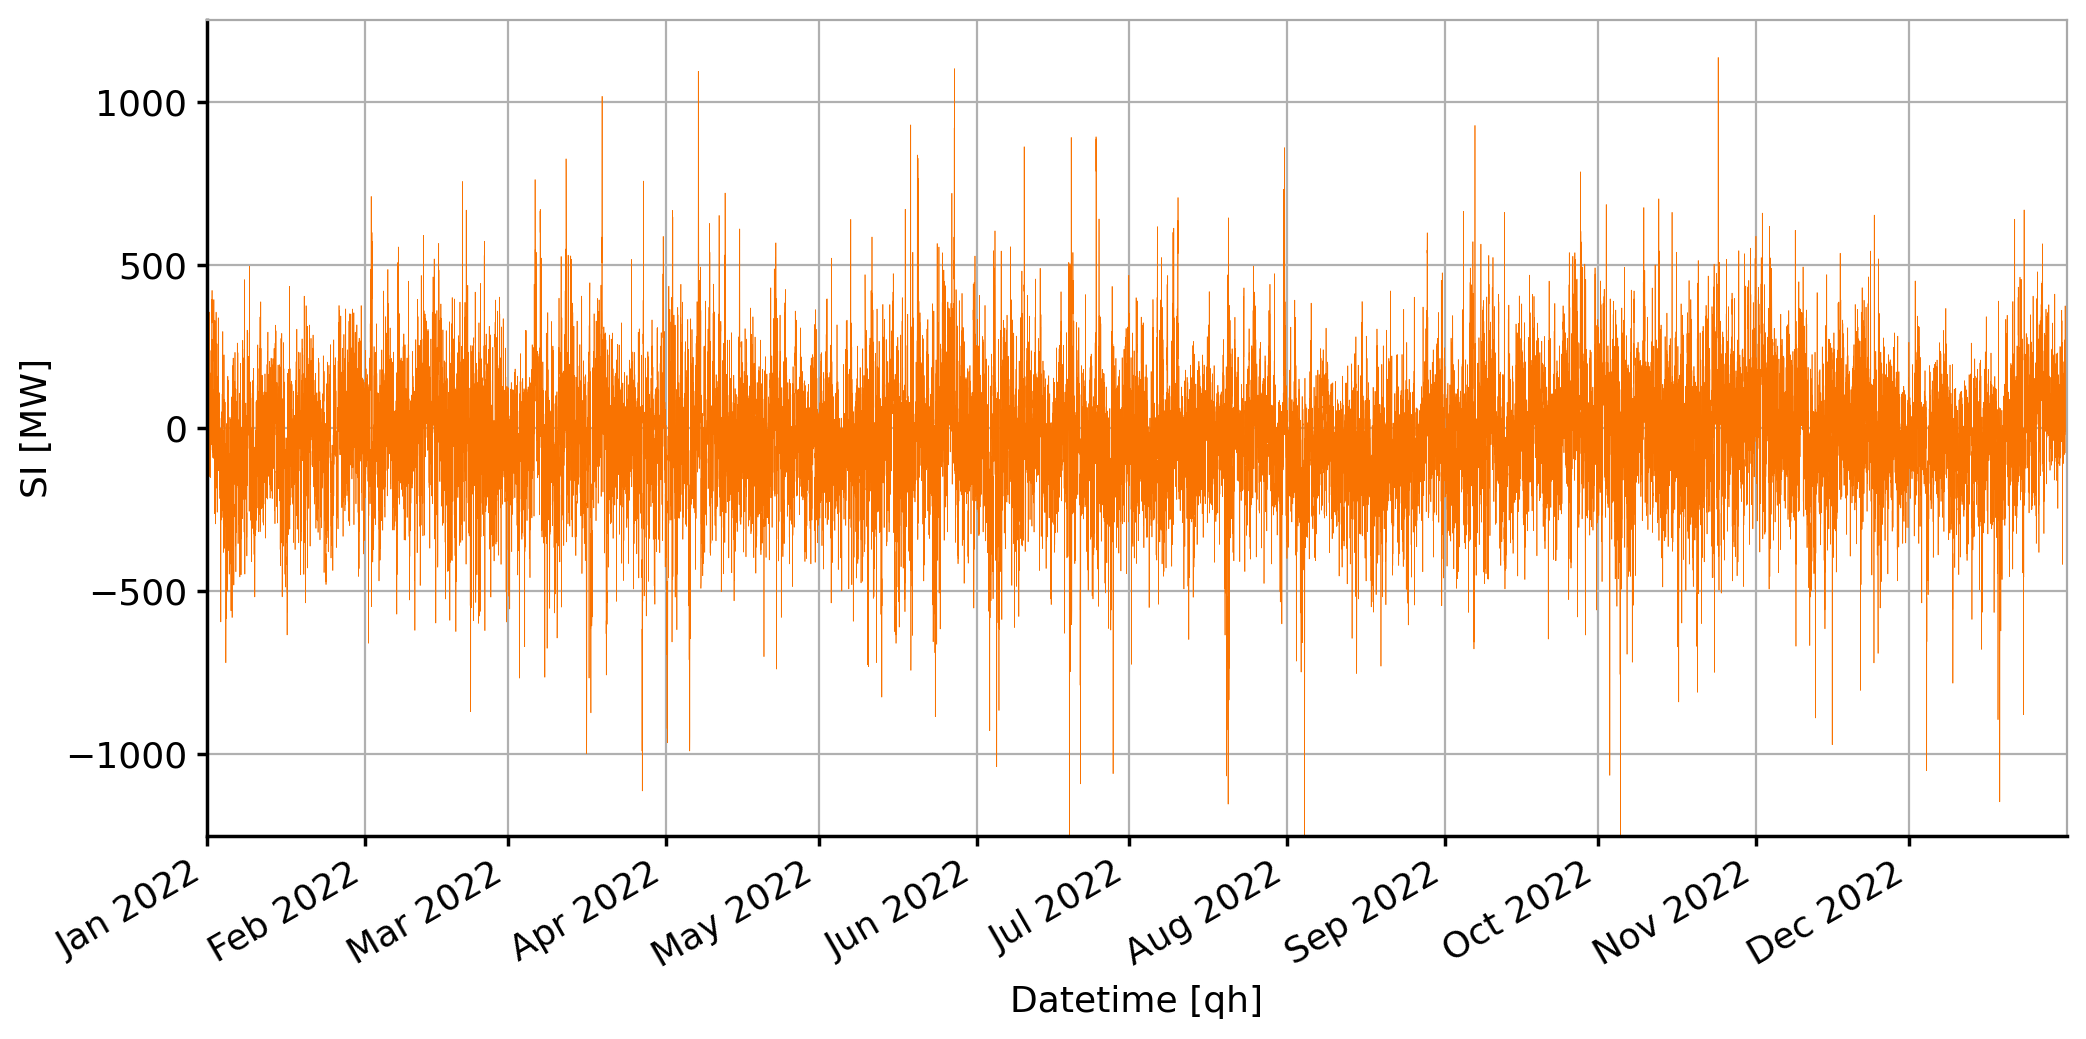

In [14]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)
ax.plot(si["si_mw"].loc["2022"], linewidth=0.25, c=ELIA_ORANGE, alpha=1)
ax.set_xlabel("Datetime [qh]", fontsize=13); ax.set_ylabel("SI [MW]", fontsize=13)
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
my_plots.despine(plt.gca(), grid=True)
plt.xlim([si["si_mw"].loc["2022"].index[0], si["si_mw"].loc["2022"].index[-1]])
plt.ylim(-1250, 1250)
plt.grid()

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate()

if output:
     fig.savefig("/Users/tomasurdiales/Desktop/fig1.png", dpi=300)

plt.show()

Histogram shows a slight tilt towards the negative values:

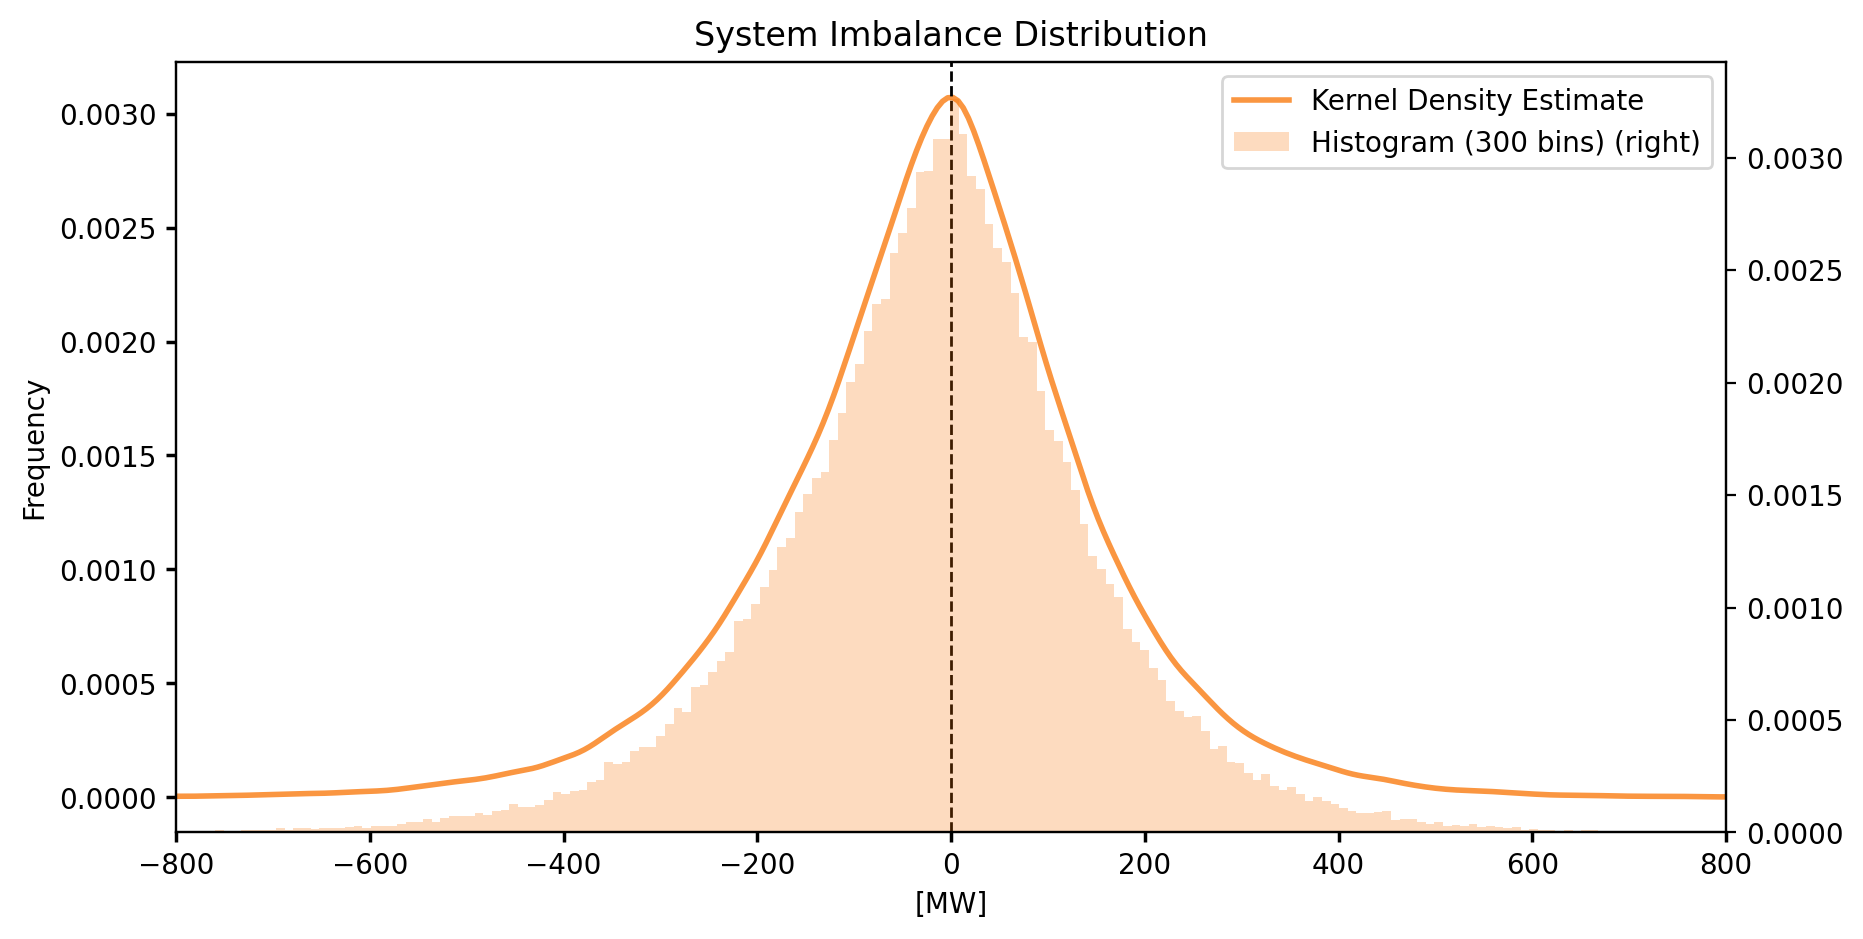

In [12]:
n_bins = 300
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)
si.plot(y="si_mw", ax=ax, kind="kde", color=ELIA_ORANGE, alpha=0.75,
        linewidth=2, label="Kernel Density Estimate")
si.plot(y="si_mw", ax=ax, kind="hist", bins=n_bins, alpha=0.25,
        density=True, color=ELIA_ORANGE, label=f"Histogram ({n_bins} bins)",
        secondary_y=True)
ax.set_title("System Imbalance Distribution")
plt.xlim(-1500,1500)
ax.tick_params(width=1.25)
ax.axvline(0, color='black', ls='--', linewidth=1, alpha=1)
ax.set_xlabel("[MW]")
ax.set_xlim(-800, 800)
plt.show()

if output:
     fig.savefig("/Users/tomasurdiales/Desktop/fig2.png", dpi=300)

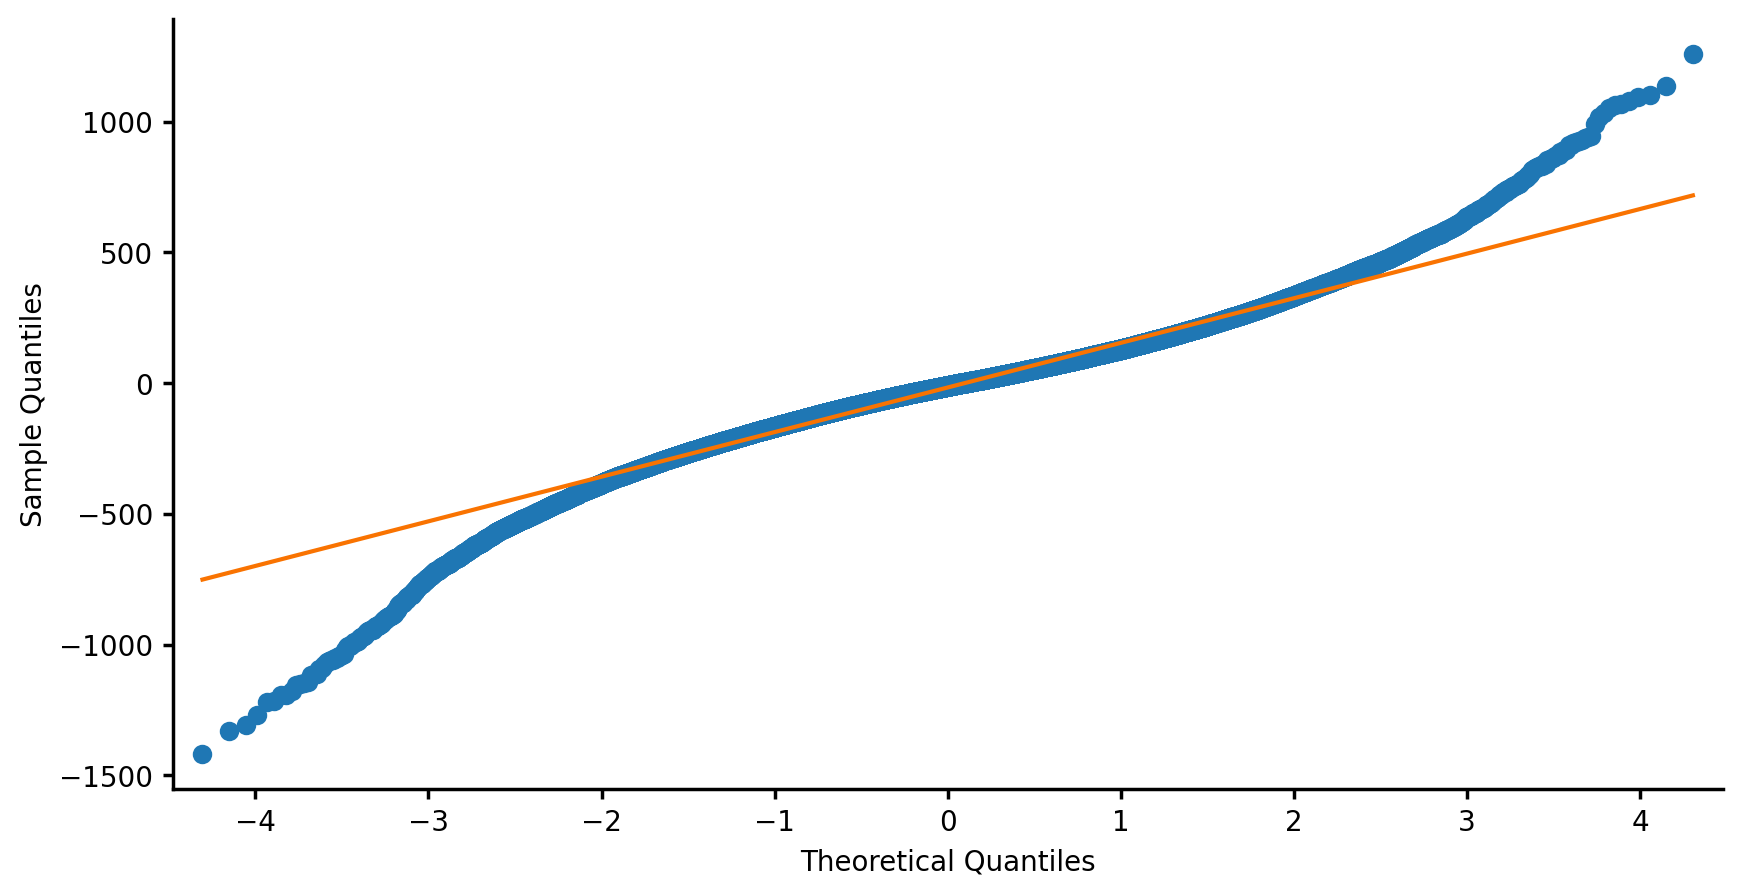

In [18]:
import statsmodels.api as sm
from scipy.stats import norm

fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)
# my_data = norm.rvs(size=1000)
sm.qqplot(si["si_mw"], line="s", ax = ax)
ax.get_lines()[1].set_color(ELIA_ORANGE)

my_plots.despine(ax)

fig.savefig("qqplot.png", dpi=300)
plt.show()

In [56]:
from scipy.stats import kstest, norm
my_data = norm.rvs(size=1000)
ks_statistic, p_value = kstest(si["si_mw"], cdf="norm")
print(ks_statistic, p_value)

0.48699909719283196 0.0


#### Volume over time

In [19]:
def calculate_imbalance_volume(group, how="sum"):
    if how == "sum":
        return group.abs().sum()*0.25*1e-3  # To obtain GWh (multiply by 1/4 h)
    elif how=="mean":
        return group.abs().mean() # To obtain average MW

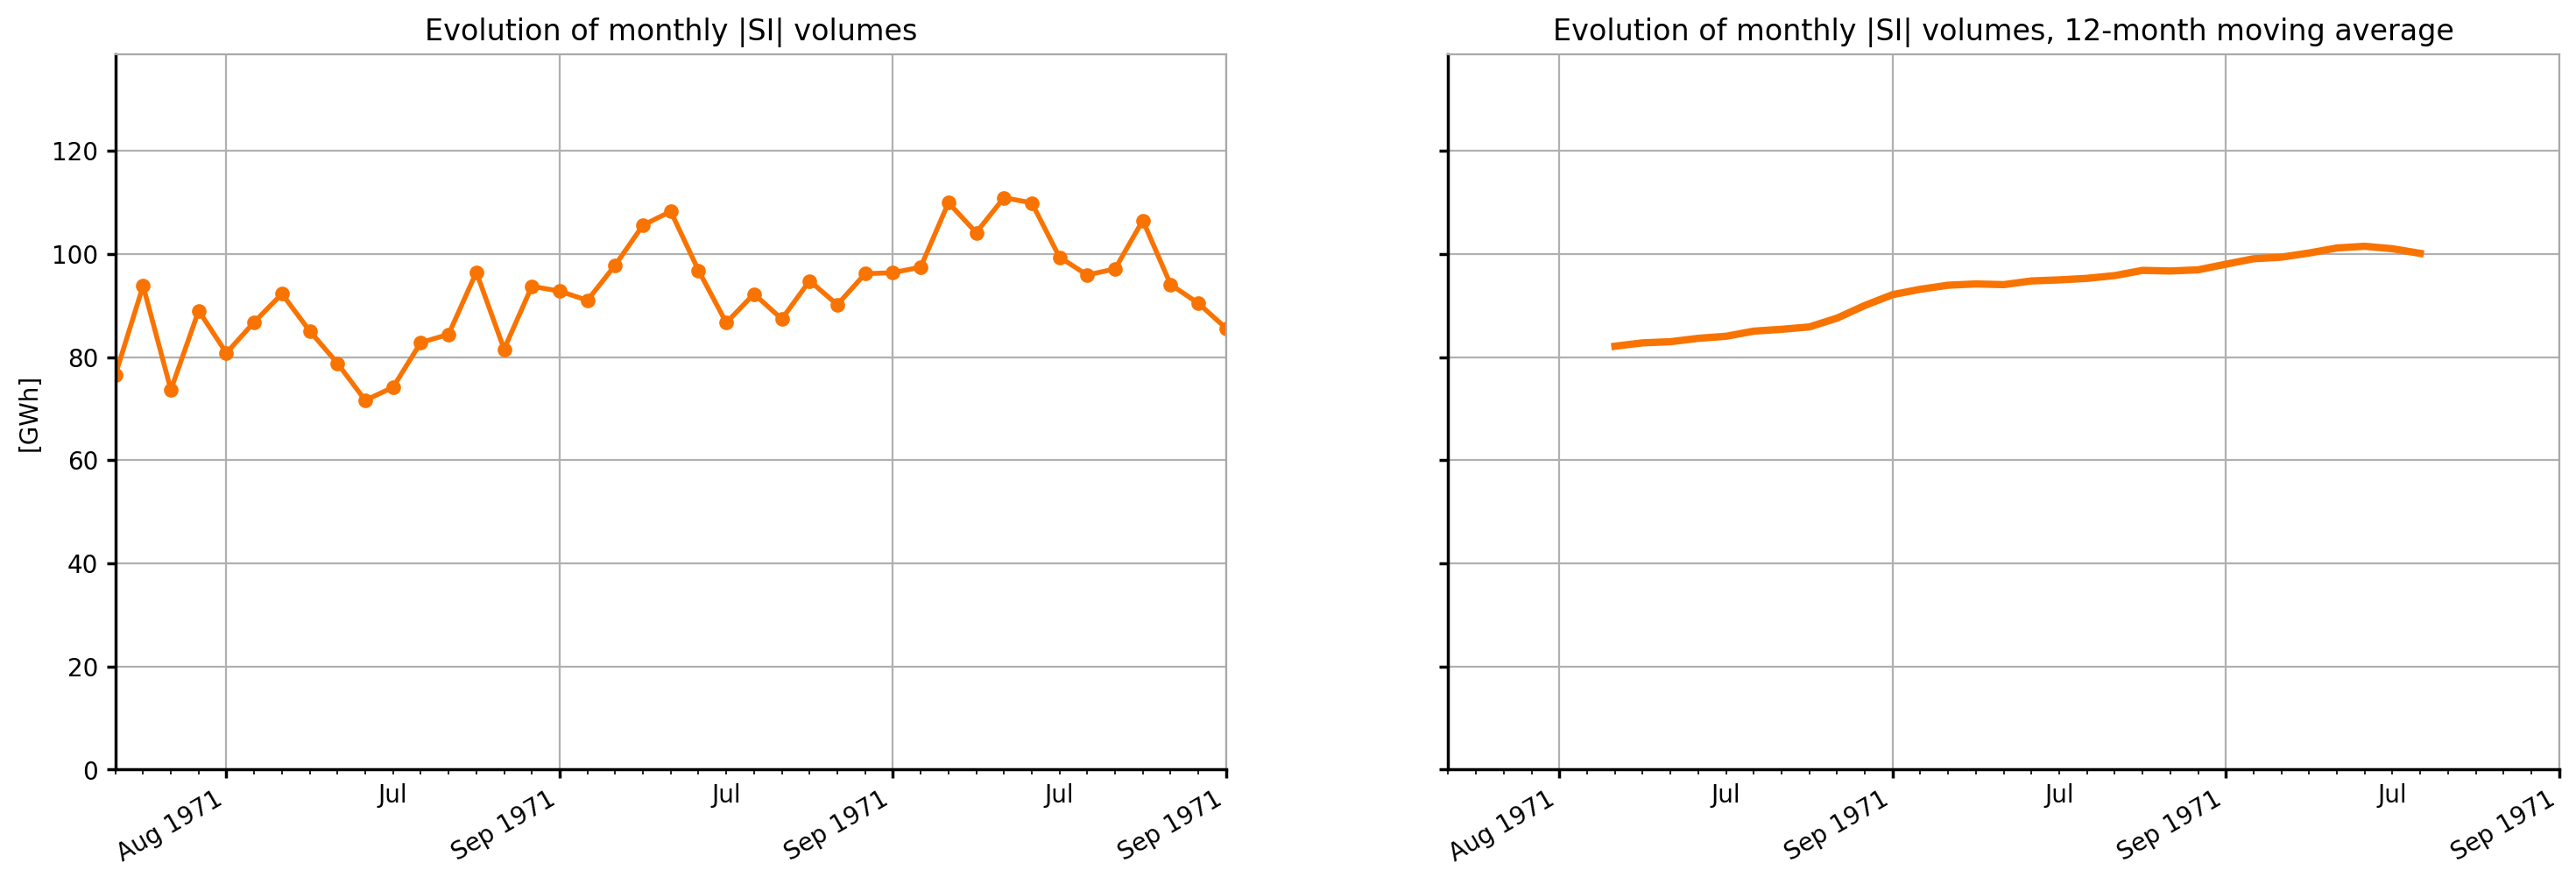

In [68]:
if not use_only_2022:
    agg_month = (
        si
        .groupby(by=["year", "month"])["si_mw"]
        .apply(calculate_imbalance_volume, how="sum")
    )

    agg_month.index = pd.date_range(
        start=pd.Timestamp(f"{agg_month.index[0][0]}-{agg_month.index[0][1]}") - pd.DateOffset(months=0),
        end=pd.Timestamp(f"{agg_month.index[-1][0]}-{agg_month.index[-1][1]}") + pd.DateOffset(months=0),
        freq="1MS"
    )

    rolling_window = 12

    fig, ax = plt.subplots(1, 2, figsize=[18, 6], dpi=DPI, sharex=True, sharey=True)
    agg_month.plot(ax=ax[0],
                   ylabel="[GWh]",
                   c=ELIA_ORANGE,
                   linewidth=2,
                   title=f"Evolution of monthly |SI| volumes")
    agg_month.plot(ax=ax[0],
                   style=".",
                   color=ELIA_ORANGE,
                   markersize=10)

    agg_month.rolling(rolling_window, center=True).mean().plot(ax=ax[1],
                                                               ylabel="[GWh]",
                                                               c=ELIA_ORANGE,
                                                               linewidth=3,
                                                               title=f"Evolution of monthly |SI| volumes, {rolling_window}-month moving average")
    plt.ylim(0, 1.25 * agg_month.max())
    my_plots.despine(ax[0], grid=True)
    my_plots.despine(ax[1], grid=True)
    ax[0].grid()
    ax[1].grid()

    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    fig.autofmt_xdate()

    plt.show()

if output:
     fig.savefig("/Users/tomasurdiales/Desktop/fig3.png", dpi=300)

#### Std over time

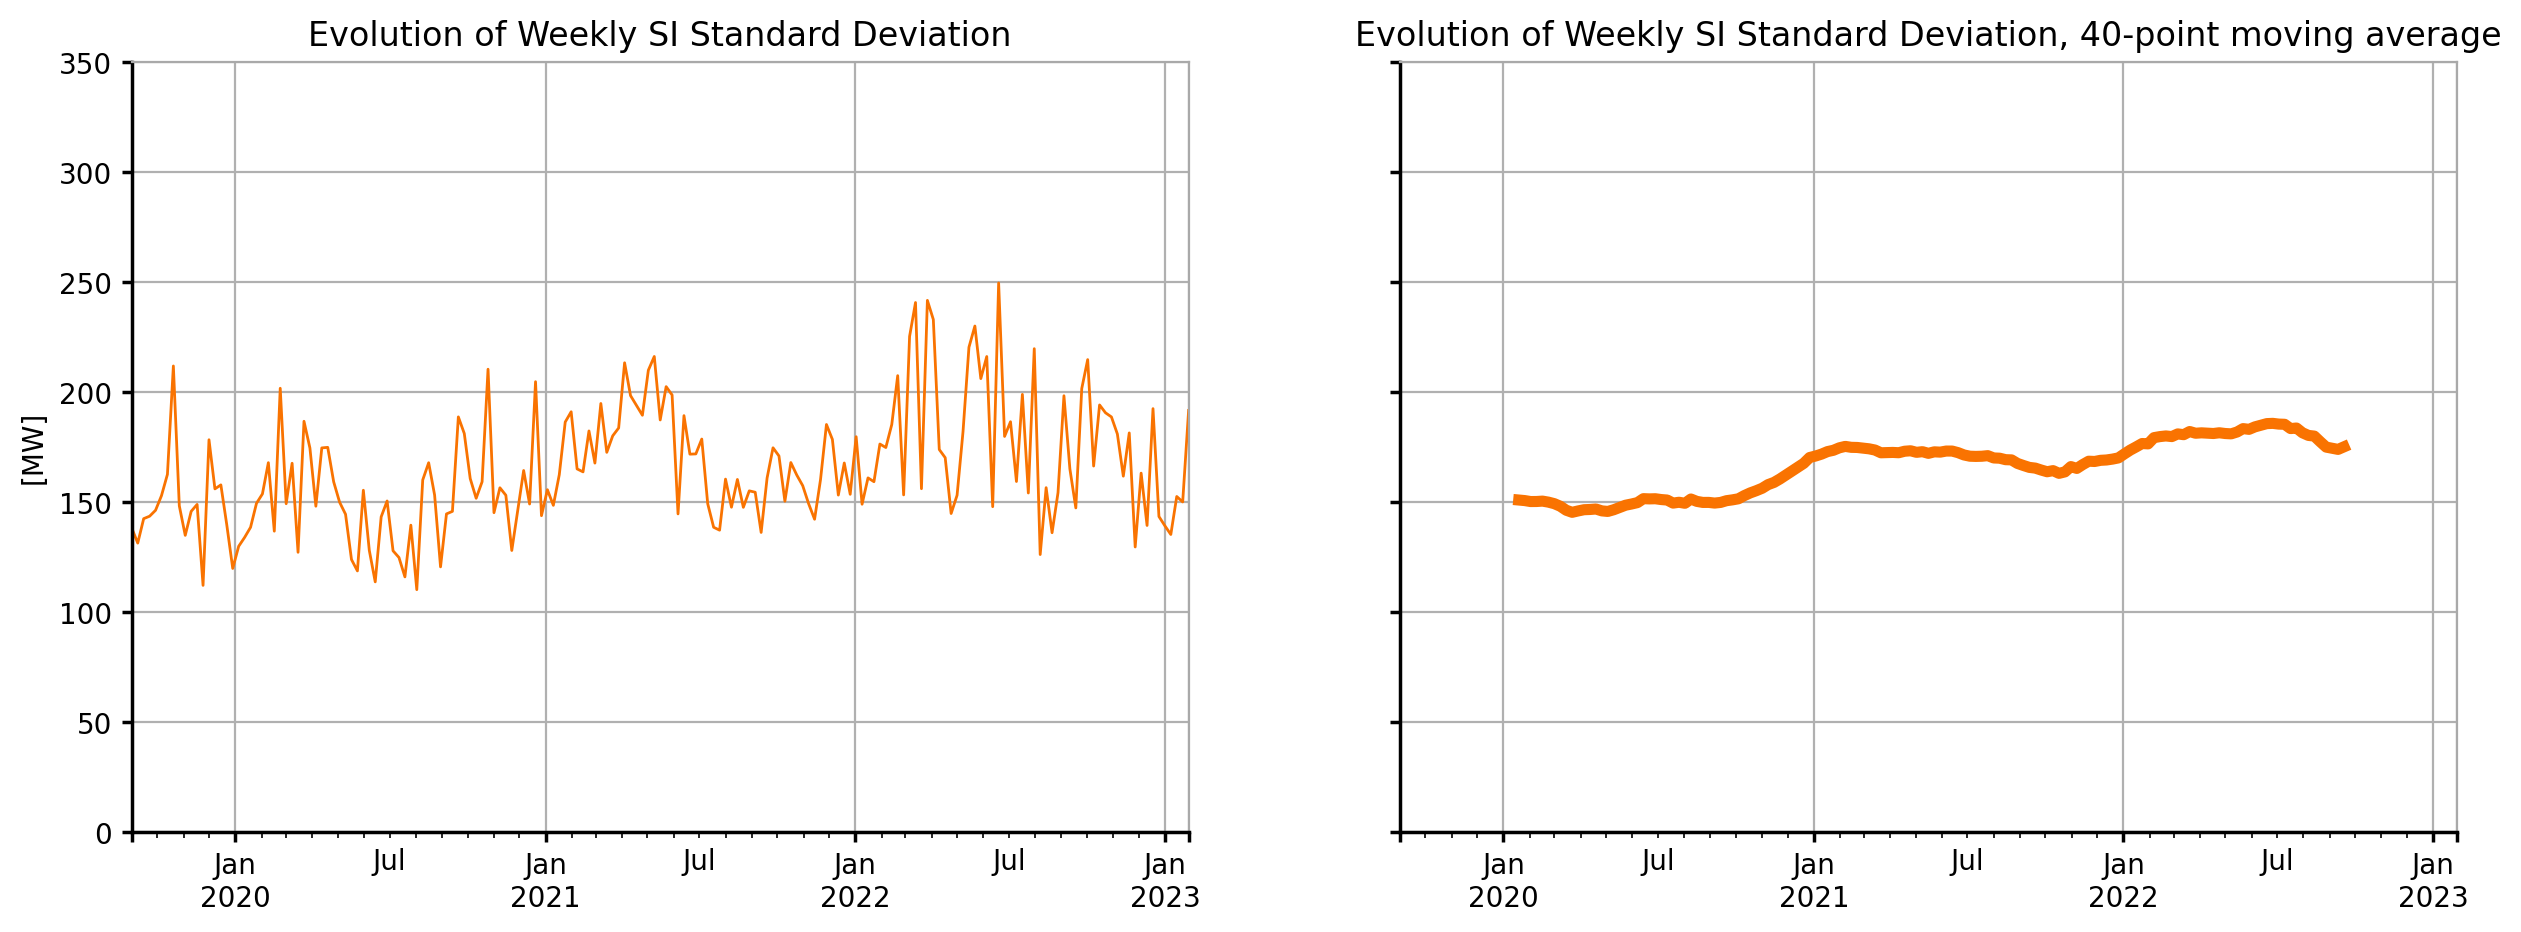

In [15]:
if not use_only_2022:
    rolling_window1, rolling_window2 = 1, 40
    fig, ax = plt.subplots(1,2, figsize = [15,5], dpi=DPI, sharex=True, sharey=True)
    si.groupby(pd.Grouper(freq='7D'))["si_mw"].std().rolling(window=rolling_window1, center=True).mean()\
        .plot(ax=ax[0], color=ELIA_ORANGE, linewidth=1)
    si.groupby(pd.Grouper(freq='7D'))["si_mw"].std().rolling(window=rolling_window2, center=True).mean()\
        .plot(ax=ax[1], color=ELIA_ORANGE, linewidth=4)
    plt.ylim(0,350)
    ax[0].set_title(f"Evolution of Weekly SI Standard Deviation")
    ax[1].set_title(f"Evolution of Weekly SI Standard Deviation, {rolling_window2}-point moving average")
    ax[0].set_ylabel("[MW]"); ax[0].set_xlabel(""); ax[1].set_xlabel("")
    my_plots.despine(ax[0], grid=True); my_plots.despine(ax[1], grid=True)
    ax[0].grid(); ax[1].grid()
    plt.show()

    if output:
     fig.savefig("figures/fig4.png", dpi=300)

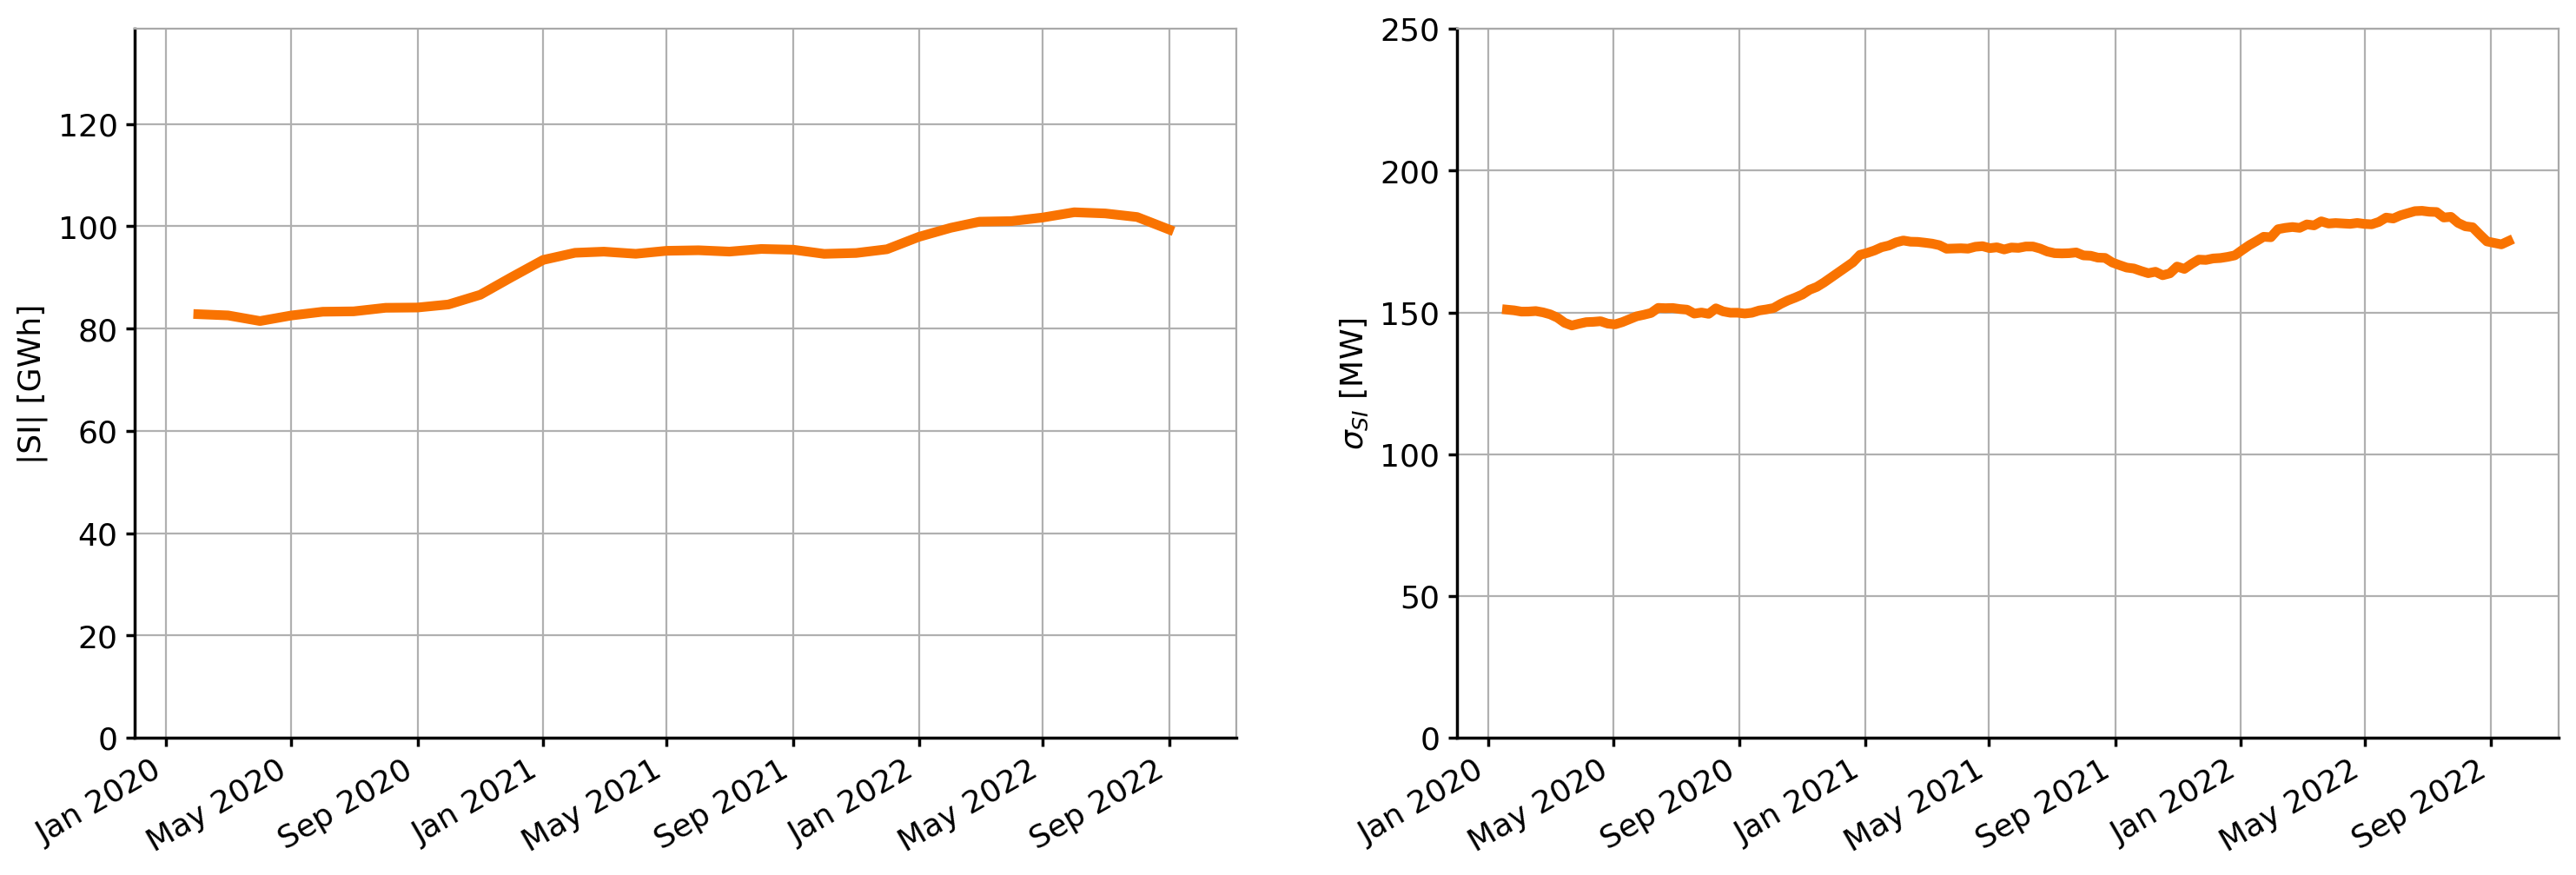

In [27]:
if not use_only_2022:
    agg_month = (
        si
        .groupby(by=["year", "month"])["si_mw"]
        .apply(calculate_imbalance_volume, how="sum")
    )

    agg_month.index = pd.date_range(
        start=pd.Timestamp(f"{agg_month.index[0][0]}-{agg_month.index[0][1]}") - pd.DateOffset(months=0),
        end=pd.Timestamp(f"{agg_month.index[-1][0]}-{agg_month.index[-1][1]}") + pd.DateOffset(months=0),
        freq="1MS"
    )

    rolling_window1, rolling_window2 = 10, 40

    fig, ax = plt.subplots(1, 2, figsize=[18, 6], dpi=DPI, sharex=True, sharey=False)

    ax[0].plot(agg_month.rolling(rolling_window1, center=True).mean(),
        c=ELIA_ORANGE,
        linewidth=4)
    ax[0].set_ylabel("|SI| [GWh]", fontsize=13)
    ax[0].set_ylim(0, 1.25 * agg_month.max())
    my_plots.despine(ax[0], grid=True)
    ax[0].grid()
    # plt.xticks(fontsize=13); plt.yticks(fontsize=13)

    ax[0].xaxis.set_major_locator(mdates.MonthLocator(list(np.arange(1, 12, 4))))
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    fig.autofmt_xdate()

    ax[1].plot(si.groupby(pd.Grouper(freq='7D'))["si_mw"].std().rolling(window=rolling_window2, center=True).mean(),
        c=ELIA_ORANGE,
        linewidth=4)
    ax[1].set_ylabel("$\sigma_{SI}$ [MW]", fontsize=13)
    ax[1].set_ylim(0,250)
    my_plots.despine(ax[1], grid=True)
    ax[1].grid()
    # plt.xticks(fontsize=13); plt.yticks(fontsize=13)

    # We change the fontsize of minor ticks label 
    ax[0].tick_params(axis='both', which='major', labelsize=13)
    ax[0].tick_params(axis='both', which='minor', labelsize=13)
    ax[1].tick_params(axis='both', which='major', labelsize=13)
    ax[1].tick_params(axis='both', which='minor', labelsize=13)

    plt.show()

if output:
     fig.savefig("/Users/tomasurdiales/Desktop/fig3.png", dpi=300)

#### Hourly distribution

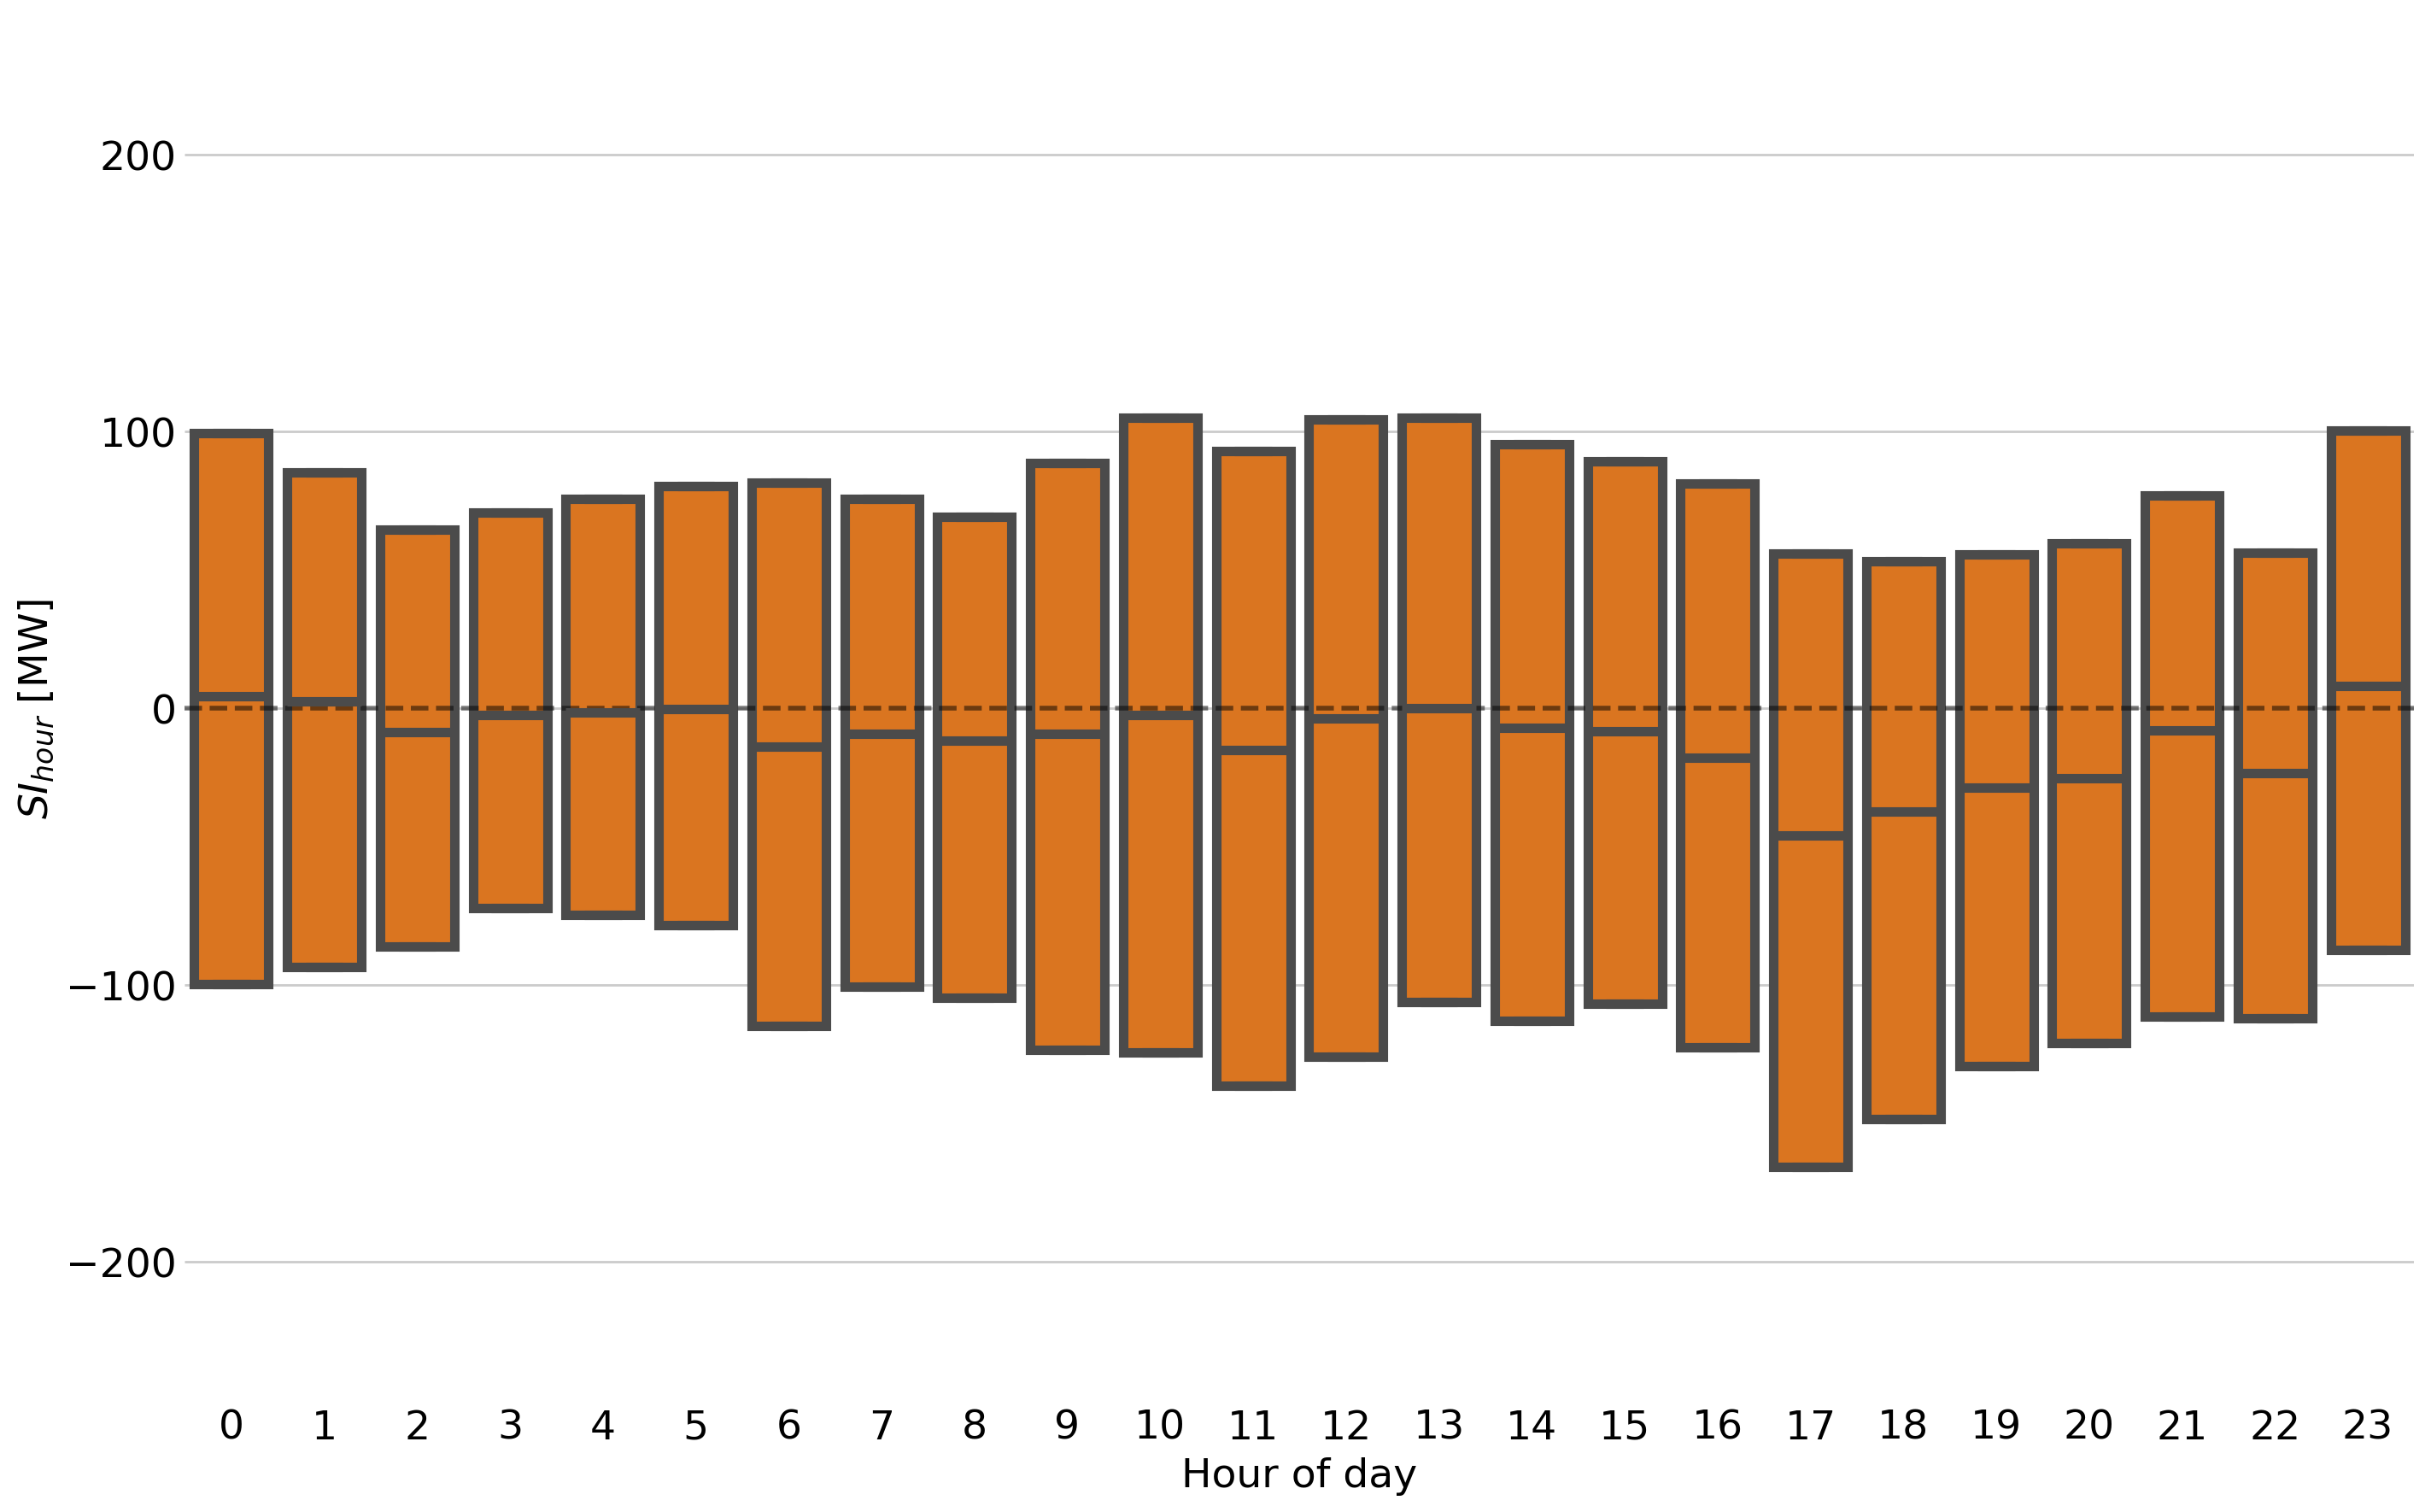

In [28]:
with plt.style.context("fivethirtyeight"):
     fig, ax = plt.subplots(figsize=(15, 10), dpi=DPI)
     sns.boxplot(data=si, x="hour", y="si_mw", fliersize=0, whis=0, color=ELIA_ORANGE)
     ax.tick_params(axis="both", which="major", labelsize=17)
     ax.tick_params(axis="both", which="minor", labelsize=17)
     ax.set_xlabel("Hour of day", fontsize=17)
     ax.set_ylabel("$SI_{hour}$ [MW]", fontsize=17)
     fig.set(facecolor="#FFFFFF")
     ax.set(facecolor="#FFFFFF")
     ax.spines["left"].set_visible(False)
     ax.spines["right"].set_visible(False)
     ax.spines["top"].set_visible(False)
     ax.spines["bottom"].set_visible(False)

     # ax.set_title("Hourly SI Distribution")
     ax.axhline(0, color="black", ls="--", linewidth=2, alpha=0.5)
     plt.ylim([-250, 250])

if output:
     fig.savefig("/Users/tomasurdiales/Desktop/fig5.png", dpi=300)

This plot seems to reflect higher negative imbalance at times of high load: in the afternoon (16:00-21:00), and somewhat during the morning too (6:00-9:00).

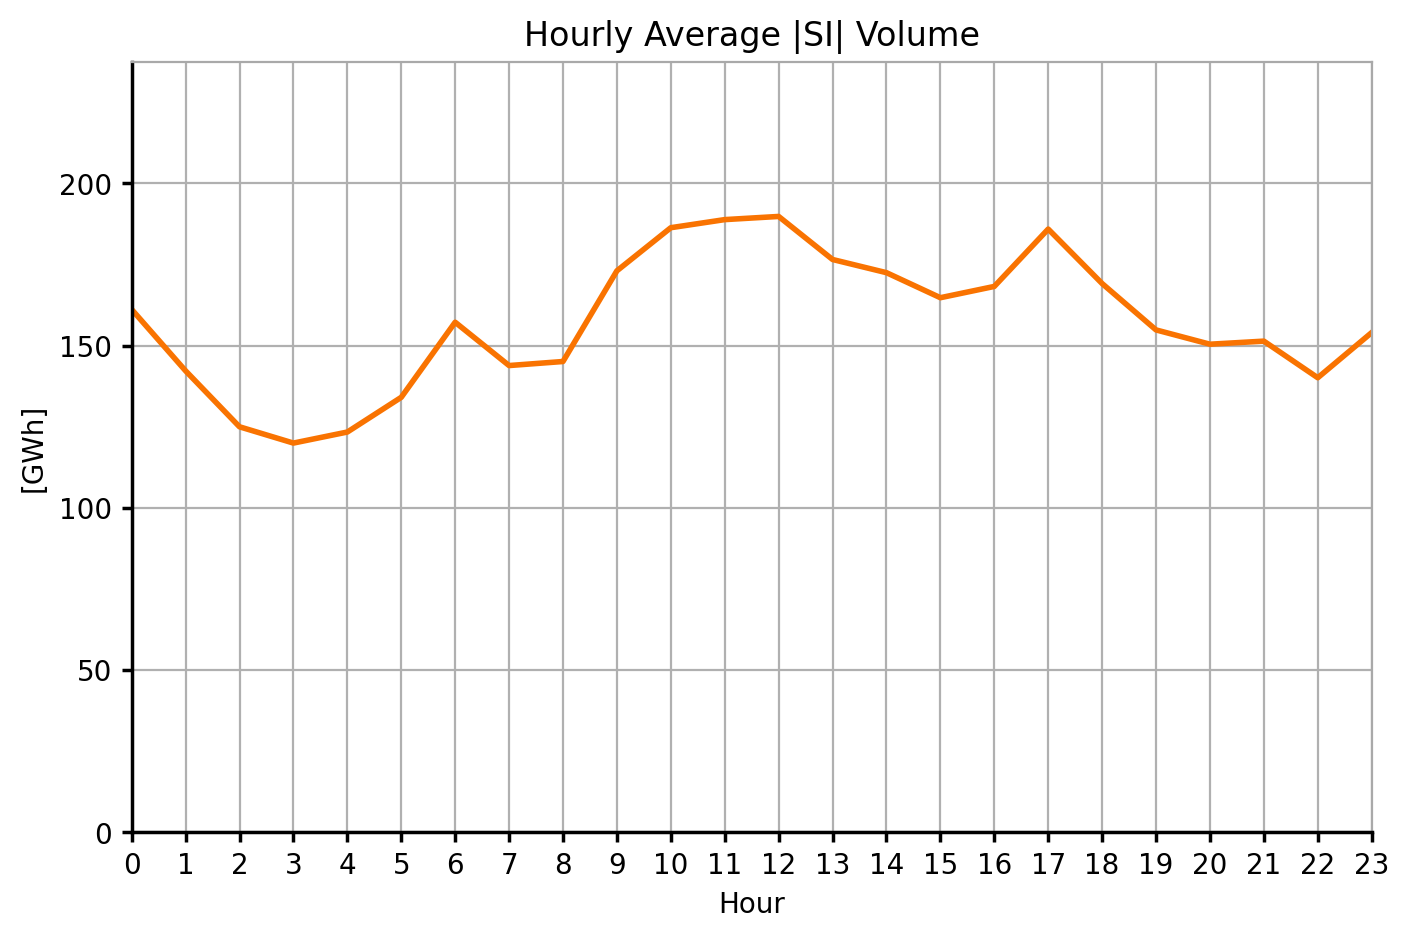

In [72]:
agg_hour = (
    si
    .groupby(by=["hour"])["si_mw"]
    .apply(calculate_imbalance_volume, how="sum")
)

fig, ax = plt.subplots(figsize=[8,5], dpi=DPI)
agg_hour.plot(ax=ax, ylabel="[GWh]", xlabel="Hour",
              c=ELIA_ORANGE,
              linewidth=2,
              title=f"Hourly Average |SI| Volume")
my_plots.despine(ax, grid=True)
plt.ylim(0, 1.25 * agg_hour.max())
plt.xlim(0, 23)
plt.xticks(range(24))
plt.grid()
plt.show()

# if output:
    #  fig.savefig("figures/fig6.png", dpi=300)

#### ACF

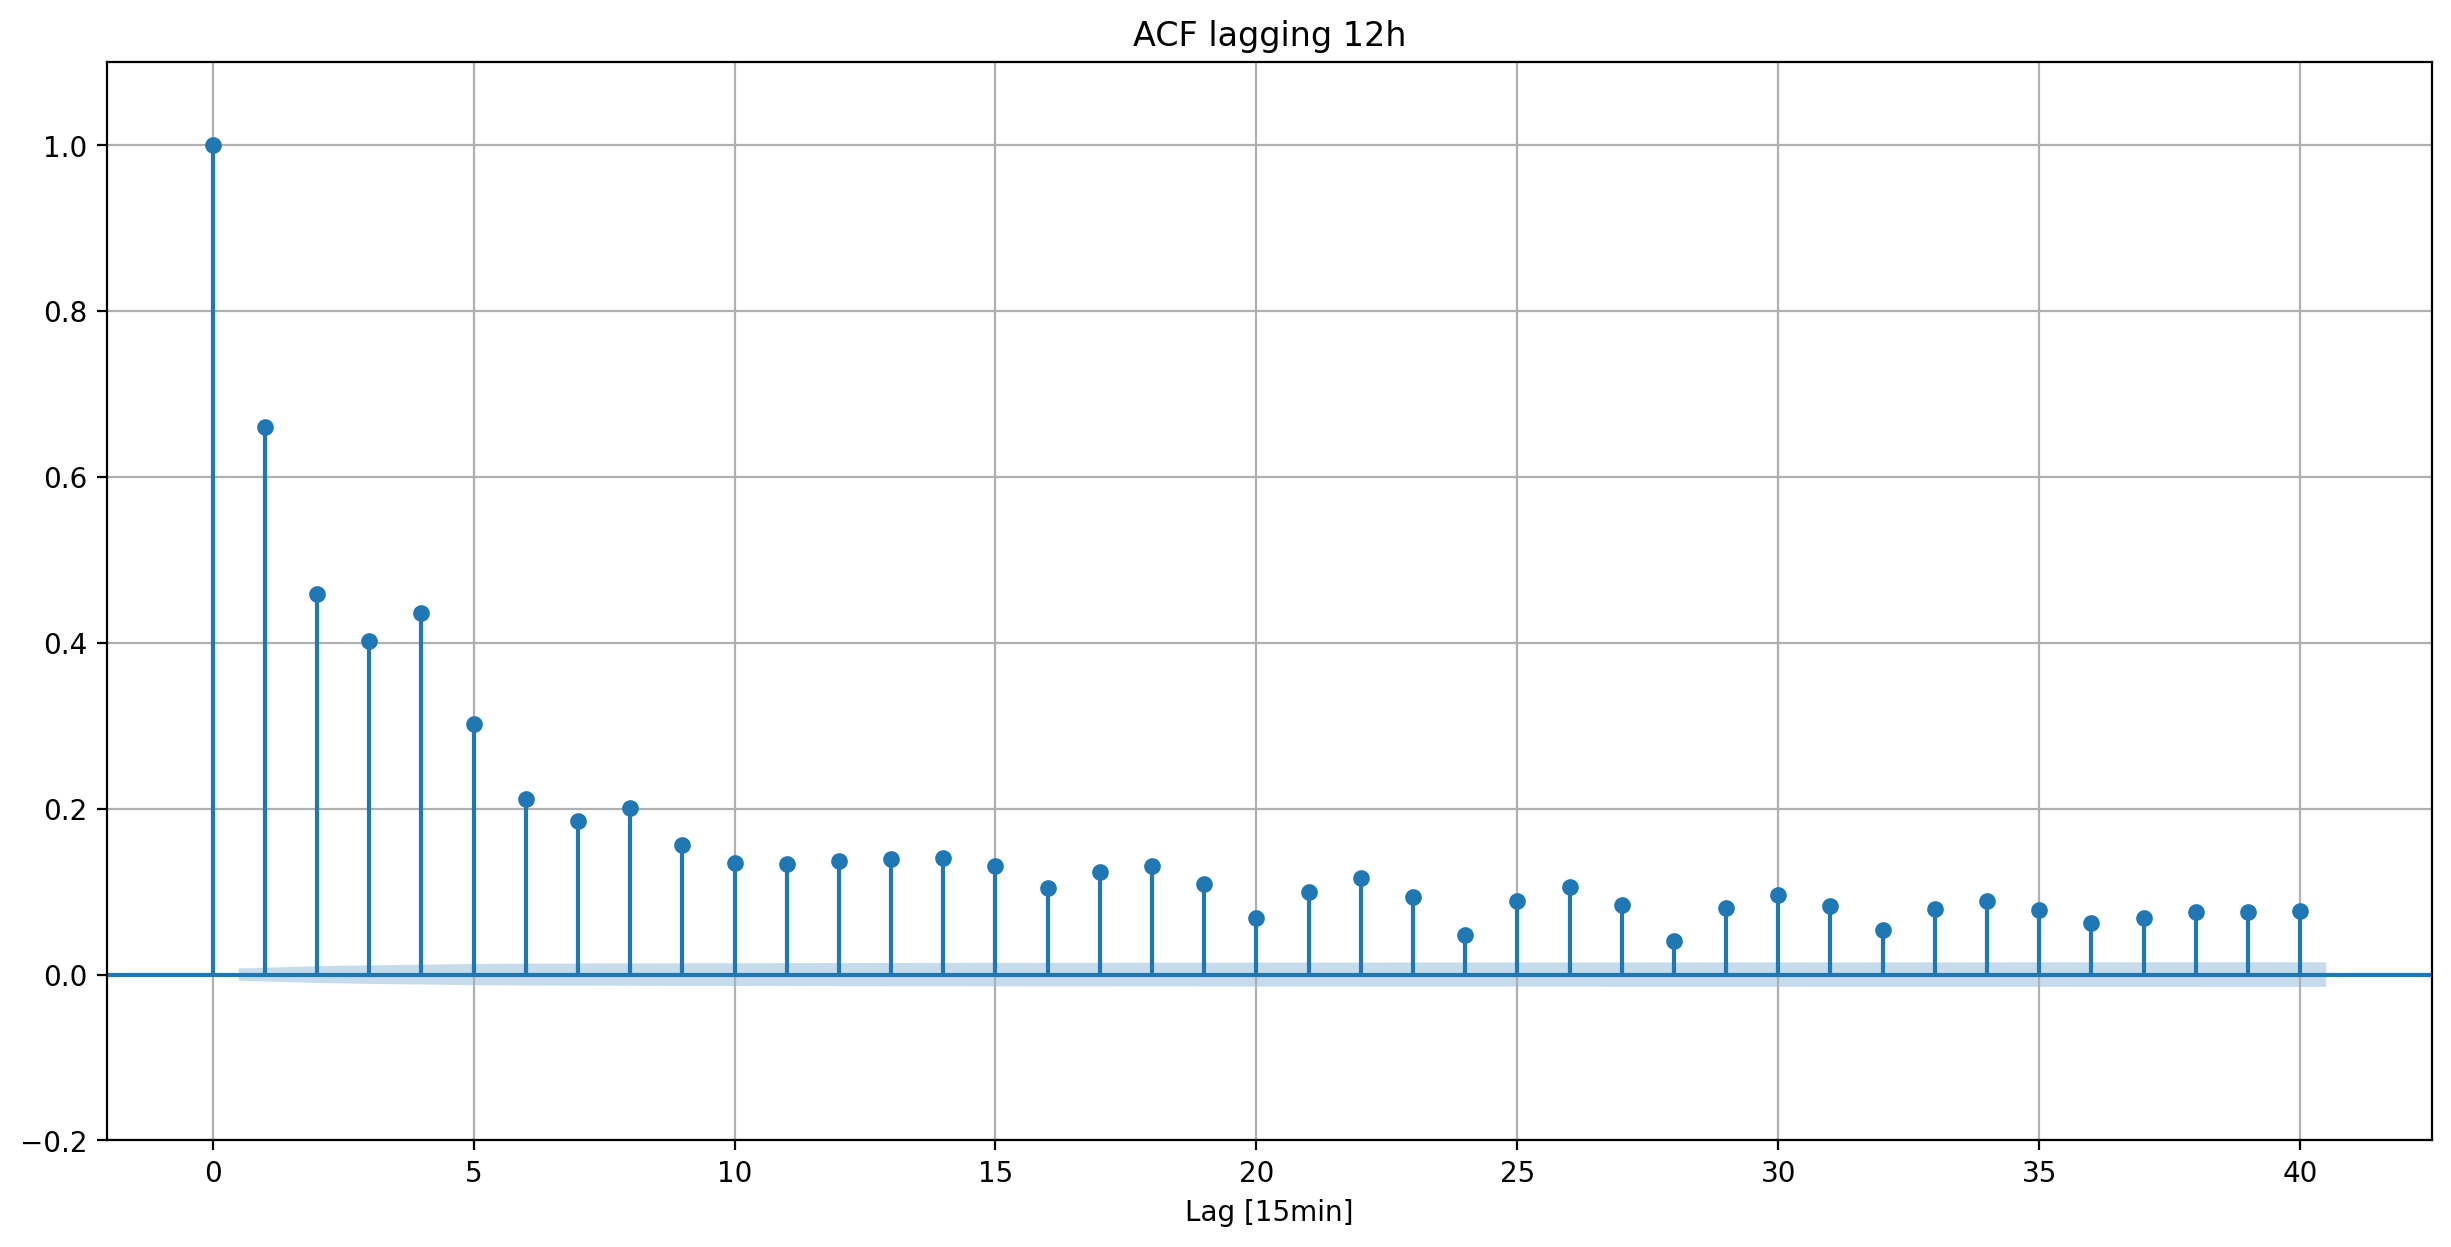

In [14]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=DPI)
sm.graphics.tsa.plot_acf(si["si_mw"], alpha=.05, lags=4*10,
                         ax=ax, title="ACF lagging 12h")
plt.ylim([-0.2,1.1])
plt.xlabel('Lag [15min]')
plt.grid()
plt.show()

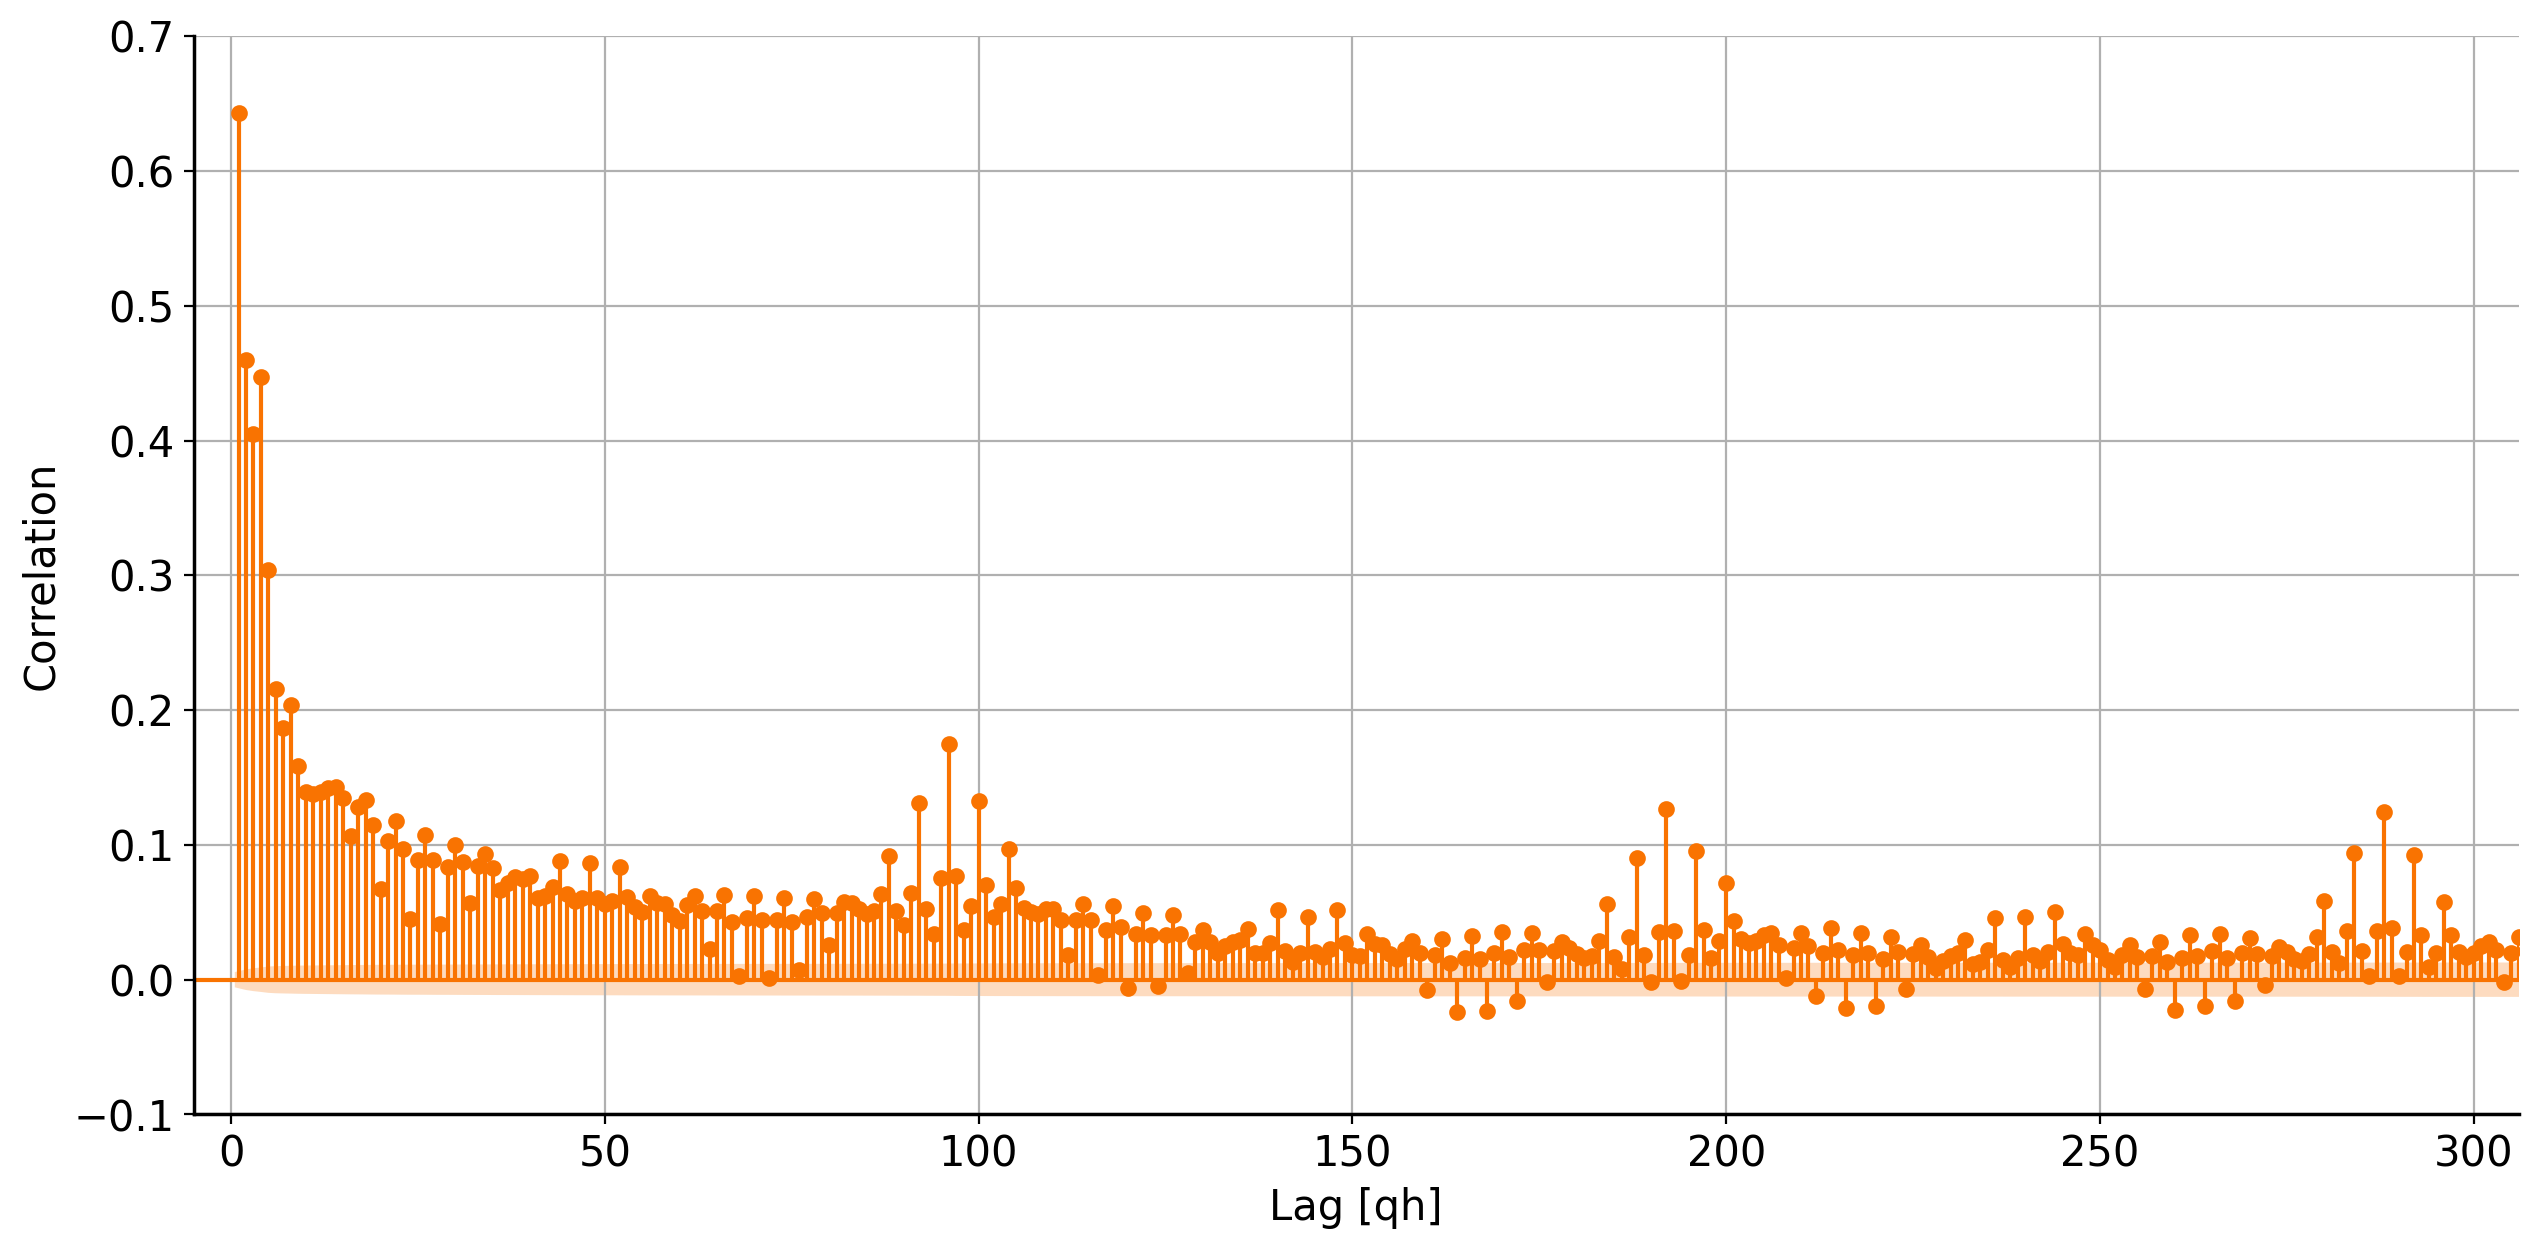

In [9]:
from matplotlib.collections import PolyCollection

fig, ax = plt.subplots(figsize=(15, 7), dpi=DPI)
sm.graphics.tsa.plot_acf(si["si_mw"], alpha=.05, lags=4*24*3.5,
                         zero=False,
                         ax=ax,
                         color=ELIA_ORANGE, vlines_kwargs={"colors": ELIA_ORANGE})
plt.ylim(-0.1, 0.7)
plt.xlim(-5, 4*24*3.5-30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.xlabel("Lag [qh]", fontsize=15)
ax.set_title("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(1.25)
ax.spines["bottom"].set_linewidth(1.25)
for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor(ELIA_ORANGE)
plt.grid()
plt.show()

if output:
     fig.savefig("/Users/tomasurdiales/Desktop/fig9.png", dpi=300)

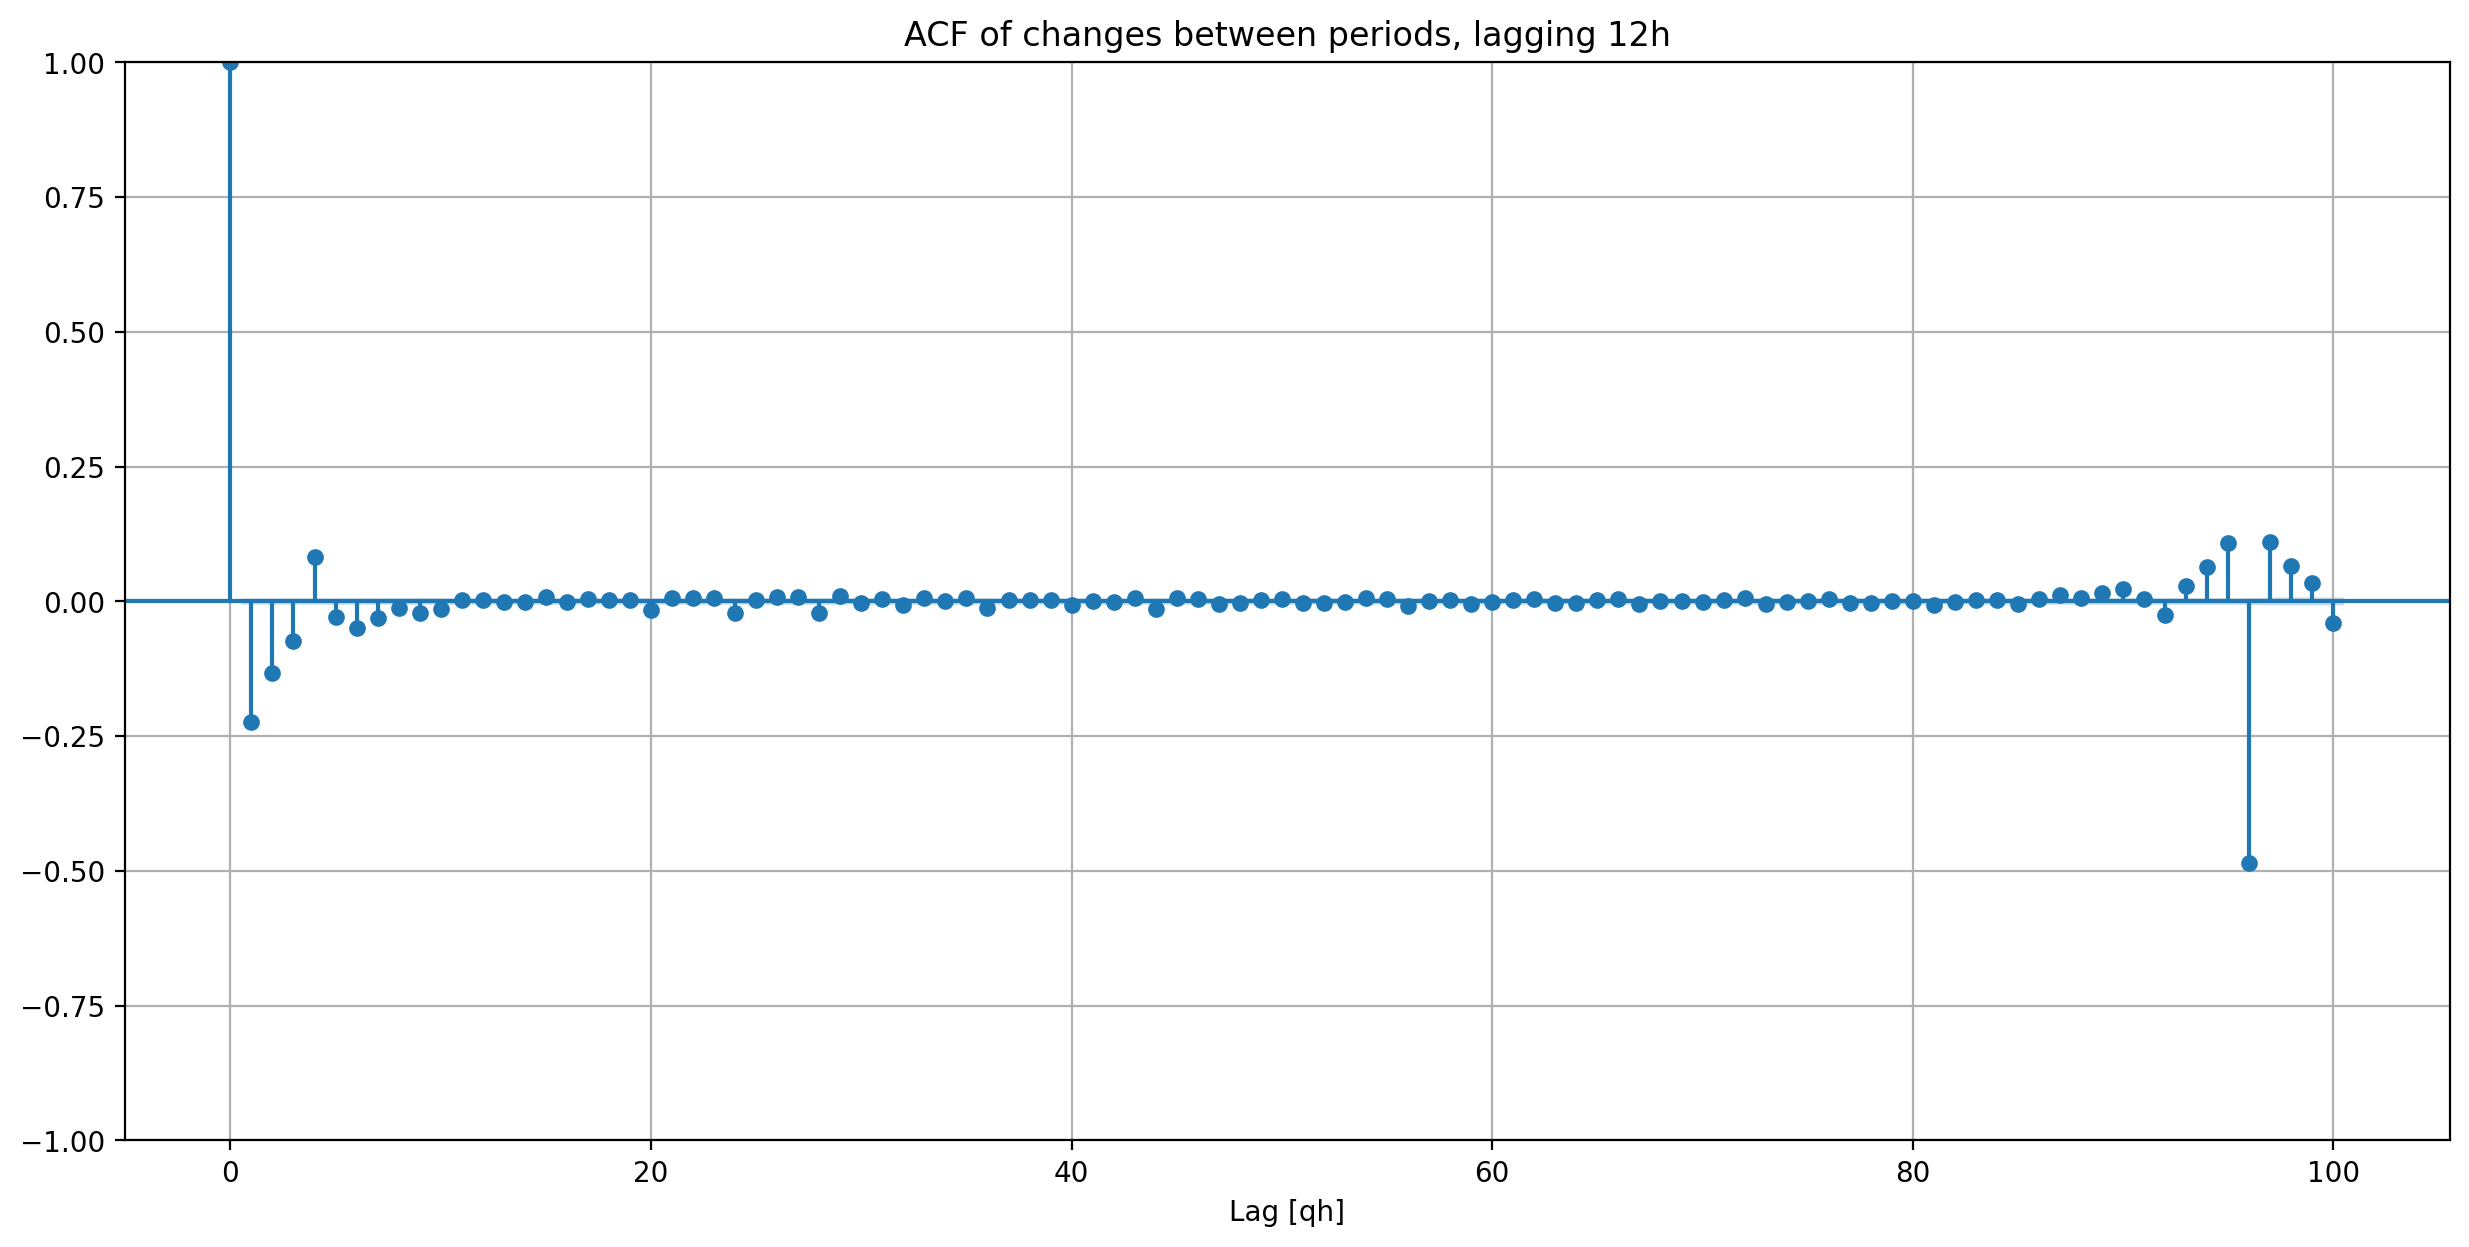

In [17]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=DPI)
sm.graphics.tsa.plot_acf(si["si_mw"].diff().diff(4*24).dropna(), alpha=.05, lags=100,
                         ax=ax, title="ACF of changes between periods, lagging 12h")
# plt.ylim(-0.3, 1.1)
plt.xlabel('Lag [qh]')
plt.grid()
plt.show()

#### PACF

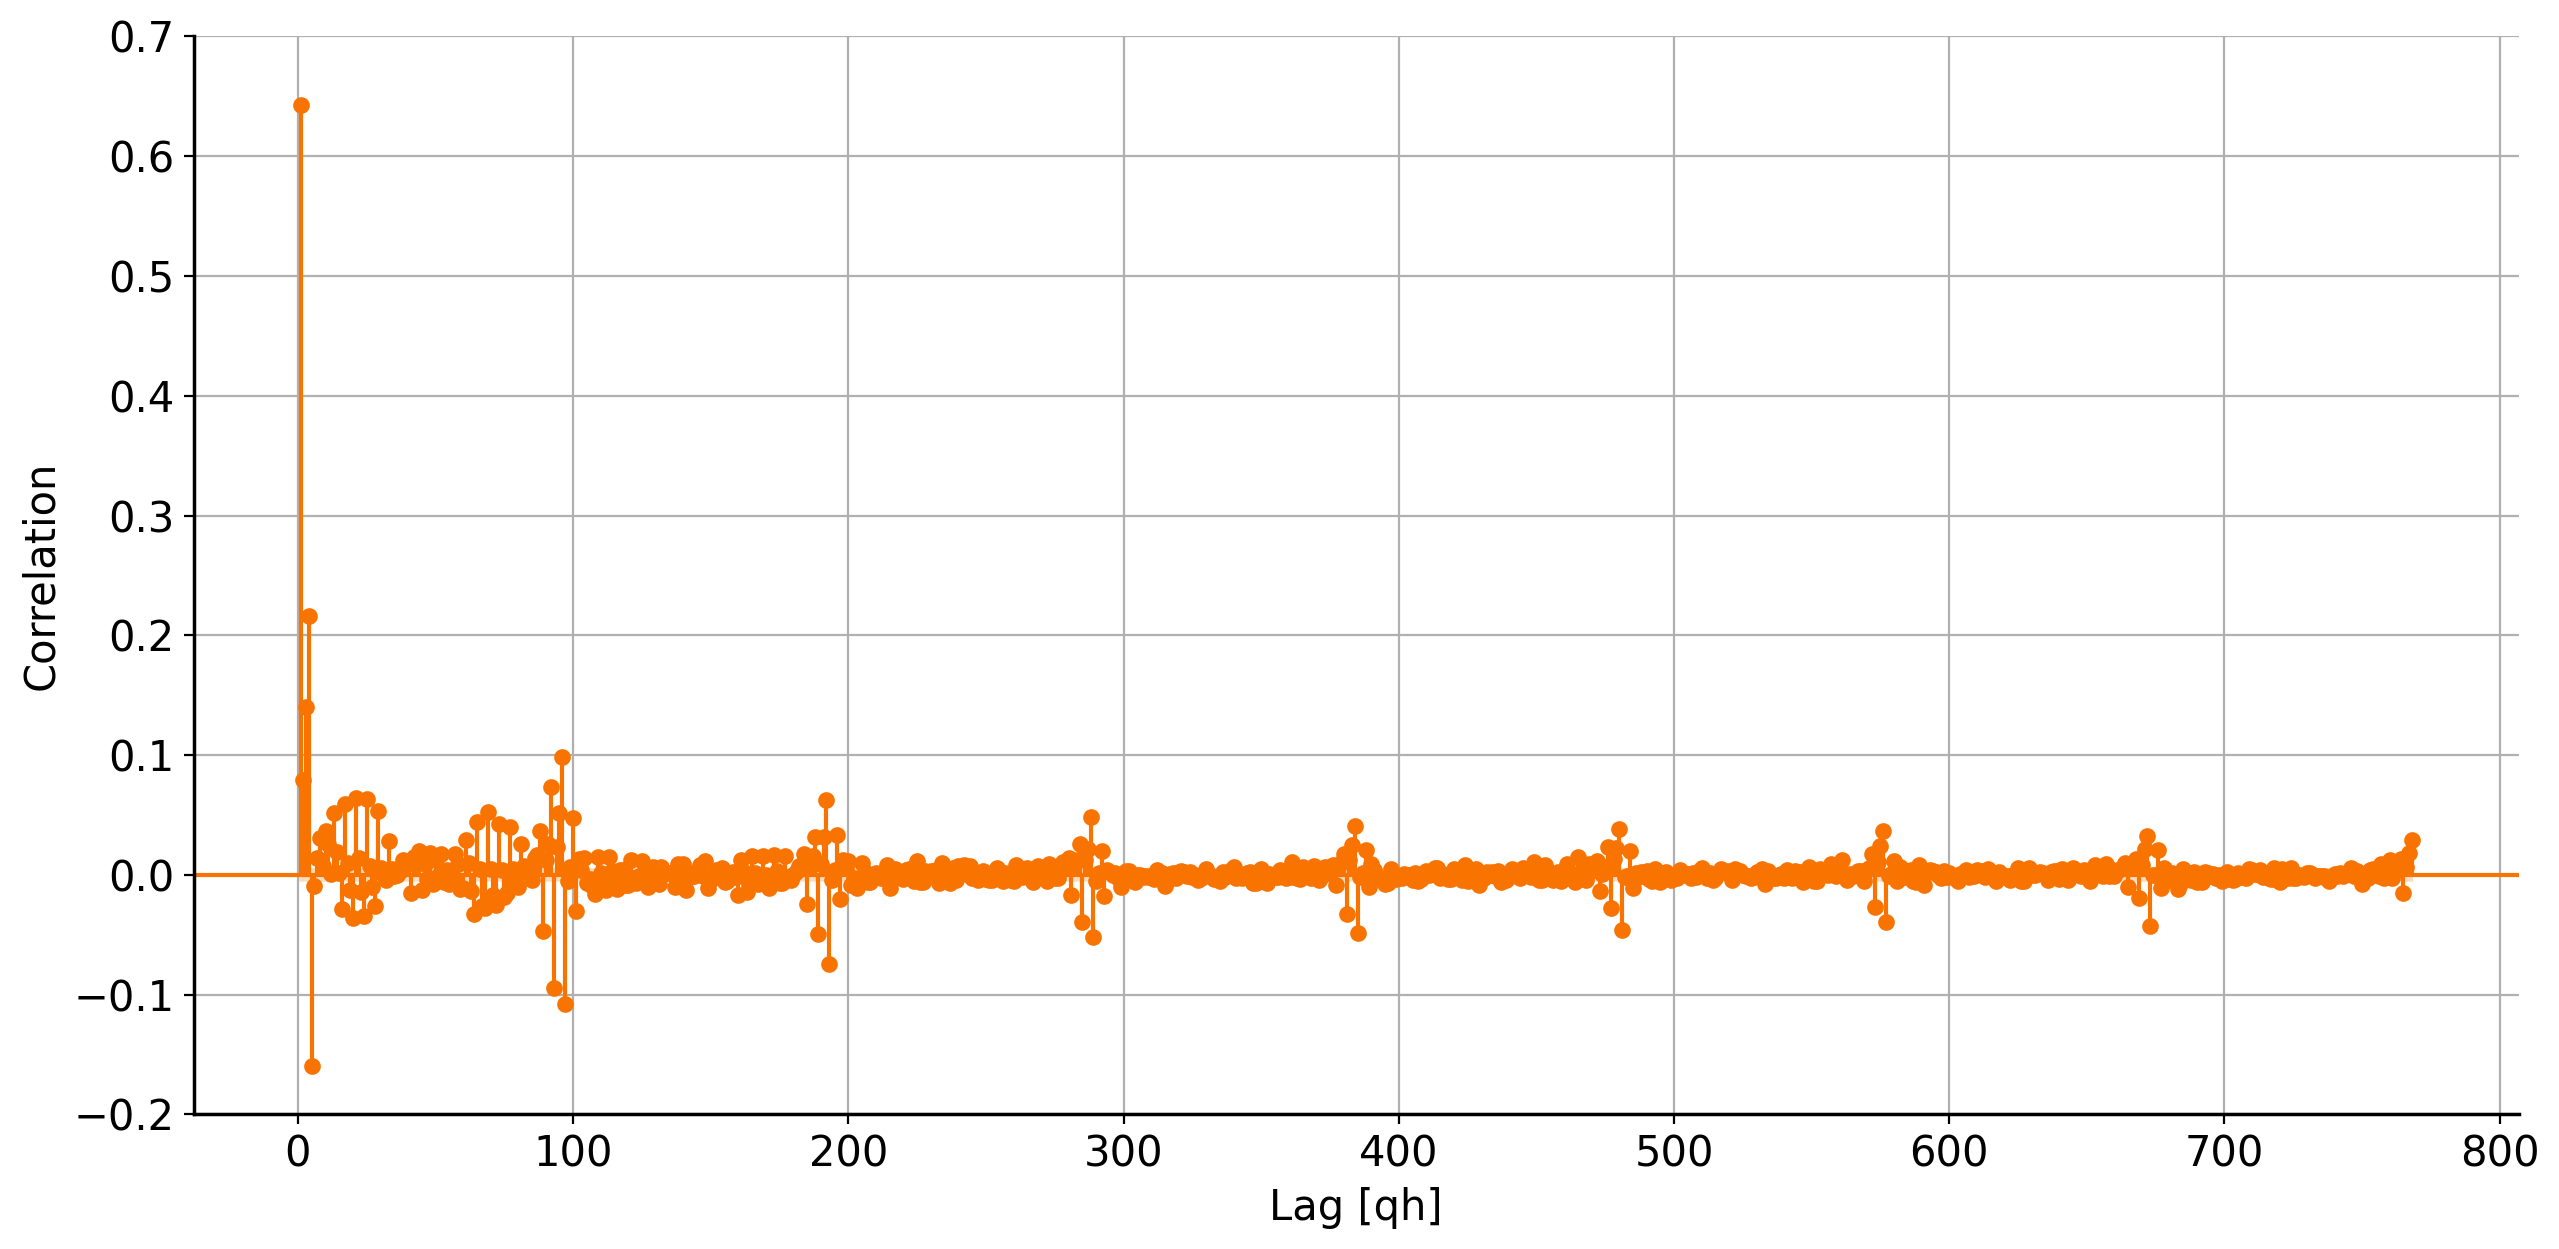

In [43]:
from matplotlib.collections import PolyCollection

fig, ax = plt.subplots(figsize=(15, 7), dpi=DPI)
sm.graphics.tsa.plot_pacf(si["si_mw"], alpha=.05, lags=4*24*8,
                         zero=False,
                         ax=ax,
                         color=ELIA_ORANGE, vlines_kwargs={"colors": ELIA_ORANGE})
plt.ylim(-0.2, 0.7)
# plt.xlim(-5, 4*24*2.5-30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.xlabel("Lag [qh]", fontsize=15)
ax.set_title("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(1.25)
ax.spines["bottom"].set_linewidth(1.25)
for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor(ELIA_ORANGE)
plt.grid()
plt.show()

if output:
     fig.savefig("/Users/tomasurdiales/Desktop/fig10.png", dpi=300)

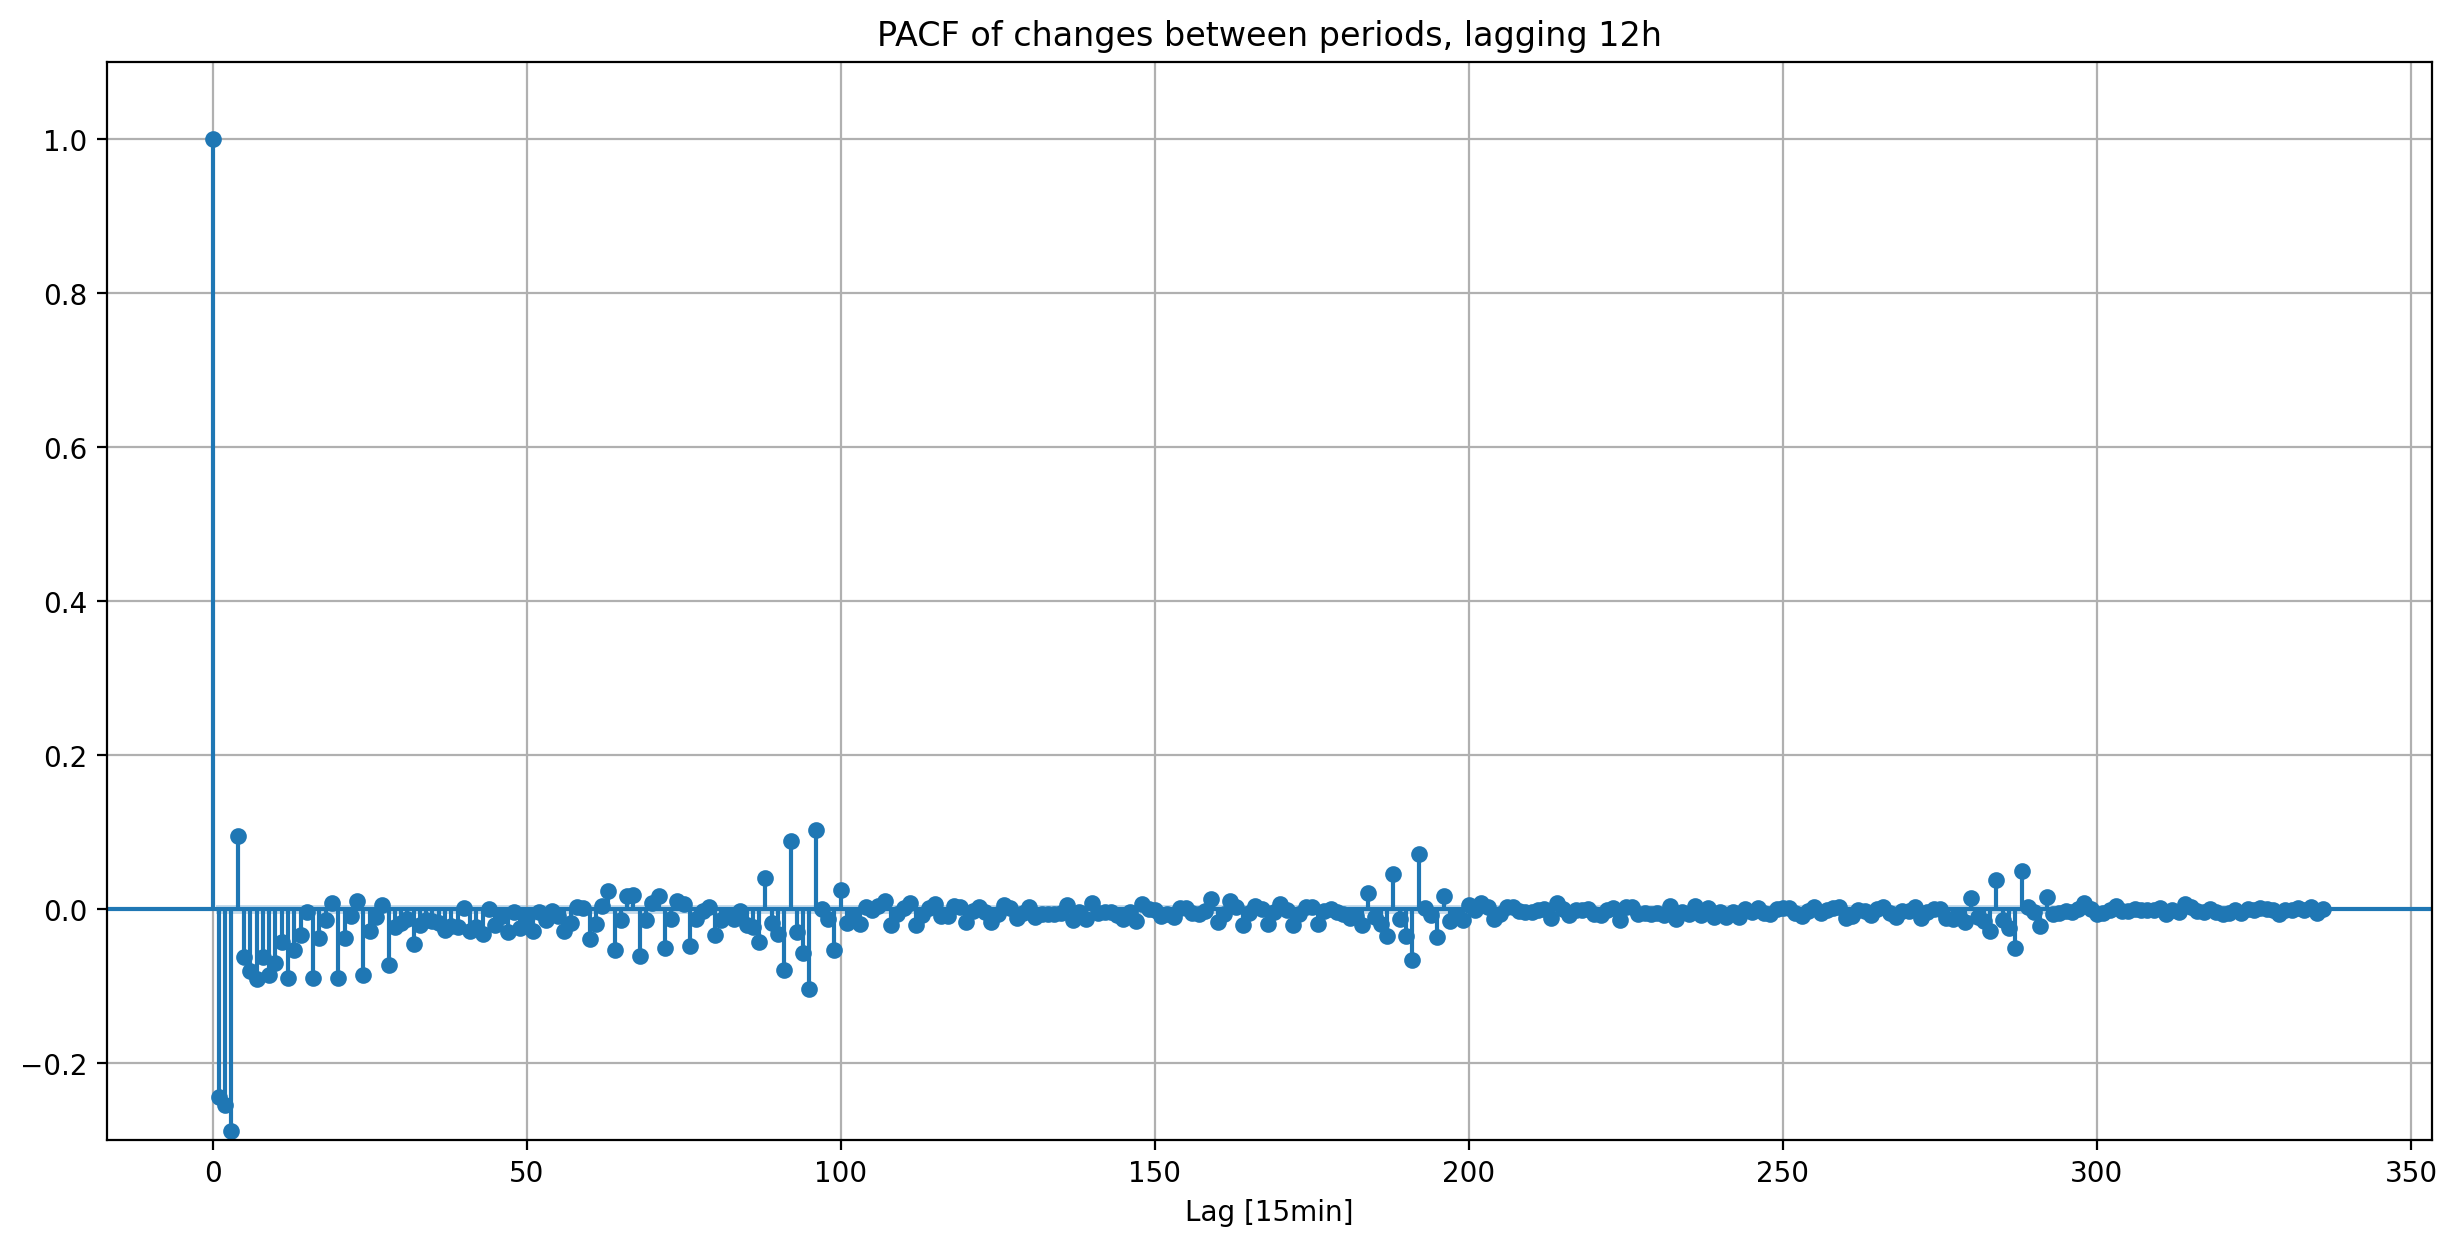

In [73]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=DPI)
sm.graphics.tsa.plot_pacf(si["si_mw"].diff().dropna(), alpha=.05, lags=4*24*3.5, method="ywm", 
                          ax=ax, title="PACF of changes between periods, lagging 12h")
plt.ylim([-0.3,1.1])
plt.xlabel('Lag [15min]')
plt.grid()
plt.show()

#### STL Decomposition

In [20]:
if try_STL:
    decomp = STL(endog=si["si_mw"], period=4, trend=int(4*24*7*4.35), seasonal=int(4*24*7*4.35), robust=True).fit()

    plt.rc('figure', figsize=(16, 12), dpi=DPI)
    decomp.plot()
    plt.show()
    plt.rcdefaults()

---

## Wind Forecasts

In [23]:
wind = df[["wind_id_mw", "wind_rt_mw", "wind_production_forecast_intraday_p10_mw", "wind_production_forecast_intraday_p90_mw"]].copy()
wind = wind.rename(columns={
    "wind_production_forecast_intraday_p10_mw": "p10",
    "wind_production_forecast_intraday_p90_mw": "p90",
    "wind_id_mw": "id_mw",
    "wind_rt_mw": "rt_mw"})

wind = create_datetime_features(wind)

# Filter out 2023 broken data!
wind = wind.query("year<2023")

print("Macro-scale descriptive stats:")
print(wind["rt_mw"].describe(),"\n")

Macro-scale descriptive stats:
count    116928.000000
mean       1230.622559
std        1092.275269
min         -15.419817
25%         289.947418
50%         881.277954
75%        2038.070312
max        4600.660156
Name: rt_mw, dtype: float64 



There are broken values for January 2023!

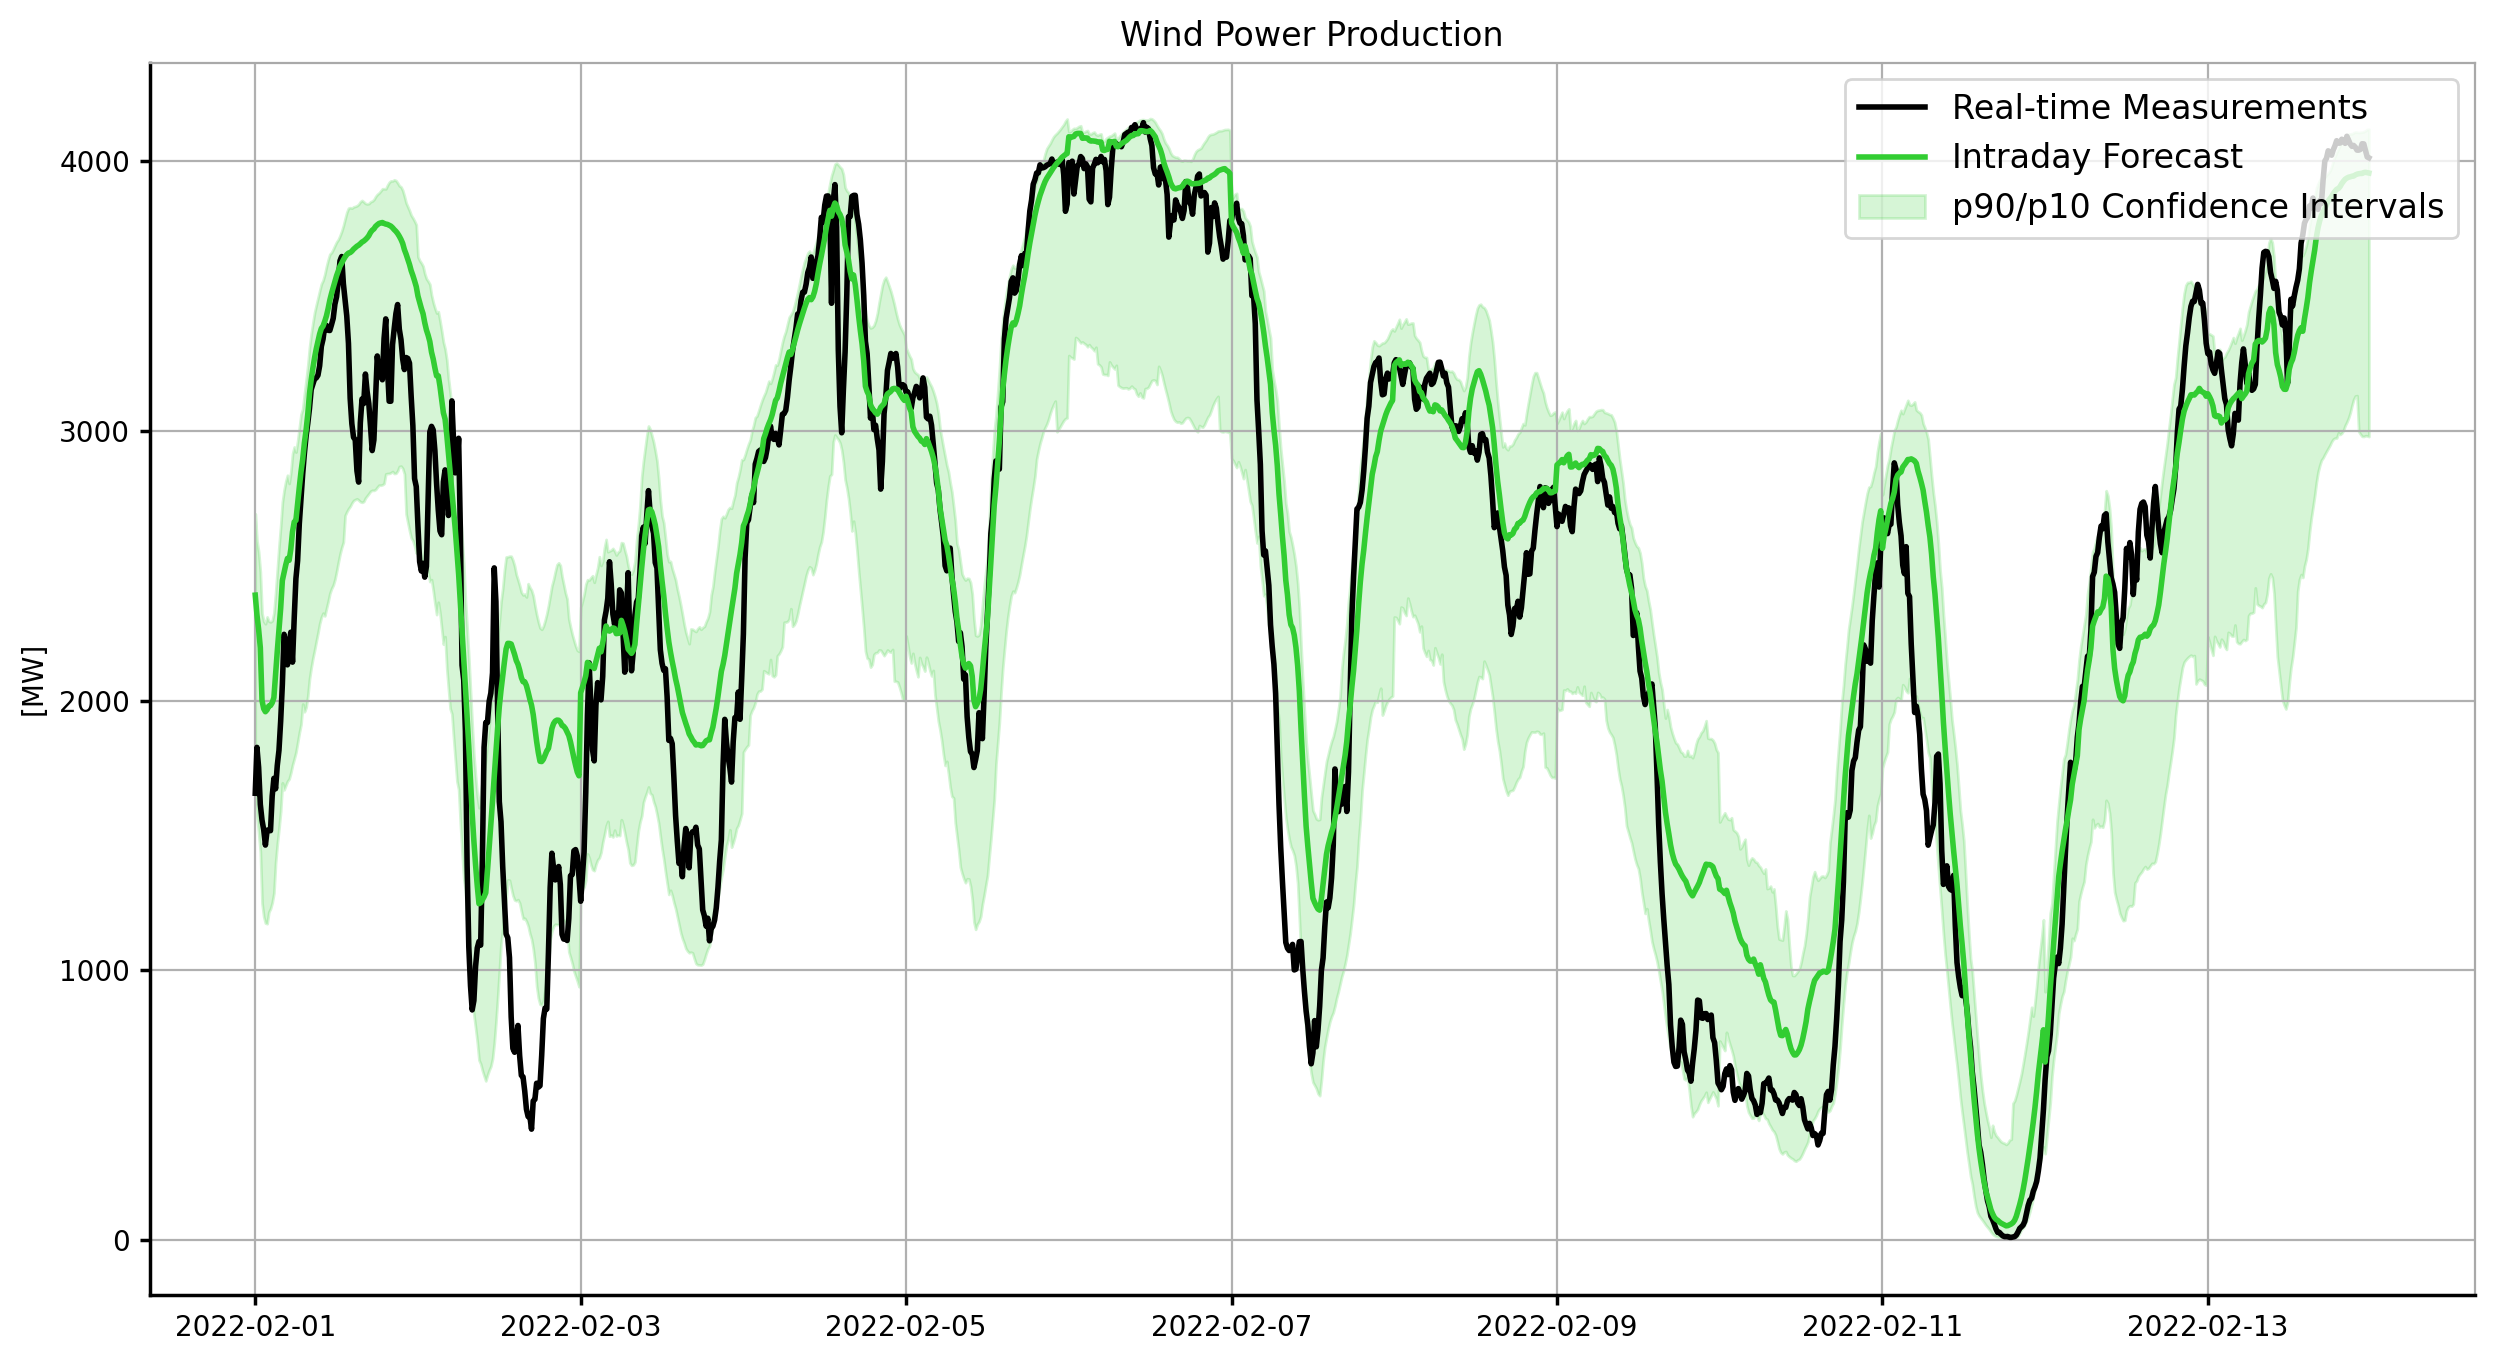

In [24]:
wind_subset = wind.query("year==2022 and month==2 and dayofmonth < 14")

fig, ax = plt.subplots(figsize=[15,8], dpi=DPI)
ax.plot(wind_subset["rt_mw"], linewidth=2, c = "k", label="Real-time Measurements") #! Factor of 4!
ax.plot(wind_subset["id_mw"], linewidth=2, c = "limegreen", label="Intraday Forecast")
ax.fill_between(wind_subset.index, wind_subset["p10"], wind_subset["p90"],
                color="limegreen", alpha=.2, label="p90/p10 Confidence Intervals")
# ax.set_ylim(0,)
ax.set_title("Wind Power Production"); ax.set_ylabel("[MW]")
ax.legend(loc=1, frameon=True, prop={'size': 12})
my_plots.despine(ax=ax, grid=True)
plt.grid(); plt.show()

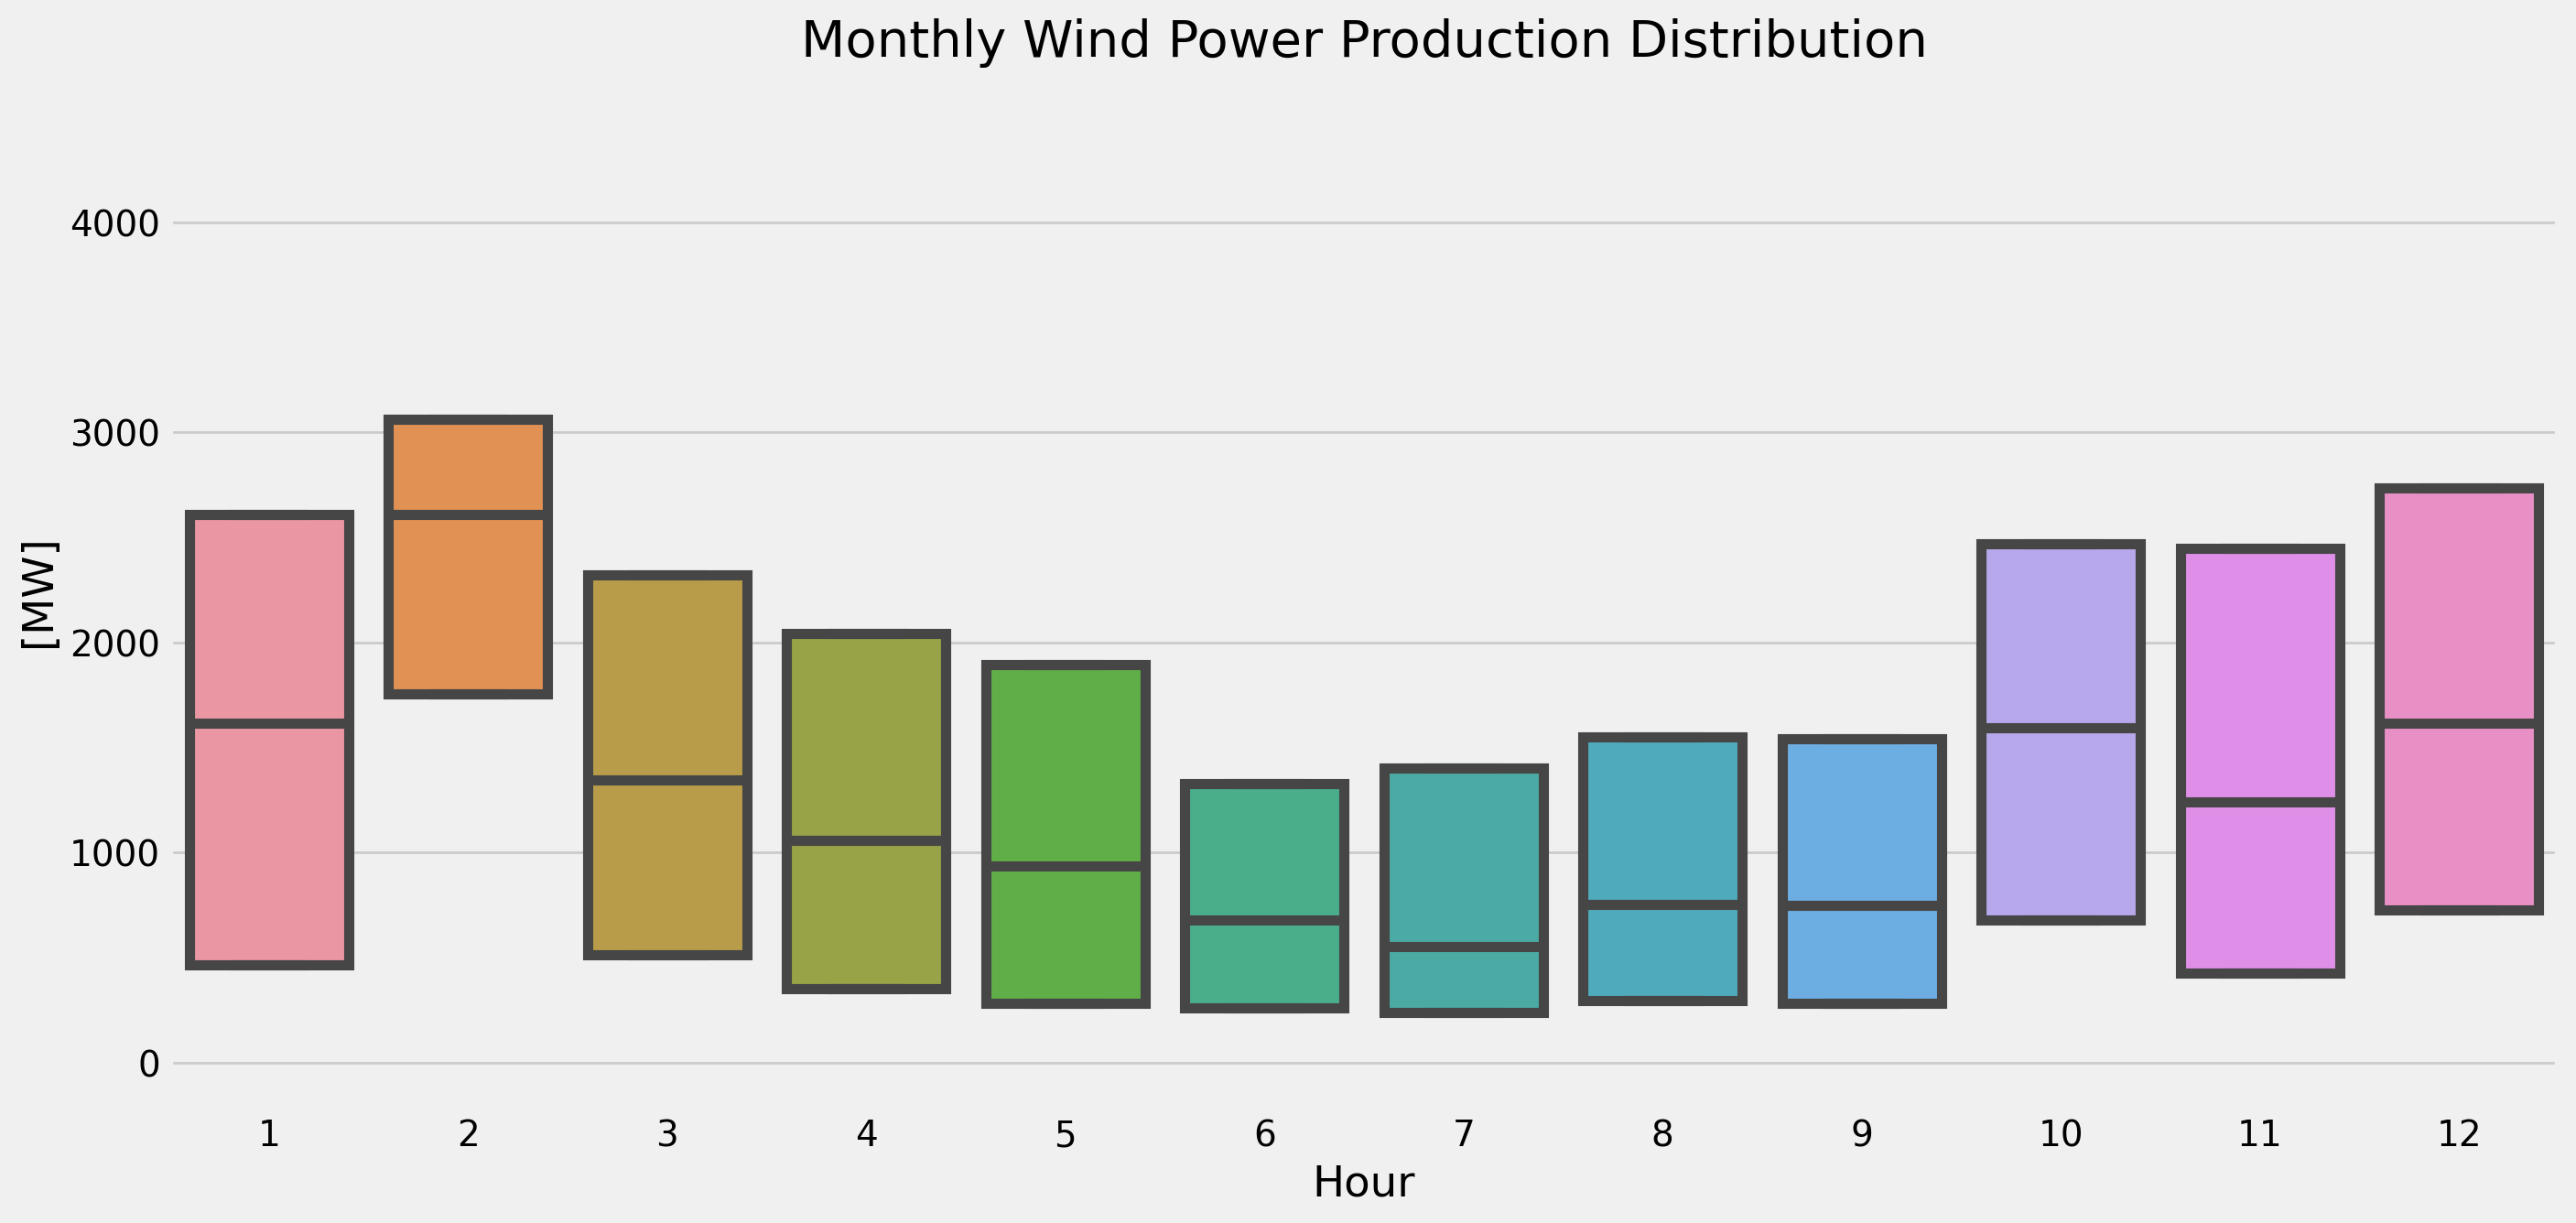

In [25]:
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(15, 7), dpi=DPI)
    sns.boxplot(data=wind, x='month', y='id_mw', fliersize=0, whis=0)
    ax.set_xlabel("Hour"); ax.set_ylabel("[MW]")
    ax.set_title("Monthly Wind Power Production Distribution")
    plt.show()

#### Trends in wind

In [26]:
# Let's check error metrics for wind forecasts:
total_mae = mean_absolute_error(wind.loc["2022"].dropna()["rt_mw"], wind.loc["2022"].dropna()["id_mw"])
total_rmse = mean_squared_error(wind.loc["2022"].dropna()["rt_mw"], wind.loc["2022"].dropna()["id_mw"], squared=False)
print(f"Total MAE: {total_mae:.2f}MW | Total RMSE: {total_rmse:.2f}MW")

Total MAE: 261.24MW | Total RMSE: 366.96MW


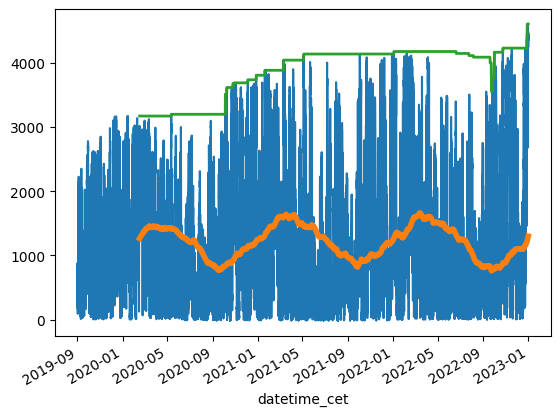

In [66]:
wind["rt_mw"].dropna().plot()
wind["rt_mw"].dropna().rolling(4*24*7*4*6, center=False).mean().plot(lw=4)
wind["rt_mw"].dropna().rolling(4*24*7*4*6, center=False).max().plot(lw=2)
plt.show()

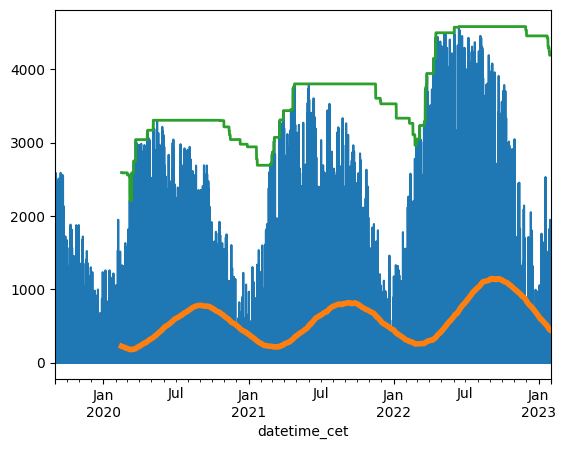

In [63]:
df["solar_rt_mw"].dropna().plot()
df["solar_rt_mw"].dropna().rolling(4*24*7*4*6, center=False).mean().plot(lw=4)
df["solar_rt_mw"].dropna().rolling(4*24*7*4*6, center=False).max().plot(lw=2)
plt.show()

---

## Load Forecasts

In [10]:
load = df[["load_rt_mw", 
           "total_load_last_mw",
           "total_load_forecast_last_p10_mw",
           "total_load_forecast_last_p90_mw"]].copy()
load = load.rename(columns={
    "total_load_forecast_last_p10_mw": "p10",
    "total_load_forecast_last_p90_mw": "p90",
    "load_rt_mw": "rt_mw"})

load = create_datetime_features(load)

print("Macro-scale descriptive stats:")
print(load["rt_mw"].describe(),"\n")

Macro-scale descriptive stats:
count    119850.000000
mean       9454.916016
std        1315.715332
min        6143.479980
25%        8423.488281
50%        9443.030273
75%       10386.317383
max       13562.250000
Name: rt_mw, dtype: float64 



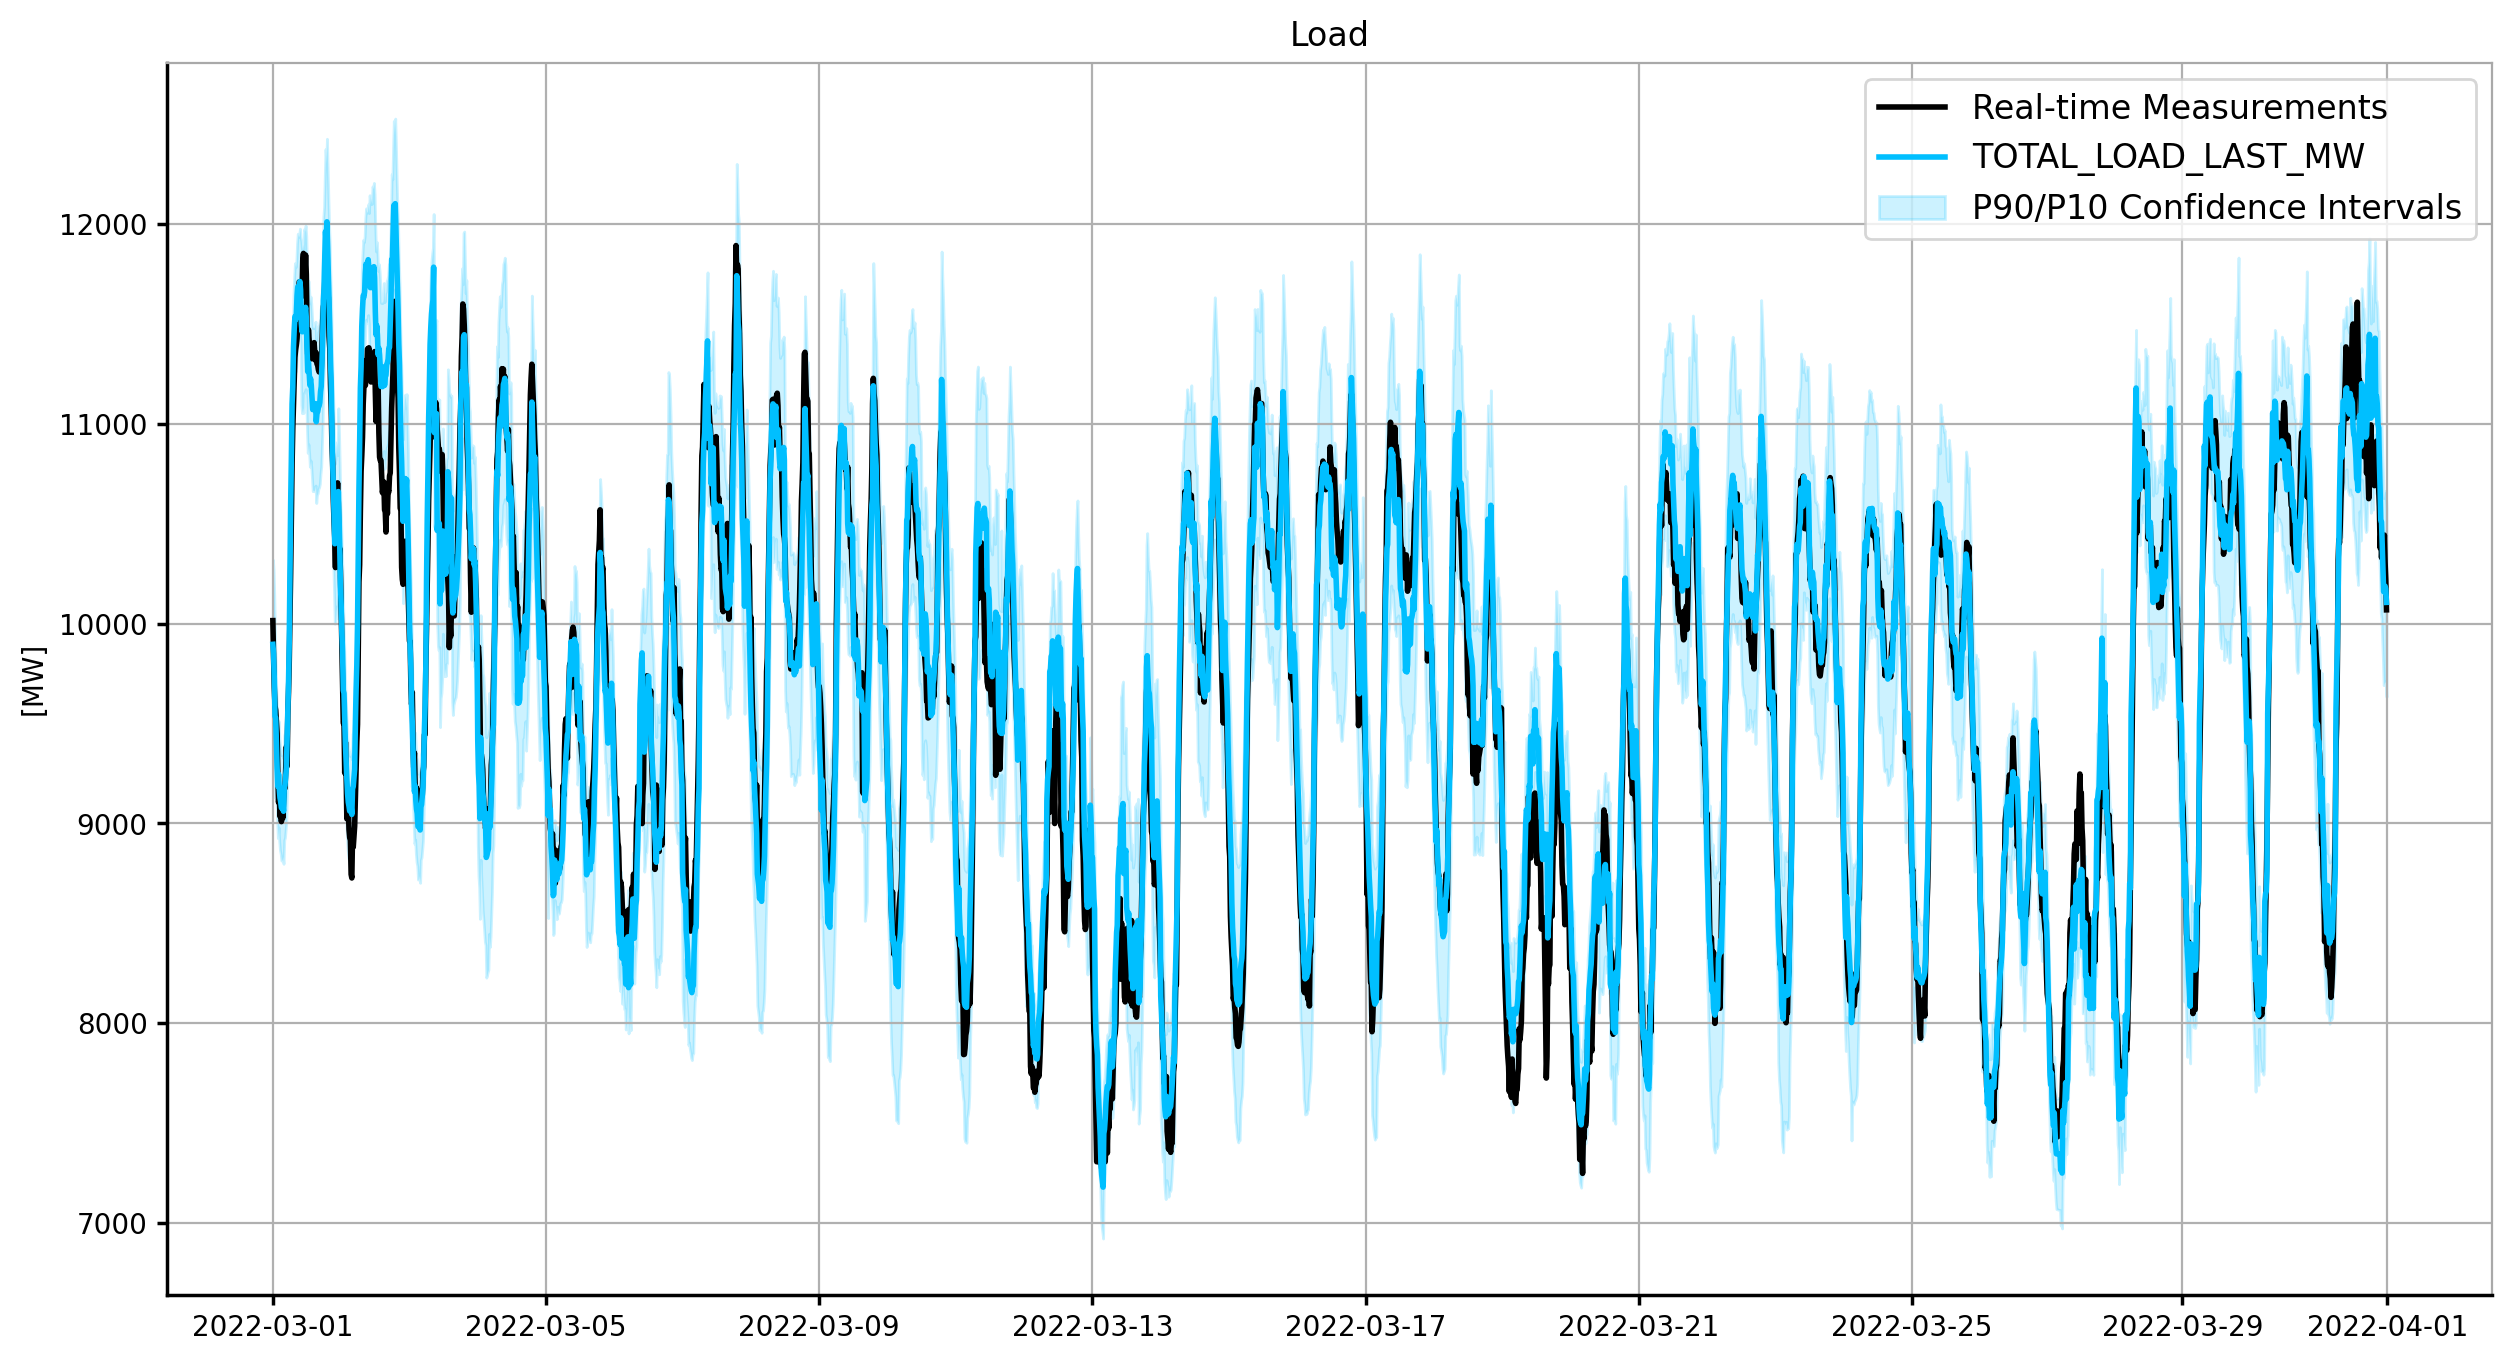

In [8]:
load_subset = load.query("year==2022 and month==3")

fig, ax = plt.subplots(figsize=[15,8], dpi=DPI)
ax.plot(load_subset["rt_mw"], linewidth=2, c = "k", label="Real-time Measurements")
ax.plot(load_subset["total_load_last_mw"], linewidth = 2, c = "deepskyblue", label="TOTAL_LOAD_LAST_MW")
ax.fill_between(load_subset.index, load_subset["p10"], load_subset["p90"], 
                color="deepskyblue", alpha=.2, label="P90/P10 Confidence Intervals")
ax.set_title("Load"); ax.set_ylabel("[MW]")
ax.legend(loc=1, frameon=True, prop={'size': 12})
my_plots.despine(ax=ax, grid=True)
# plt.ylim(0,)
plt.grid(); plt.show()

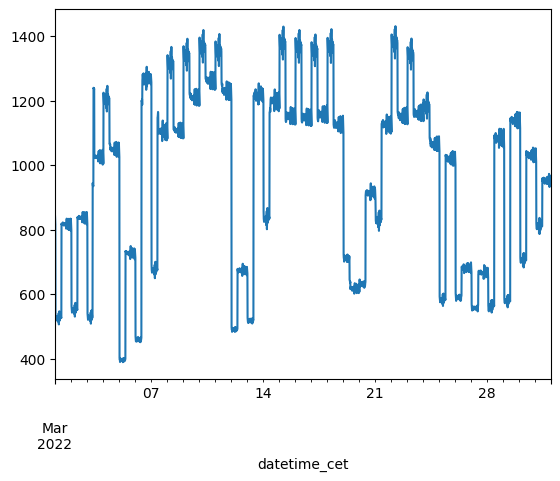

In [33]:
# Let's check the width of the interval:
(load_subset["p90"] - load_subset["p10"]).plot();

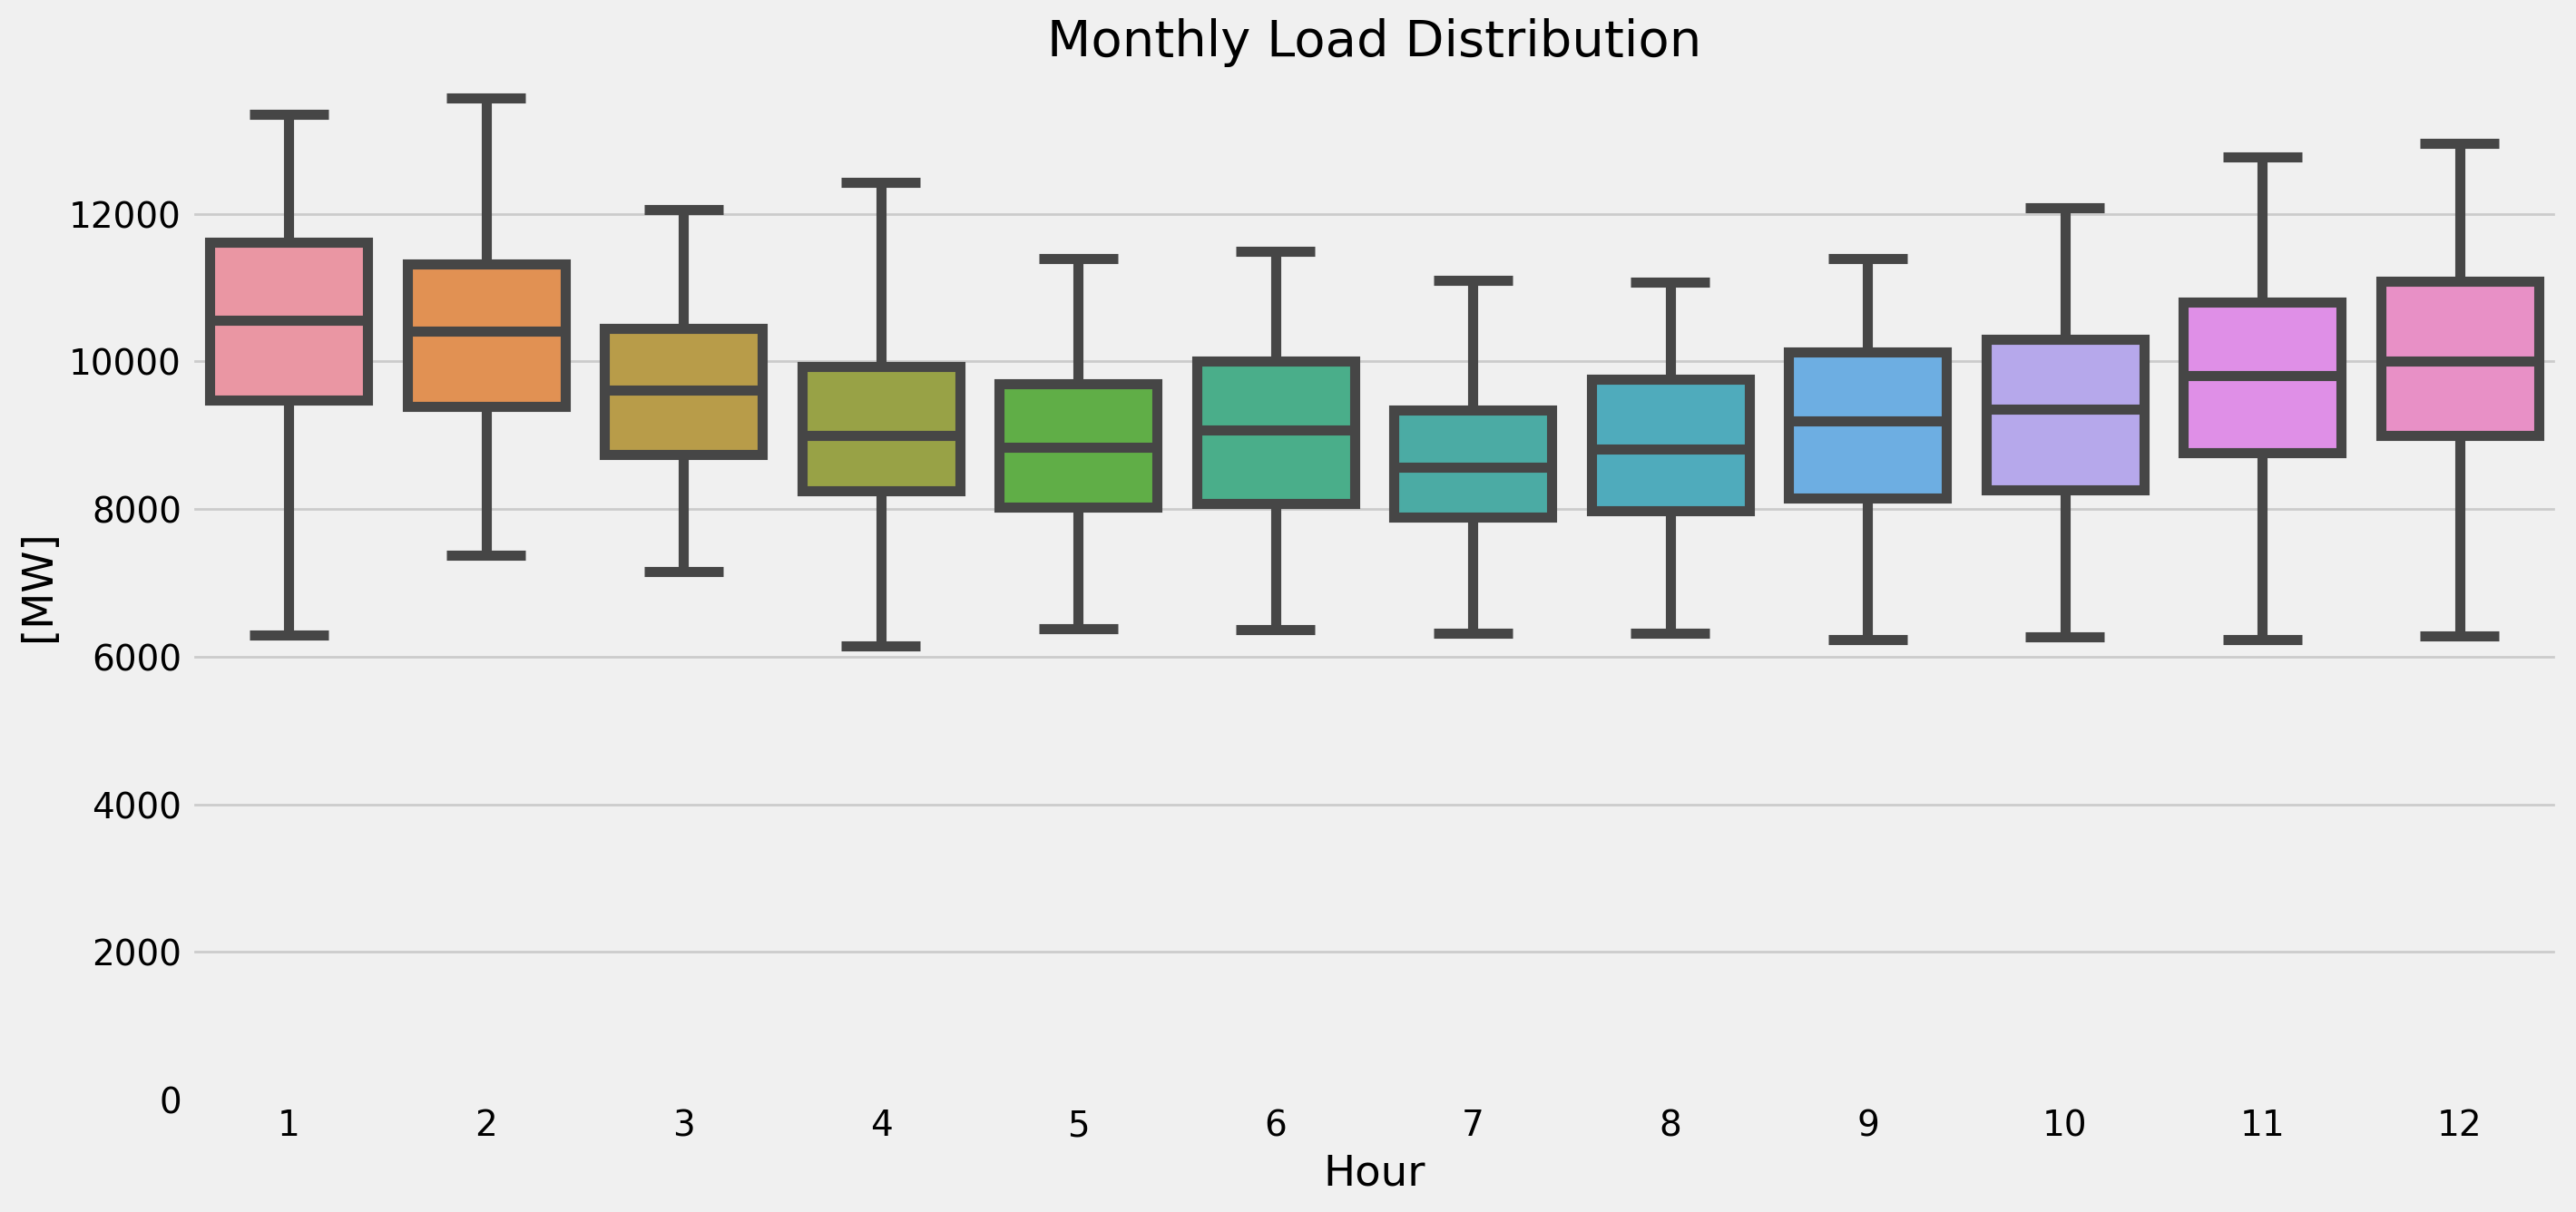

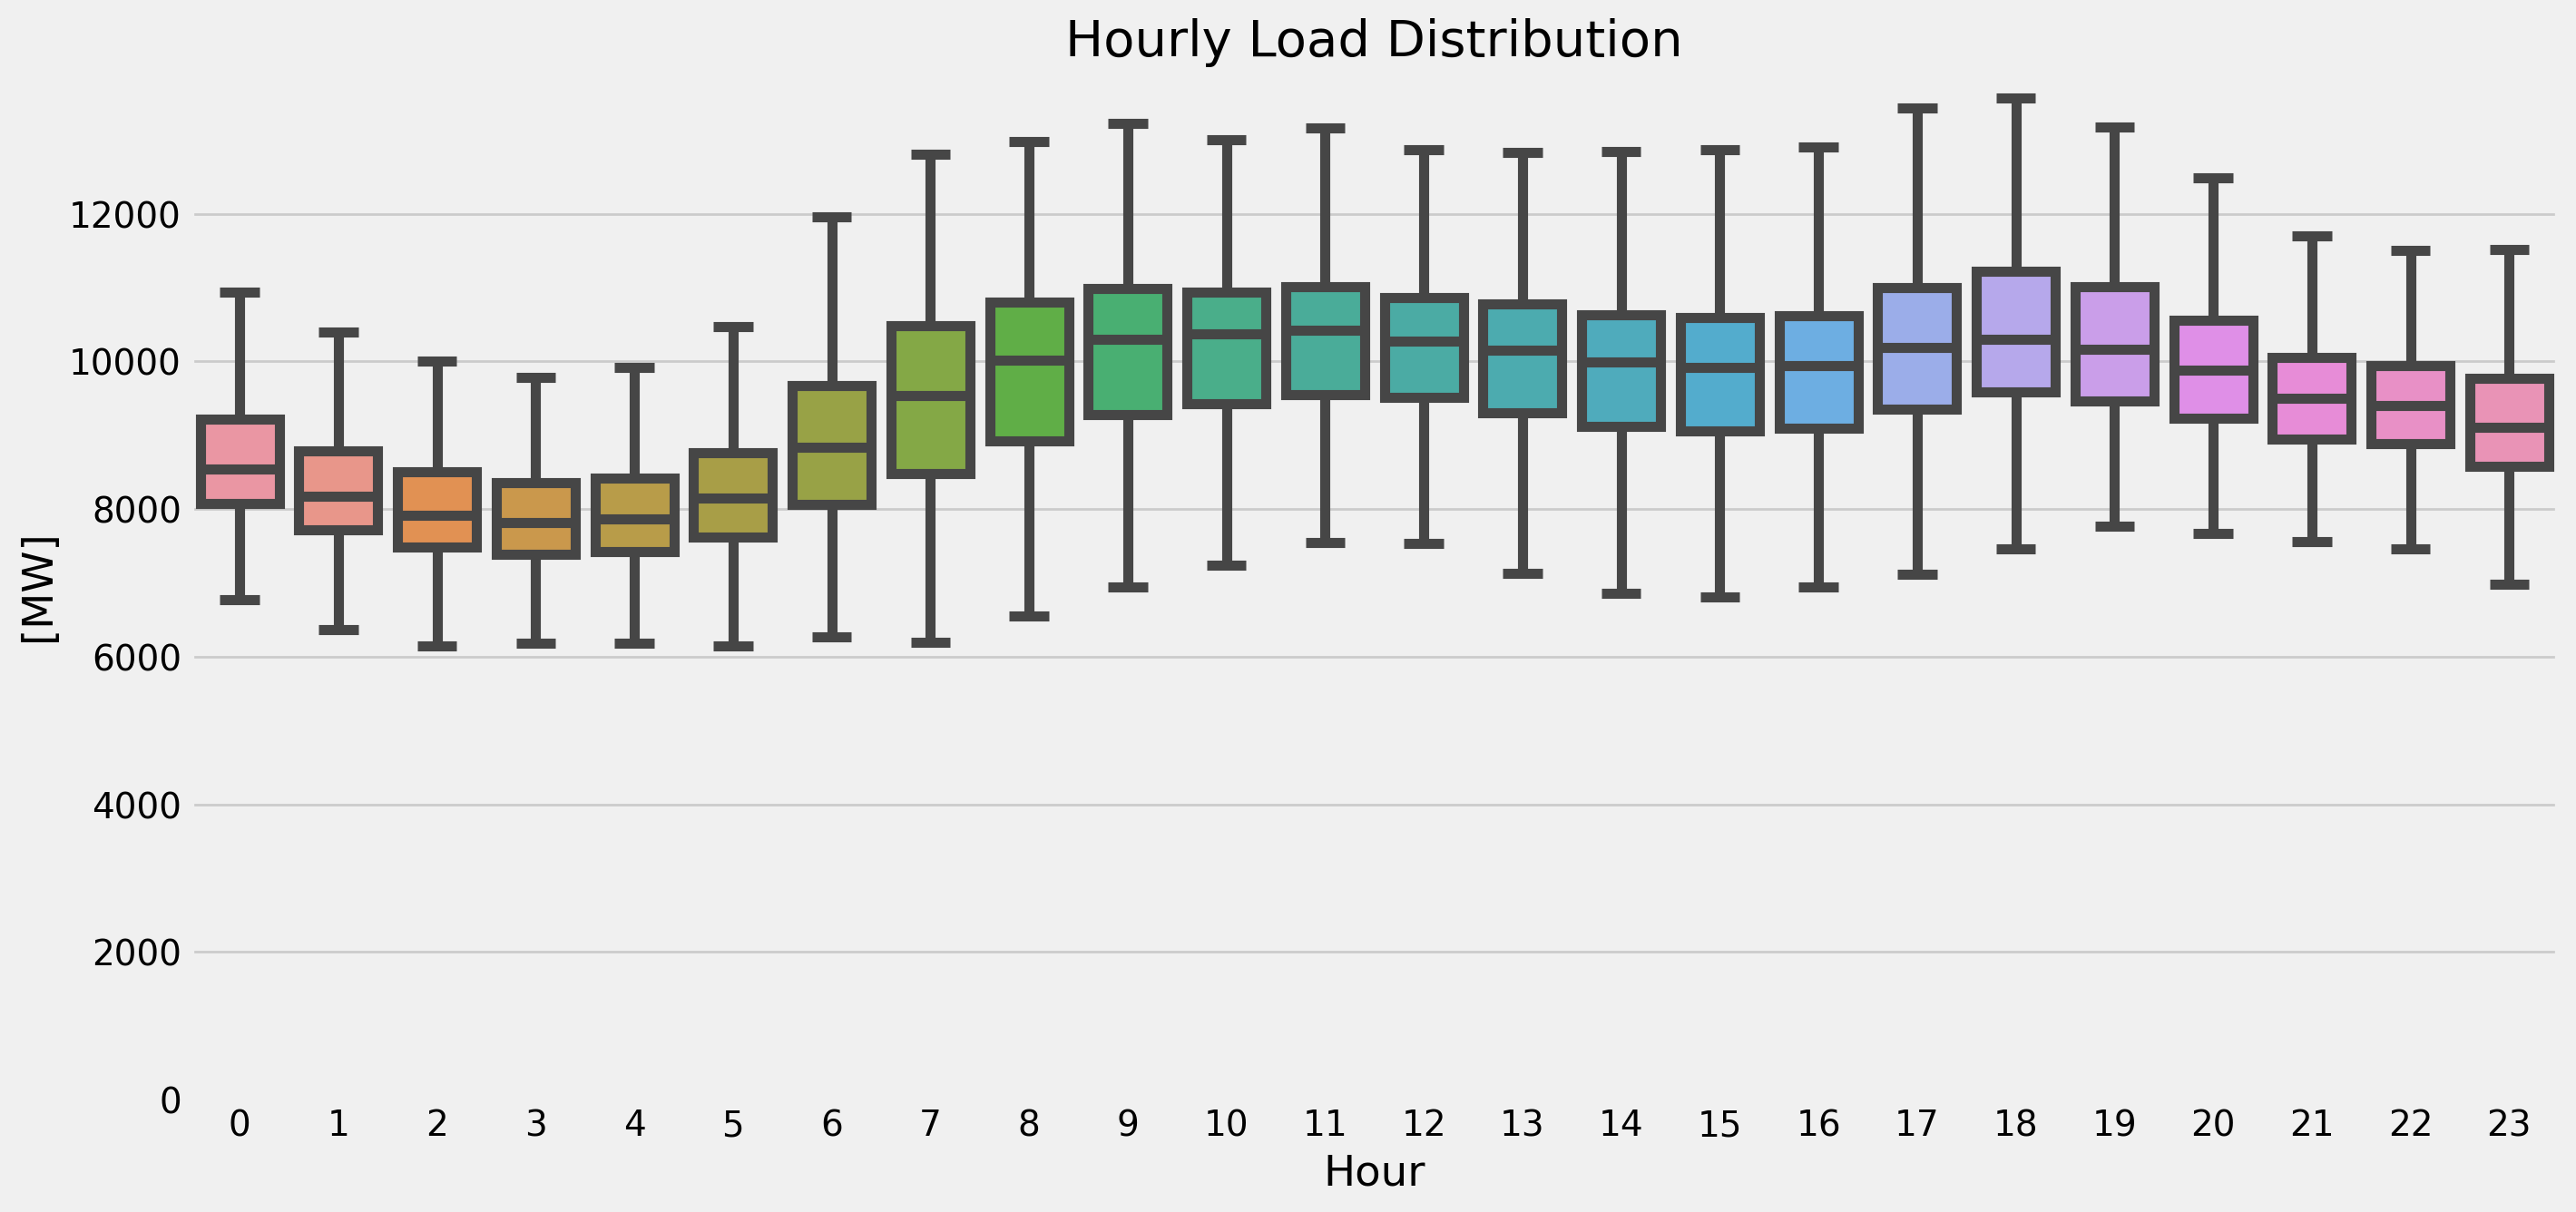

In [26]:
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(15, 7), dpi=DPI)
    sns.boxplot(data=load, x='month', y='rt_mw', fliersize=0)
    ax.set_ylim(0,)
    ax.set_ylabel("[MW]"); ax.set_xlabel("Hour")
    ax.set_title("Monthly Load Distribution")
    plt.show()

    fig, ax = plt.subplots(figsize=(15, 7), dpi=DPI)
    sns.boxplot(data=load, x='hour', y='rt_mw', fliersize=0)
    ax.set_ylim(0,)
    ax.set_ylabel("[MW]"); ax.set_xlabel("Hour")
    ax.set_title("Hourly Load Distribution")
    plt.show()

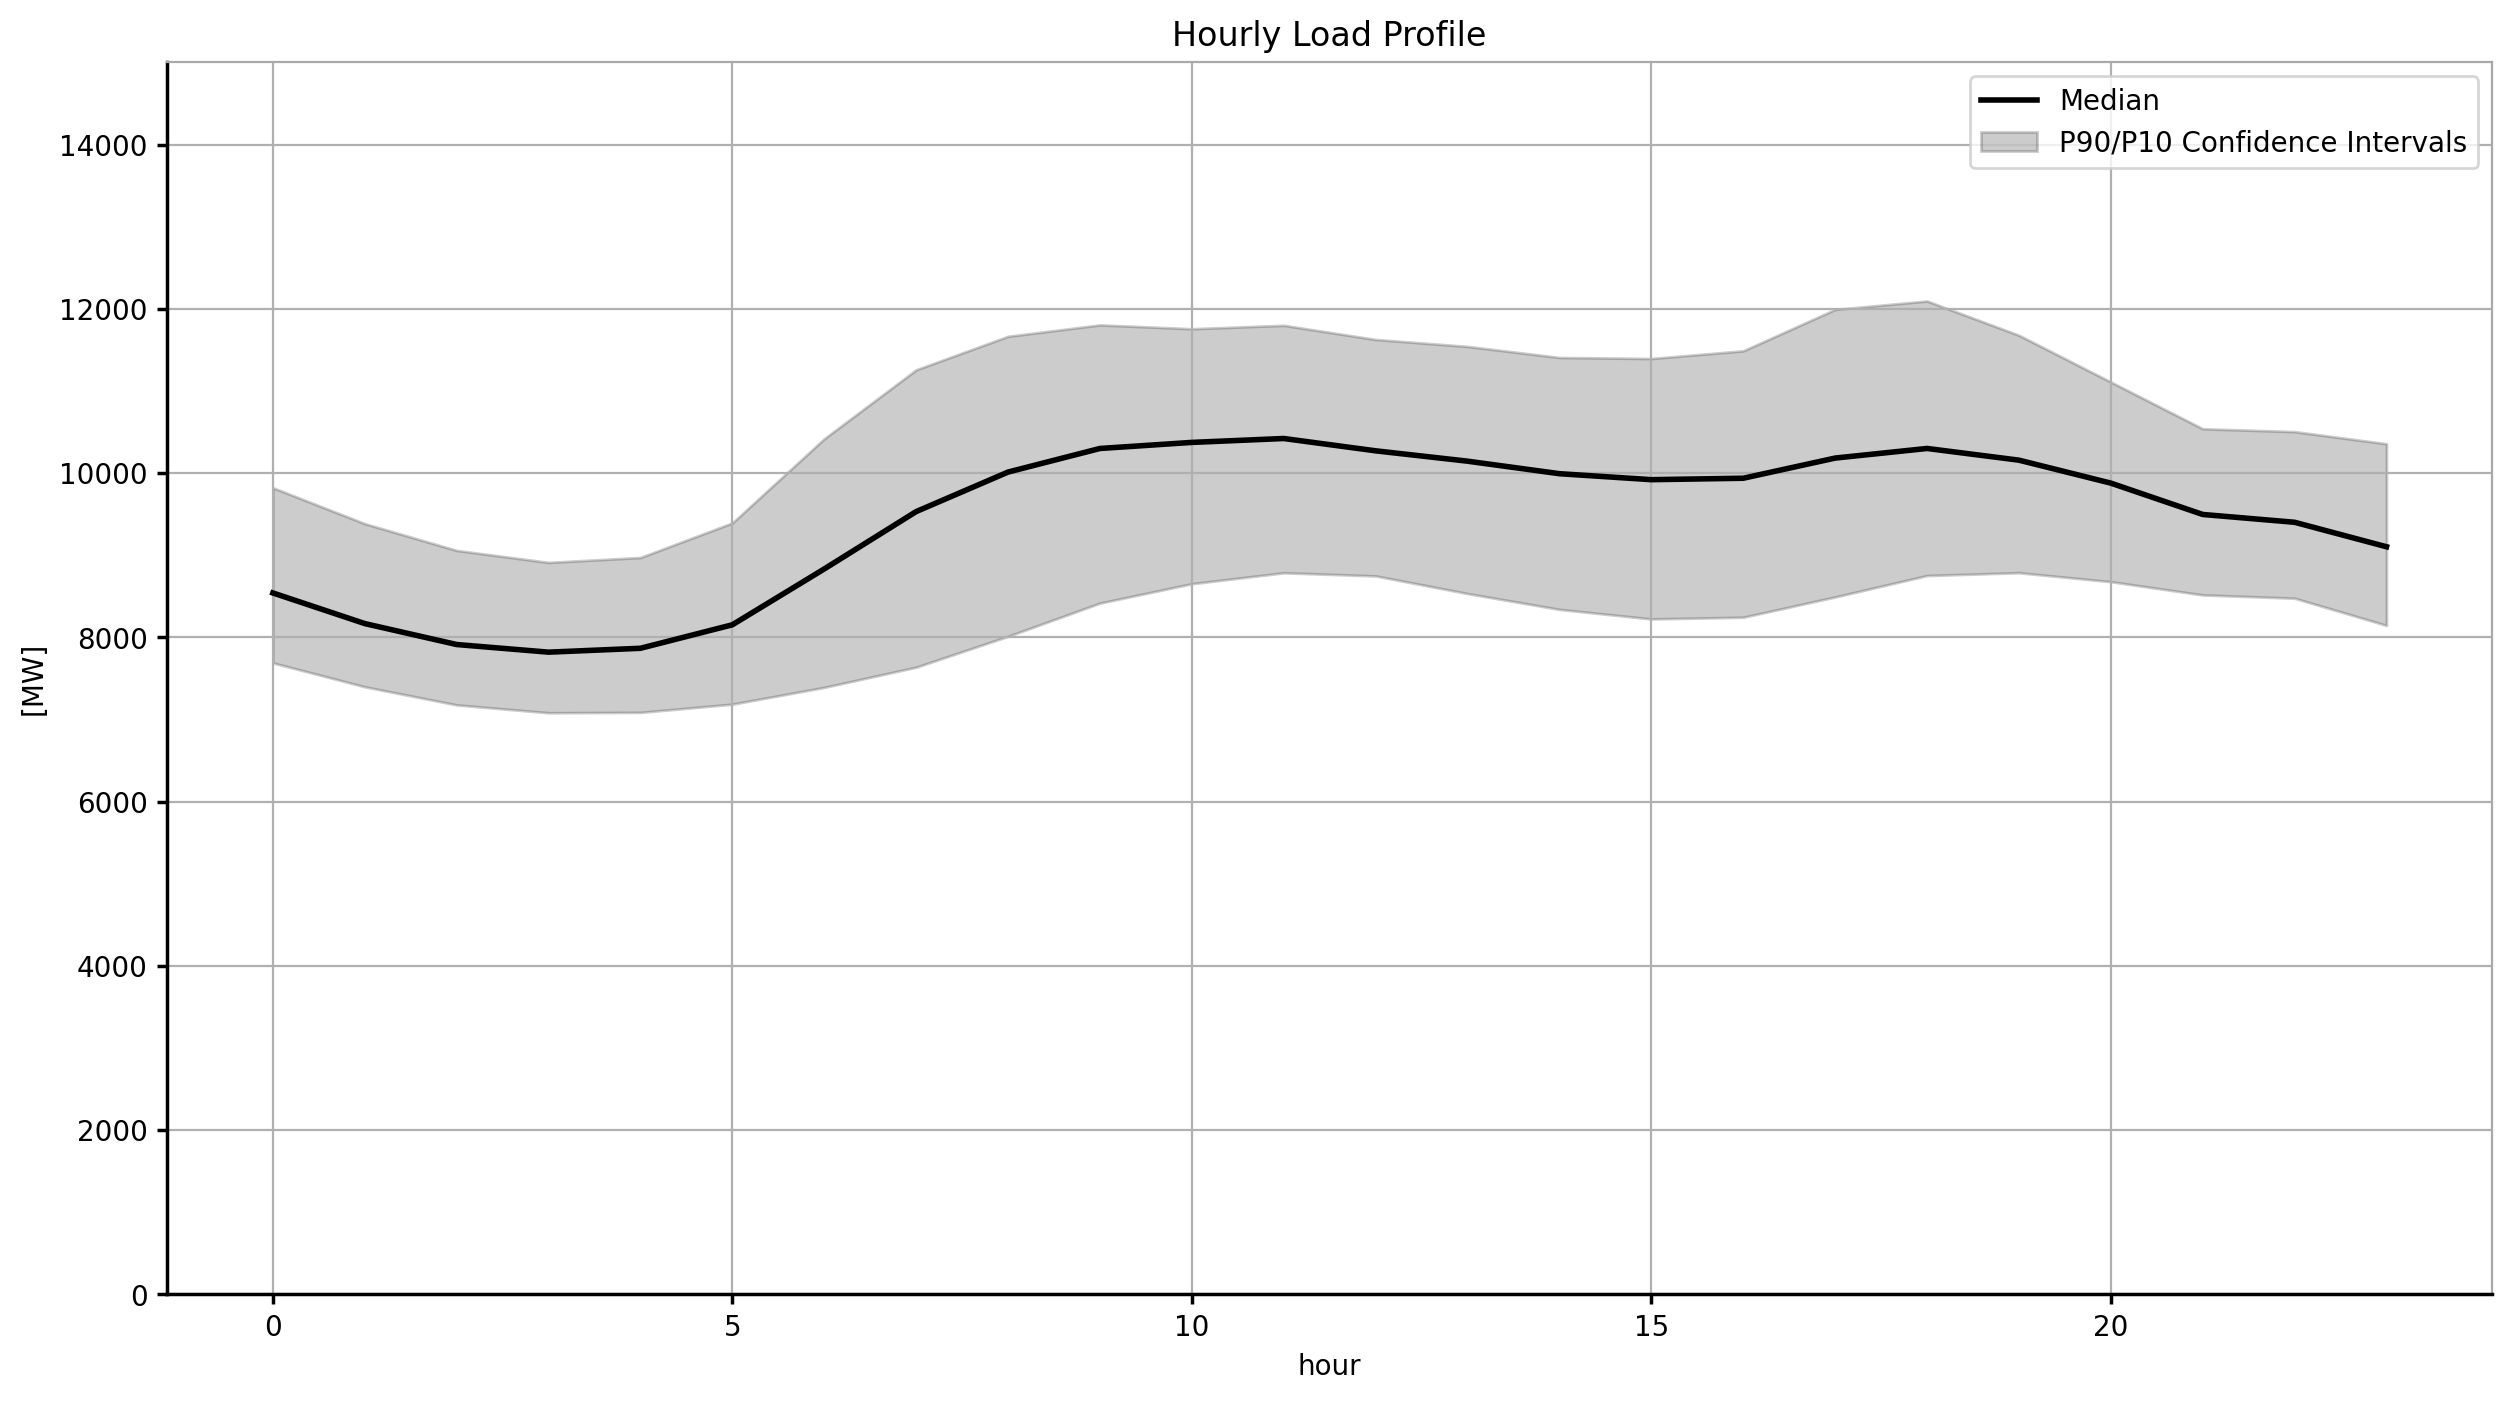

In [27]:
def get_CI(group):
    return pd.Series({"p10": group.quantile(q=0.10), "p50": group.median(), "p90": group.quantile(q=0.90)})

load_hourly = load.groupby("hour")["rt_mw"].apply(get_CI).unstack()

fig, ax = plt.subplots(figsize=[15,8], dpi=DPI)
load_hourly["p50"].plot(ax=ax, linewidth=2, c="k", label="Median")
ax.fill_between(load_hourly.index, load_hourly["p10"], load_hourly["p90"], 
                color="k", alpha=.2, label="P90/P10 Confidence Intervals")
ax.set_ylim(0, 15000)
ax.legend()
ax.set_ylabel("[MW]"); ax.set_title("Hourly Load Profile")
my_plots.despine(ax, True)
ax.grid()

#### Trends in load

In [24]:
# Let's check error metrics for load forecasts:
total_mae = mean_absolute_error(load.loc["2022"].dropna()["rt_mw"], load.loc["2022"].dropna()["total_load_last_mw"])
total_rmse = mean_squared_error(load.loc["2022"].dropna()["rt_mw"], load.loc["2022"].dropna()["total_load_last_mw"], squared=False)
print(f"Total MAE: {total_mae:.2f}MW | Total RMSE: {total_rmse:.2f}MW")

Total MAE: 156.34MW | Total RMSE: 206.05MW


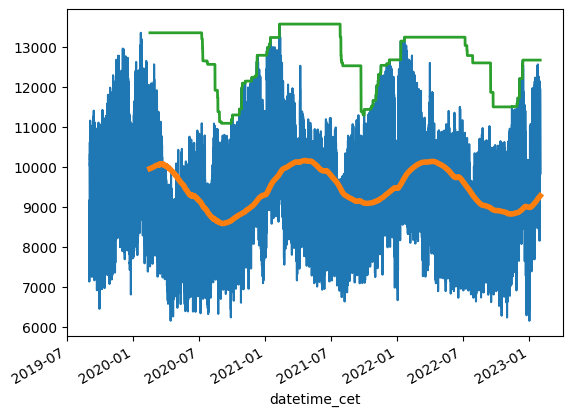

In [64]:
load["rt_mw"].dropna().plot()
load["rt_mw"].dropna().rolling(4*24*7*4*6, center=False).mean().plot(lw=4)
load["rt_mw"].dropna().rolling(4*24*7*4*6, center=False).max().plot(lw=2)
plt.show()

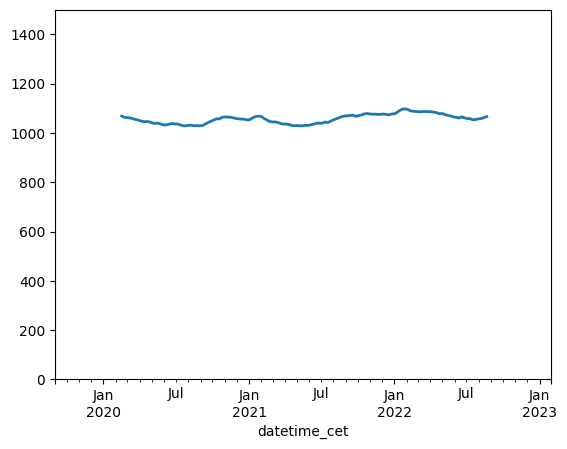

In [23]:
load["rt_mw"].dropna().groupby(pd.Grouper(freq='7D')).std().rolling(window=4*12, center=True).mean()\
        .plot(linewidth=2)
plt.ylim(0, 1500);

---

## Cumulative-15 System Imbalance

In [28]:
# Let's compare their descriptive statistics:
df[["si_mw", "system_imbalance_cum15"]].dropna().describe()

si_mw  system_imbalance_cum15
count  70044.000000            70044.000000
mean     -27.969162              -28.222029
std      180.081757              177.814835
min    -1419.709961            -1433.088989
25%     -127.429001             -126.085999
50%      -22.397500              -22.814000
75%       72.909248               71.512753
max     1135.152954             1155.879028

In [29]:
# Let's evaluate the difference between the two:
(df["si_mw"]-df["system_imbalance_cum15"]).dropna().describe()

count    70044.000000
mean         0.252865
std         22.170643
min       -928.737976
25%         -6.942000
50%          0.090000
75%          7.576252
max        586.119019
dtype: float64

In [30]:
# Let's have a look at high-disparity situations:
df.loc[(df["si_mw"]-df["system_imbalance_cum15"]).abs().ge(50)]

si_mw  system_imbalance_cum15      guv_mw  \
datetime_cet                                                                
2021-01-02 11:45:00+01:00 -172.932999             -243.802994  211.033005   
2021-01-02 12:00:00+01:00 -348.830994             -297.742004  299.545013   
2021-01-02 16:45:00+01:00 -459.976013             -353.372986  248.664001   
2021-01-02 17:00:00+01:00  221.985001              125.322998   37.827000   
2021-01-02 18:45:00+01:00  159.348007              100.468002   22.896999   
...                               ...                     ...         ...   
2022-12-15 07:00:00+01:00  -31.224001             -242.080994  350.476013   
2022-12-15 10:00:00+01:00 -564.161987             -664.104004  274.566010   
2022-12-18 11:45:00+01:00 -893.528015            -1259.551025  717.853027   
2022-12-18 12:00:00+01:00 -451.256989              -91.292999  632.822998   
2022-12-27 07:00:00+01:00  236.197006              288.894012    3.117000   

                               gdv_mw         ppos         pneg   wind_id_mw  \
datetime_cet                                                                   
2021-01-02 11:45:00+01:00    0.000000    72.739998    72.739998   190.272995   
2021-01-02 12:00:00+01:00    3.552000   144.770004   144.770004   327.290009   
2021-01-02 16:45:00+01:00    0.000000   105.269997   105.269997    46.564999   
2021-01-02 17:00:00+01:00  130.925995   -19.500000   -19.500000    67.292999   
2021-01-02 18:45:00+01:00  126.523003    10.630000    10.630000   103.406998   
...                               ...          ...          ...          ...   
2022-12-15 07:00:00+01:00  237.613007   850.000000   850.000000   207.533997   
2022-12-15 10:00:00+01:00    0.000000   799.000000   799.000000   312.496002   
2022-12-18 11:45:00+01:00    0.000000  1011.099976  1011.099976  2485.516113   
2022-12-18 12:00:00+01:00  144.358002  1450.000000  1450.000000  2528.527100   
2022-12-27 07:00:00+01:00  123.250000  -193.119995  -193.119995  2352.770996   

                            wind_rt_mw    load_rt_mw    load_id_mw  ...  \
datetime_cet                                                        ...   
2021-01-02 11:45:00+01:00    51.809940  10512.980469  10248.429688  ...   
2021-01-02 12:00:00+01:00    37.413147  10502.740234  10230.240234  ...   
2021-01-02 16:45:00+01:00   109.399269  10438.500000  10495.200195  ...   
2021-01-02 17:00:00+01:00   105.479980  10672.599609  10669.330078  ...   
2021-01-02 18:45:00+01:00   119.345291  10890.490234  10750.290039  ...   
...                                ...           ...           ...  ...   
2022-12-15 07:00:00+01:00    90.703842  11314.709961  11306.490234  ...   
2022-12-15 10:00:00+01:00   130.222305  12111.929688  12018.120117  ...   
2022-12-18 11:45:00+01:00  1861.789917  10871.589844  10615.940430  ...   
2022-12-18 12:00:00+01:00  1677.009521  10791.030273  10717.940430  ...   
2022-12-27 07:00:00+01:00  1804.137329   8222.790039   8270.129883  ...   

                           alpha_rt_      nrv_rt    price_da  \
datetime_cet                                                   
2021-01-02 11:45:00+01:00   2.750000  211.033005   52.150002   
2021-01-02 12:00:00+01:00  10.340000  295.993011   55.950001   
2021-01-02 16:45:00+01:00  37.380001  248.664001   59.990002   
2021-01-02 17:00:00+01:00  31.490000  -93.098999   62.000000   
2021-01-02 18:45:00+01:00   1.370000 -103.625999   63.080002   
...                              ...         ...         ...   
2022-12-15 07:00:00+01:00   0.000000  112.862999  477.739990   
2022-12-15 10:00:00+01:00   0.000000  274.566010  474.549988   
2022-12-18 11:45:00+01:00   0.000000  717.853027  250.190002   
2022-12-18 12:00:00+01:00   0.000000  488.464996  277.970001   
2022-12-27 07:00:00+01:00   0.080000 -120.133003  136.889999   

                           total_load_last_mw  \
datetime_cet                                    
2021-01-02 11:45:00+01:00        10143.910156   
2021-01-02 12:00:00+01:00        

---

## EMS Generation Data

In [31]:
# Load data:
ems = utils.load_ems_historical_data()

ems.info(memory_usage="deep", verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 921681 entries, 2021-04-01 00:00:00+02:00 to 2023-01-01 00:00:00+01:00
Columns: 13 entries, elia_sum_prod_mw_cm-value to elia_sum_prod_mw_wind_offsh_cm-value
dtypes: float32(13)
memory usage: 52.7 MB


In [32]:
ems.describe()

elia_sum_prod_mw_cm-value  elia_sum_prod_mw_wind_onsh_cm-value  \
count              921681.000000                        921681.000000   
mean                 8624.138672                           240.322800   
std                  1403.986938                           243.921204   
min                     0.000000                             0.000000   
25%                  7644.334961                            62.758938   
50%                  8534.702148                           155.908234   
75%                  9574.320312                           343.076599   
max                 14320.156250                          3508.497314   

       elia_sum_prod_mw_coal_pulv_cm-value  elia_sum_prod_mw_fuel_a_cm-value  \
count                             921681.0                     921681.000000   
mean                                   0.0                          0.857331   
std                                    0.0                          9.064620   
min                                    0.0                          0.000000   
25%                                    0.0                          0.000000   
50%                                    0.0                          0.000000   
75%                                    0.0                          0.000000   
max                                    0.0                        164.881271   

       elia_sum_prod_mw_natur_gas_cm-value  elia_sum_prod_mw_nuclear_cm-value  \
count                        921681.000000                      921681.000000   
mean                           1830.335205                        5028.412598   
std                            1091.323975                         671.911804   
min                               0.000000                           0.000000   
25%                             913.538757                        4715.313477   
50%                            1494.541138                        4920.729492   
75%                            2535.485107                        5669.096191   
max                            5266.182129                        6004.567383   

       elia_sum_prod_mw_other_cm-value  elia_sum_prod_mw_solar_cm-value  \
count                    921681.000000                    921681.000000   
mean                        666.568542                         0.838248   
std                         146.944458                         1.520297   
min                           0.000000                         0.000000   
25%                         561.072754                         0.000000   
50%                         715.722961                         0.000000   
75%                         774.695801                         1.258884   
max                        1565.554932                         8.953104   

       elia_sum_prod_mw_water_cm-value  elia_sum_prod_mw_wind_cm-value  \
count                    921681.000000                   921681.000000   
mean                        132.608200                      964.511658   
std                         241.171692                      932.204468   
min                           0.000000                        0.000000   
25%                           0.024111                      183.549438   
50%                           3.654212                      603.662659   
75%                         145.585922                     1610.000366   
max                        1196.455322                     4087.983643   

       elia_sum_prod_mw_wind_dgo_cm-value  elia_sum_prod_mw_wind_kla_cm-value  \
count                       921681.000000                       921681.000000   
mean                           143.068939                           23.328829   
std                            164.740845                           23.582581   
min                              0.000000                            0.000000   
25%                             32.561180                            3.897219   
50%                             88.270103                           1

(0.0, 15036.1640625)

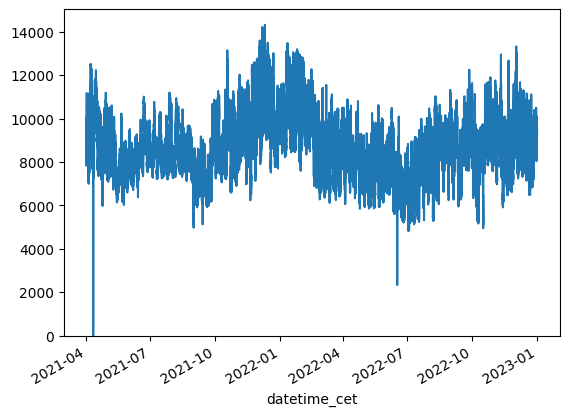

In [33]:
ems["elia_sum_prod_mw_cm-value"].plot()
plt.ylim(0,);

---

## Minute-wise data ACF/PACF

In [21]:
minute = utils.load_min_historical_data()

# Briefly describe:
minute.info(verbose=False)
print(f"\nAvailable time span: {(minute.index.max() - minute.index.min()).days/365 :.2f} years")
print("\nColumns:\n", list(minute.columns))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1051200 entries, 2021-01-01 00:00:00+01:00 to 2022-12-31 23:59:00+01:00
Freq: T
Columns: 8 entries, quality_status to negative_imbalance_price
dtypes: category(1), float32(7)
memory usage: 37.1 MB

Available time span: 2.00 years

Columns:
 ['quality_status', 'net_regulation_volume', 'system_imbalance', 'alpha', 'marginal_incremental_price', 'marginal_decremental_price', 'positive_imbalance_price', 'negative_imbalance_price']


In [5]:
# Store segments of minute dataset with missing data:
with_missing = minute.loc[minute.isnull().any(axis=1), minute.columns[minute.isnull().any(axis=0)]].copy()

print(f"{len(with_missing)} entries contain NaN")
print(set(with_missing.index.date))

540 entries contain NaN
{datetime.date(2022, 10, 30), datetime.date(2022, 4, 26), datetime.date(2022, 3, 22), datetime.date(2021, 7, 22), datetime.date(2022, 9, 22), datetime.date(2021, 1, 26), datetime.date(2021, 9, 17), datetime.date(2021, 10, 31), datetime.date(2021, 5, 27)}


#### ACF

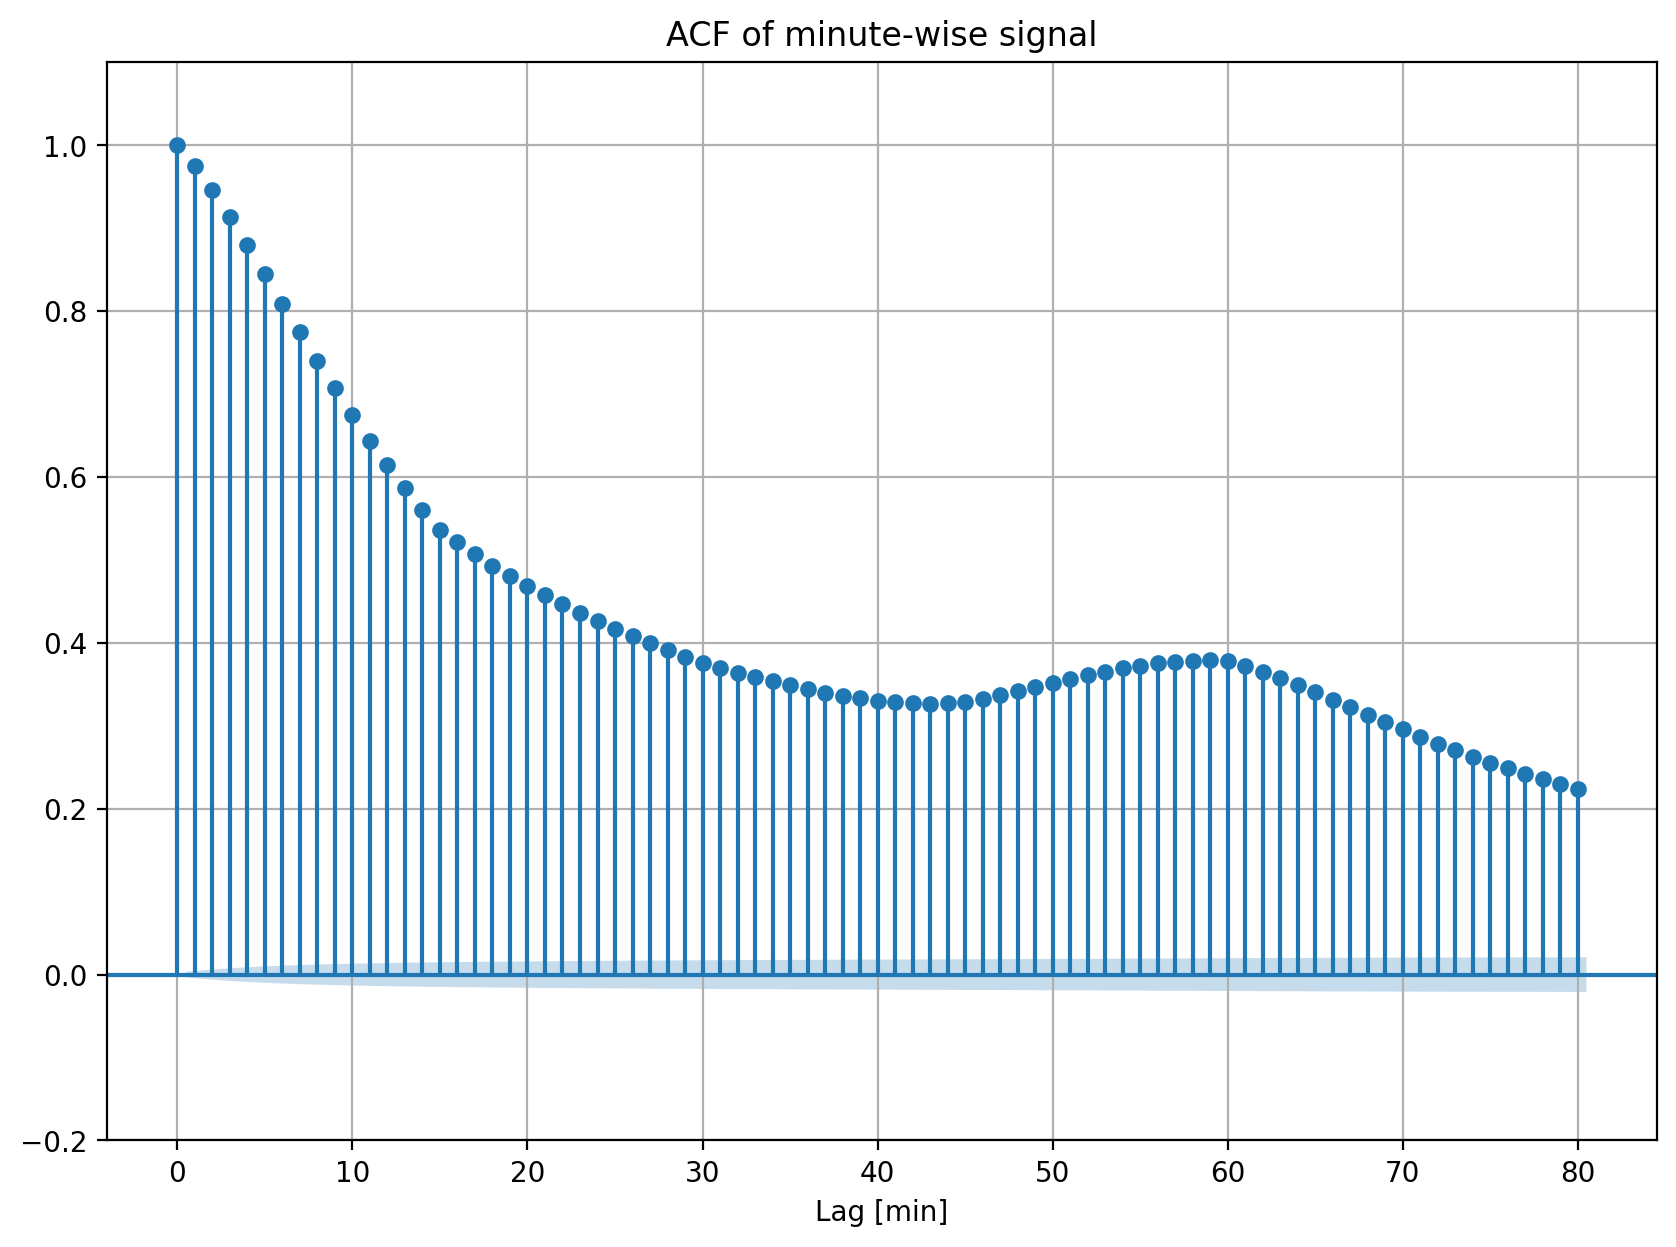

In [25]:
signal = minute["system_imbalance"].loc["2022-03":"2022-09"].dropna()


fig, ax = plt.subplots(figsize=(10, 7), dpi=DPI)
sm.graphics.tsa.plot_acf(signal, alpha=.05, lags=80,
                         ax=ax, title="ACF of minute-wise signal")
plt.ylim([-0.2,1.1])
plt.xlabel('Lag [min]')
plt.grid()
plt.show()

if output:
     fig.savefig("figures/fig10.png", dpi=300)

#### PACF

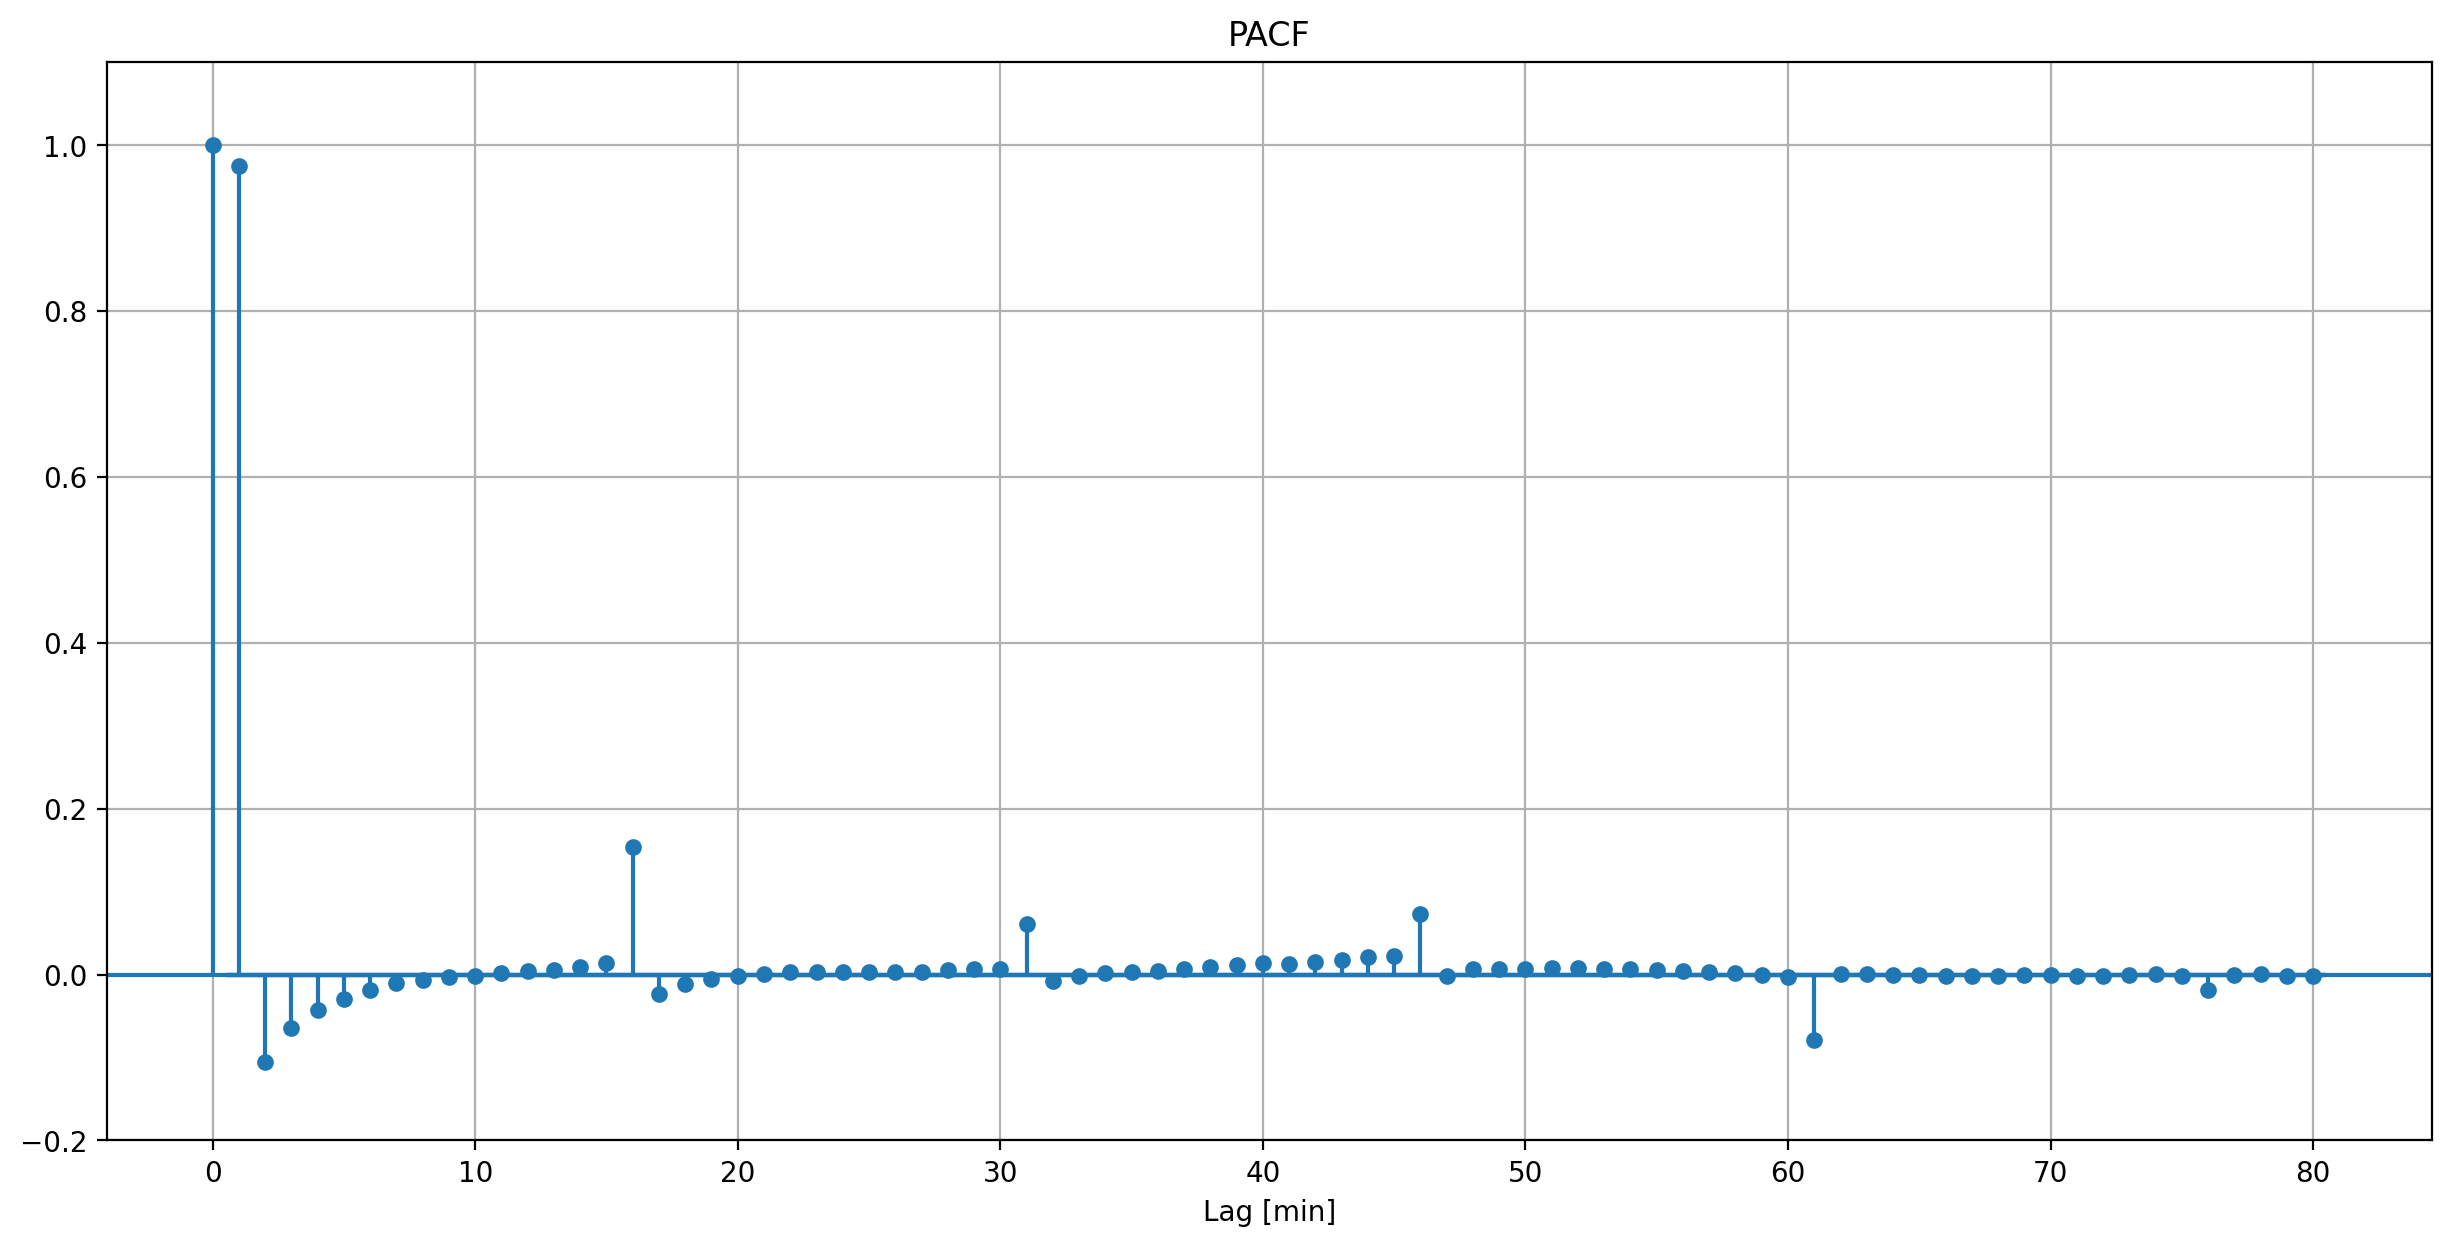

In [9]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=DPI)
sm.graphics.tsa.plot_pacf(signal, alpha=.05, lags=80,
                         ax=ax, title="PACF", method="ywm")
plt.ylim([-0.2,1.1])
plt.xlabel('Lag [min]')
plt.grid()
plt.show()

---

## Predictions

In [35]:
ensemble = pd.read_pickle("ensemble.pkl")

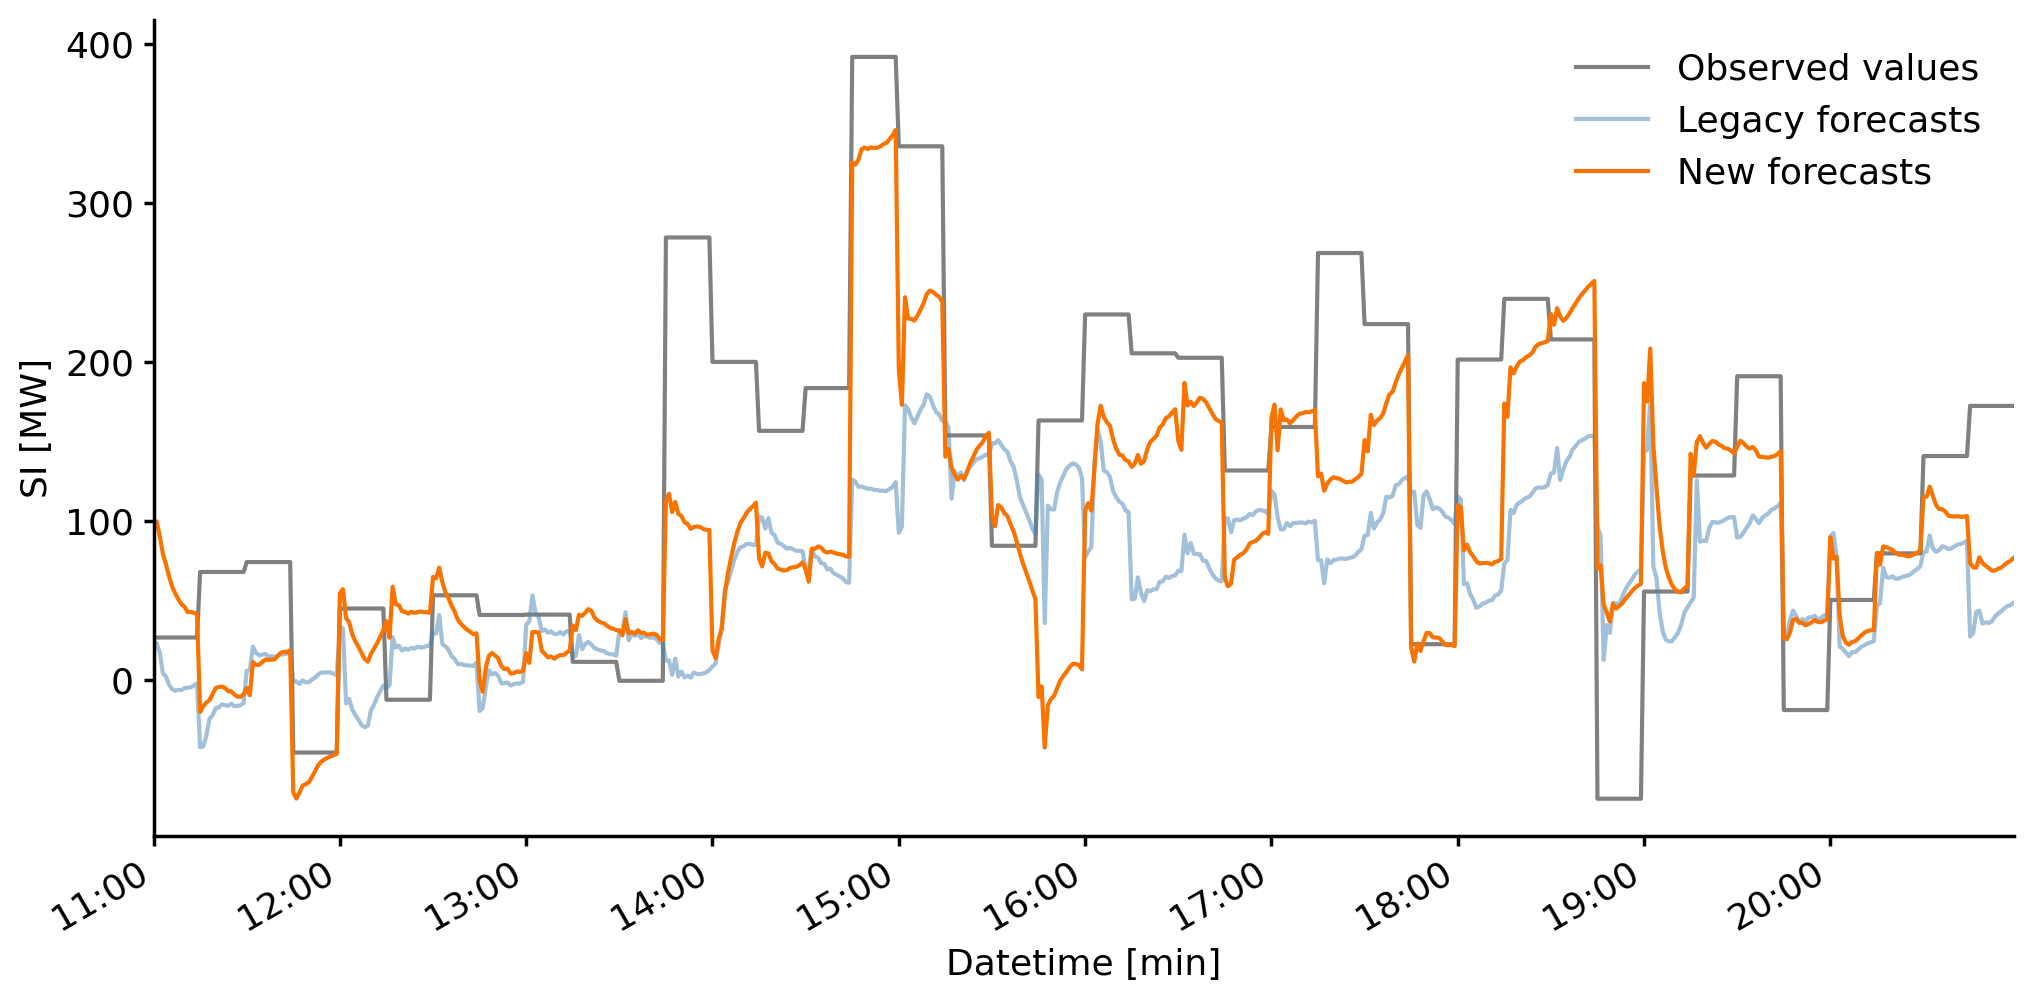

In [210]:
to_show1, to_show2 = "2022-12-31 12:00", "2022-12-31 23:00"

fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

plt.plot(ensemble[["y_test"]].loc[to_show1:to_show2],
    c="grey", alpha=1, lw=1.5)
plt.plot(ensemble[["legacy"]].loc[to_show1:to_show2],
    c="steelblue", alpha=0.5, lw=1.5)
plt.plot(ensemble[["linear15","mlp"]].mean(axis=1).loc[to_show1:to_show2],
    c=ELIA_ORANGE, alpha=1, lw=1.5)
# plt.plot(ensemble[["mlp"]].loc[to_show1:to_show2],
#     c=ELIA_ORANGE, alpha=1, lw=1.5)

ax.set_xlabel("Datetime [min]", fontsize=13); ax.set_ylabel("SI [MW]", fontsize=13)
plt.xticks(fontsize=13); plt.yticks(fontsize=13)

plt.legend(["Observed values", "Legacy forecasts", "New forecasts"],
    frameon=False, prop={'size': 13})

# plt.grid()
my_plots.despine(plt.gca(), grid=False)

plt.xlim([ensemble.loc[to_show1:to_show2].index[0], ensemble.loc[to_show1:to_show2].index[-1]])

ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
fig.autofmt_xdate()

if output:
     fig.savefig("/Users/tomasurdiales/Desktop/fig1.png", dpi=300)

plt.show()

---

## Time splits

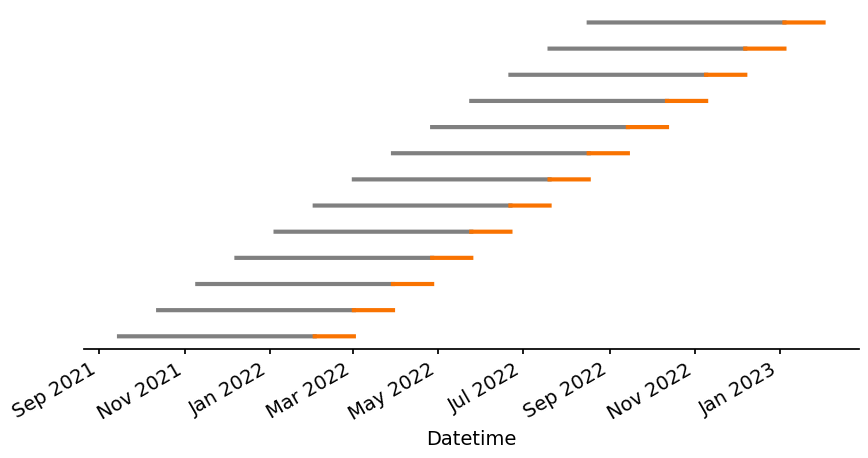

In [215]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Set up splits and model features:
tscv = TimeSeriesSplit(
    n_splits=52 // 2 // 2, max_train_size=4 * 24 * 7 * 20, test_size=4 * 24 * 7 * 2 * 2, gap=0
)
# For MLP:
# tscv = TimeSeriesSplit(
#     n_splits=52 // 2 // 2, 
#     max_train_size=4 * 24 * 7 * 70,
#     test_size=4 * 24 * 7 * 4,
#     gap=0
# )


fig, ax = plt.subplots(figsize=[10, 5])

for ii, (train_index, test_index) in enumerate(tscv.split(df)):
    y_train = df["si_mw"].iloc[train_index]
    y_test = df["si_mw"].iloc[test_index]

    # Plot to display datetime range of each split:
    ax.plot(y_train.apply(lambda x: ii), color="grey", alpha=1, linewidth=3)
    ax.plot(y_test.apply(lambda x: ii), color=ELIA_ORANGE, linewidth=3)


plt.ylim(-0.5, ii+0.5)

ax.get_yaxis().set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_linewidth(1.25)
ax.tick_params(width=1.25)

ax.set_xlabel("Datetime", fontsize=14)
plt.xticks(fontsize=14)
# ax.set_title("Cross-validation Train-Test Time-Splits")

ax.xaxis.set_major_locator(mdates.MonthLocator(list(np.arange(1, 12, 2))))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate()

fig.savefig("/Users/tomasurdiales/Desktop/cv_timesplits.png", dpi=300)

plt.show()